libraries

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from minepy import MINE
from skimage.draw import disk

import torch
import torchvision
from torch import nn
from torch import optim

In [3]:
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device('cuda')
else:
    print('CPU')
    device = torch.device('cpu')

CUDA


parameters

In [4]:
is_training = True

num_train_image, num_test_image = 1024*9, 1024
max_bright = 255

batchsize = 256

image_size = 64
channel = 3
train_latent = 2
test_latent = train_latent
lambda_dep_basic = 1
lambda_dep_dcor = 1
lambda_rec = 1
num_epoch = 100
lr = 0.001

np.random.seed(0)

create images composed with

angle theta of polar coordinate(1D, unit: 2pi/72), brightness of the green center ball(1D, range: [128, 255])

=> 72 * 128 = 9216 cases

In [5]:
def generating_data(num_image, image_size=64, max_bright=255):
    base_radius = int(np.sqrt(image_size))
    circle_radius = int(base_radius * 5 / 4)
    
    # angle theta, range: [0, 355], 72 cases
    theta = np.deg2rad(5 * np.random.randint(0, 72, size=num_image))
    scaled_x1, scaled_x2 = np.cos(theta), 1 * np.sin(theta)
    set_x1 = np.round(image_size//2 + ((int(image_size-circle_radius) - circle_radius)/2) * scaled_x1, 0).astype(int)
    set_x2 = np.round(image_size//2 + ((int(image_size-circle_radius) - circle_radius)/2) * scaled_x2, 0).astype(int)
    
    # brightness of the green center ball, range: [128, 255], 128 cases
    set_green = np.random.randint(max_bright//2+1, max_bright+1, size=num_image)
    
    list_image = []
    for n_image in range(num_image):
        img = np.zeros((3, image_size, image_size), dtype=np.uint8)
        
        x1, x2 = set_x1[n_image], set_x2[n_image]
        rr_x, cc_x = disk((x2, x1), circle_radius)
        img[:, rr_x, cc_x] = max_bright

        green = set_green[n_image]
        rr_G, cc_G = disk((image_size//2, image_size//2), base_radius)
        img[1, rr_G, cc_G] = green

        list_image.append(np.expand_dims(img,0))

    list_image = np.concatenate(list_image,0)
    return list_image
                    
train_images =  generating_data(num_train_image,image_size=image_size,max_bright=max_bright)
test_images =  generating_data(num_test_image,image_size=image_size,max_bright=max_bright)

In [6]:
train_images.shape, test_images.shape

((9216, 3, 64, 64), (1024, 3, 64, 64))

In [7]:
train_dataset = torch.stack([torch.Tensor(i) for i in train_images]) / max_bright
test_dataset = torch.stack([torch.Tensor(i) for i in test_images]) / max_bright
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

batch_idx 0
torch.Size([256, 3, 64, 64])
<class 'torch.Tensor'>


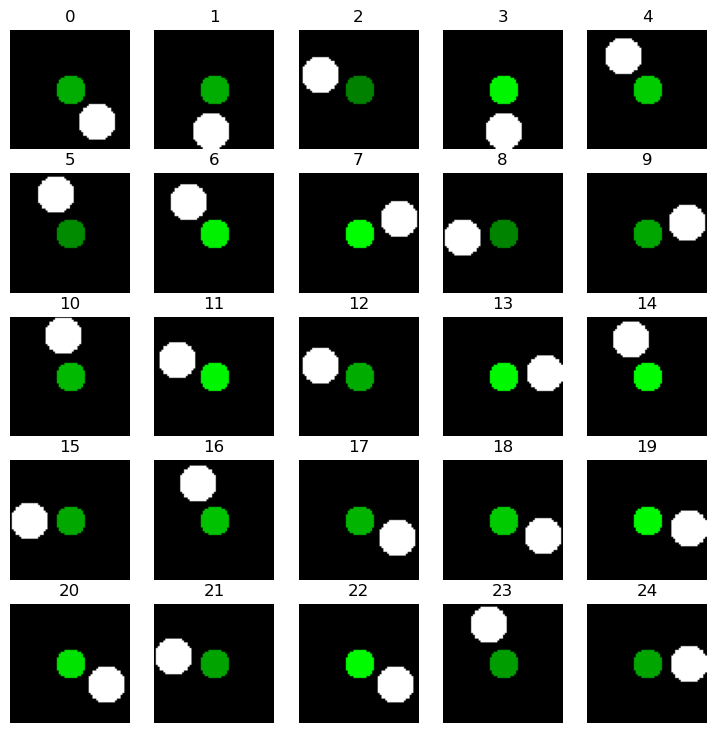

In [8]:
img_plot_size = 5
img_sample_num = int(img_plot_size**2)

plt.figure(figsize=(9, 9))
for batch_idx, data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print(data.shape)
    print(type(data))
    for i in range(img_sample_num):
        ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
        ax.title.set_text('{}'.format(i))
        img = data[i].permute(1,2,0)
        plt.imshow(img)
        plt.axis("off")
    if batch_idx == 0:
        break

encoder and decoder

In [9]:
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, a, b, eps=1e-8, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1,).tolist()):
            raise ValueError('Incorrect truncation range')
        self._dtype_min_gt_0 = torch.tensor(torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._dtype_max_lt_1 = torch.tensor(1 - torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * self.b - self._little_phi_a * self.a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @property
    def mean(self):
        return self._mean

    @property
    def variance(self):
        return self._variance

    @property
    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)

    def expand(self, batch_shape, _instance=None):
        # TODO: it is likely that keeping temporary variables in private attributes violates the logic of this method
        raise NotImplementedError


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'loc': constraints.real,
        'scale': constraints.positive,
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, a, b, eps=1e-8, validate_args=None):
        self.loc, self.scale, self.a, self.b = broadcast_all(loc, scale, a, b)
        a_standard = (a - self.loc) / self.scale
        b_standard = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a_standard, b_standard, eps=eps, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale

In [10]:
def truncated_normal(loc=0., scale=0.05, a=-1., b = 1.):
    return TruncatedNormal(loc, scale, a, b)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
       # print("Initialisation with truncated normal !")
        truncated_normal(m.weight)
        m.bias.data.fill_(0)

In [11]:
class Encoder(nn.Module):
    def __init__(self, code_size=1, kernel_size=4, channel=1):
        super(Encoder, self).__init__()        
        self.latent_dim = code_size
        
        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(channel, int(code_size*32), kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(int(code_size*32), int(code_size*16), kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(int(code_size*16), int(code_size*8), kernel_size, **cnn_kwargs)
        self.conv4 = nn.Conv2d(int(code_size*8), int(code_size*4), kernel_size, **cnn_kwargs)
        self.conv5 = nn.Conv2d(int(code_size*4), int(code_size*2), kernel_size, **cnn_kwargs)
        self.conv6 = nn.Conv2d(int(code_size*2), code_size, kernel_size, **cnn_kwargs)
        self.zero_mean = nn.BatchNorm1d(code_size, eps=0, affine=False, track_running_stats=True)
        # adapt ReLu's variants to prevent zero gradients when all outputs are below zero
        self.gelu = nn.GELU() 
        
    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with GELU activations
        x = self.gelu(self.conv1(x))
        x = self.gelu(self.conv2(x))
        x = self.gelu(self.conv3(x))
        x = self.gelu(self.conv4(x))
        x = self.gelu(self.conv5(x))
        x = self.conv6(x)
        z = x.view((batch_size, -1))
        z = self.zero_mean(z)
        
        return z

In [12]:
class Decoder(nn.Module):
    def __init__(self, code_size=1, kernel_size=4, channel=1):
        super(Decoder, self).__init__()
        # Shape required to start transpose convs
        self.reshape = (code_size, 1, 1)
         
        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.convT6 = nn.ConvTranspose2d(code_size, int(code_size*2), kernel_size, **cnn_kwargs)
        self.convT5 = nn.ConvTranspose2d(int(code_size*2), int(code_size*4), kernel_size, **cnn_kwargs)
        self.convT4 = nn.ConvTranspose2d(int(code_size*4), int(code_size*8), kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(int(code_size*8), int(code_size*16), kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(int(code_size*16), int(code_size*32), kernel_size, **cnn_kwargs)
        self.convT1 = nn.ConvTranspose2d(int(code_size*32), channel, kernel_size, **cnn_kwargs)
        self.gelu = nn.GELU()
        
    def forward(self, z):
        batch_size = z.size(0)
        x = z.view(batch_size, *self.reshape)
        
        # Convolutional layers with GELU activations
        x = self.gelu(self.convT6(x))
        x = self.gelu(self.convT5(x))
        x = self.gelu(self.convT4(x))
        x = self.gelu(self.convT3(x))
        x = self.gelu(self.convT2(x))
        # Sigmoid activation for final conv layer
        x = nn.Sigmoid()(self.convT1(x))

        return x

reconstruction loss

In [13]:
def reconstruction_loss(data_rec, data, MSE=True):
    if MSE:
        return nn.MSELoss()(data_rec, data)
    else:
        return nn.BCELoss()(data_rec, data)

Pearson correlation loss (covariance loss)

In [14]:
def covariance_loss(z,step):
    if step>1:
        loss = 0
        for idx in range(step-1):
            loss += ((z[:,idx]*z[:,-1]).mean())**2
        loss = loss/(step-1)
    else:
        loss = torch.zeros_like(z)
    return loss.mean()

distance correlation loss

In [15]:
def dcor_loss(z, step, device="cuda"):
    if step>1:
        batch_size = z.size(dim=0)
        z_k = z[:, -1]
        B = torch.abs(z_k.reshape(-1, 1) - z_k)
        M = torch.full(size=(batch_size, batch_size), fill_value=1/batch_size).to(device)
        I_minus_M = torch.subtract(torch.eye(batch_size).to(device), M)
        B_tilda = torch.matmul(torch.matmul(I_minus_M, B), I_minus_M)
        flat_B_tilda = B_tilda.flatten()
        dvar_sq_y = torch.dot(flat_B_tilda, flat_B_tilda)
        
        loss = 0
        for idx in range(step-1):
            z_i = z[:, idx]
            
            # define distance matrix
            A = torch.abs(z_i.reshape(-1, 1) - z_i)
            
            # center both the rows and columns of each matrix
            A_tilda = torch.matmul(torch.matmul(I_minus_M, A), I_minus_M)
            
            # calculate distance covariance squared. omit n**2 division
            flat_A_tilda = A_tilda.flatten()
            dcov_sq_xy = torch.dot(flat_A_tilda, flat_B_tilda)
            dvar_sq_x = torch.dot(flat_A_tilda, flat_A_tilda)
            
            # calculate distance correlation squared
            dcor_sq = dcov_sq_xy / (torch.sqrt(dvar_sq_x)*torch.sqrt(dvar_sq_y))
            loss += dcor_sq
        loss = loss/(step-1)
    else:
        loss = torch.zeros_like(z)
    return loss.mean()

Train a vanilla autoencoder

In [16]:
def train_AE(E, D, optimizer, epoch, train_loader, device):
    train_loss = 0      
    test_loss = 0
    
    E.train()
    D.train()
    
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z = E(data)          
        data_rec = D(z)
        loss = reconstruction_loss(data_rec, data, MSE=True)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    E.eval()
    D.eval()
    for batch_idx, (data) in enumerate(test_loader):
        data = data.to(device)  
        data_rec = D(E(data))
        loss = reconstruction_loss(data_rec, data, MSE=True)
        test_loss += loss.item()
        

    print(f"====> AE Epoch: {epoch} Train loss: {train_loss * batchsize / len(train_dataset):.6f}")
    
    print(f"====> AE Epoch: {epoch} Test loss: {test_loss * batchsize / len(test_dataset):.6f}")
    
    
    if epoch % 5 == 0:
        choice = np.random.choice(np.arange(len(data), dtype=int), size=5, replace=False)

        fig, axes = plt.subplots(5, 2, figsize=(7, 7))
        for num, i in enumerate(choice):
            img, img_rec = data[i], data_rec[i]
            img, img_rec = torch.squeeze(img.detach(), axis=0), torch.squeeze(img_rec.detach(), axis=0)
            img, img_rec = img.permute(1,2,0), img_rec.permute(1,2,0)
            img, img_rec = img.cpu().numpy(), img_rec.cpu().numpy()
            axes[num, 0].imshow(img)
            axes[num, 0].title.set_text(f"{i} orig")
            axes[num, 0].axis('off')
            axes[num, 1].imshow(img_rec)
            axes[num, 1].title.set_text(f"{i} rec")
            axes[num, 1].axis('off')
        plt.show()

In [17]:
simple_AE_E = Encoder(code_size=train_latent, channel=channel).to(device)
simple_AE_D = Decoder(code_size=train_latent, channel=channel).to(device)
simple_AE_E.apply(init_weights)
simple_AE_D.apply(init_weights)
simple_AE_optim = optim.Adam(itertools.chain(simple_AE_E.parameters(),simple_AE_D.parameters()), lr=lr, betas=(0.5, 0.999))

Training simple AE
====> AE Epoch: 1 Train loss: 0.162601
====> AE Epoch: 1 Test loss: 0.089343
====> AE Epoch: 2 Train loss: 0.079814
====> AE Epoch: 2 Test loss: 0.071740
====> AE Epoch: 3 Train loss: 0.052941
====> AE Epoch: 3 Test loss: 0.077881
====> AE Epoch: 4 Train loss: 0.039165
====> AE Epoch: 4 Test loss: 0.039132
====> AE Epoch: 5 Train loss: 0.034157
====> AE Epoch: 5 Test loss: 0.032341


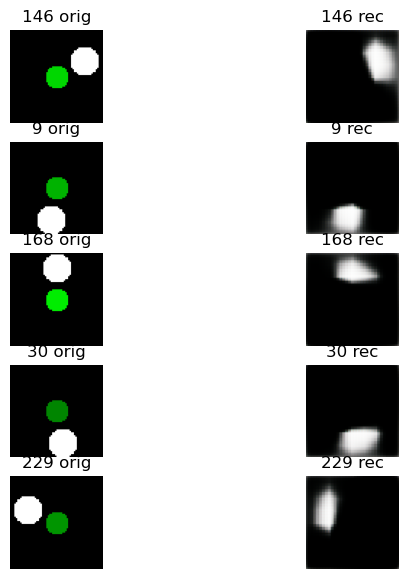

====> AE Epoch: 6 Train loss: 0.031804
====> AE Epoch: 6 Test loss: 0.029144
====> AE Epoch: 7 Train loss: 0.029459
====> AE Epoch: 7 Test loss: 0.032696
====> AE Epoch: 8 Train loss: 0.027934
====> AE Epoch: 8 Test loss: 0.024551
====> AE Epoch: 9 Train loss: 0.028556
====> AE Epoch: 9 Test loss: 0.033449
====> AE Epoch: 10 Train loss: 0.027262
====> AE Epoch: 10 Test loss: 0.054468


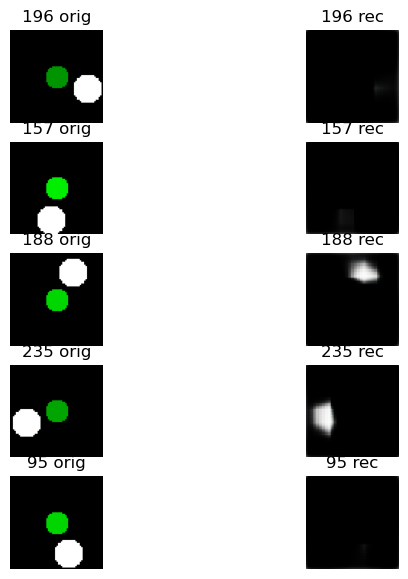

====> AE Epoch: 11 Train loss: 0.027033
====> AE Epoch: 11 Test loss: 0.056181
====> AE Epoch: 12 Train loss: 0.026242
====> AE Epoch: 12 Test loss: 0.021103
====> AE Epoch: 13 Train loss: 0.024375
====> AE Epoch: 13 Test loss: 0.021071
====> AE Epoch: 14 Train loss: 0.023372
====> AE Epoch: 14 Test loss: 0.020700
====> AE Epoch: 15 Train loss: 0.024822
====> AE Epoch: 15 Test loss: 0.021300


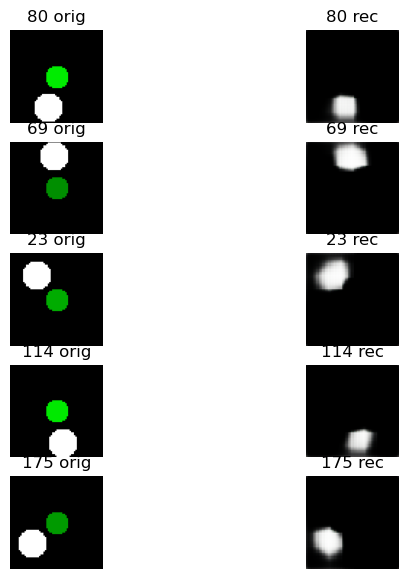

====> AE Epoch: 16 Train loss: 0.023953
====> AE Epoch: 16 Test loss: 0.020352
====> AE Epoch: 17 Train loss: 0.022782
====> AE Epoch: 17 Test loss: 0.022683
====> AE Epoch: 18 Train loss: 0.022404
====> AE Epoch: 18 Test loss: 0.022103
====> AE Epoch: 19 Train loss: 0.022443
====> AE Epoch: 19 Test loss: 0.021221
====> AE Epoch: 20 Train loss: 0.023080
====> AE Epoch: 20 Test loss: 0.030489


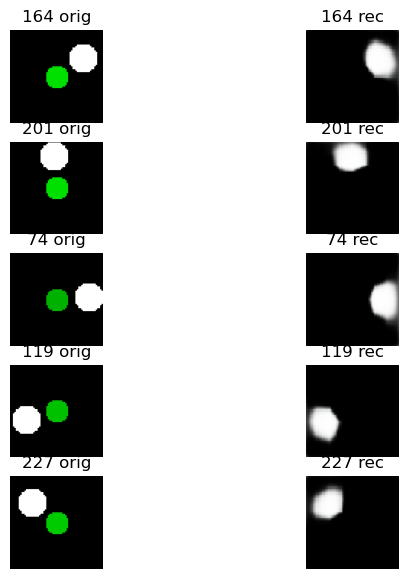

====> AE Epoch: 21 Train loss: 0.022518
====> AE Epoch: 21 Test loss: 0.022605
====> AE Epoch: 22 Train loss: 0.022865
====> AE Epoch: 22 Test loss: 0.020042
====> AE Epoch: 23 Train loss: 0.020479
====> AE Epoch: 23 Test loss: 0.017228
====> AE Epoch: 24 Train loss: 0.021689
====> AE Epoch: 24 Test loss: 0.017541
====> AE Epoch: 25 Train loss: 0.021383
====> AE Epoch: 25 Test loss: 0.018295


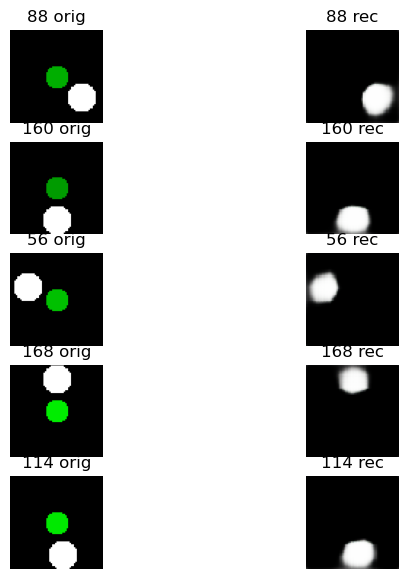

====> AE Epoch: 26 Train loss: 0.021193
====> AE Epoch: 26 Test loss: 0.017142
====> AE Epoch: 27 Train loss: 0.019958
====> AE Epoch: 27 Test loss: 0.019116
====> AE Epoch: 28 Train loss: 0.020664
====> AE Epoch: 28 Test loss: 0.016293
====> AE Epoch: 29 Train loss: 0.020510
====> AE Epoch: 29 Test loss: 0.016120
====> AE Epoch: 30 Train loss: 0.019559
====> AE Epoch: 30 Test loss: 0.016467


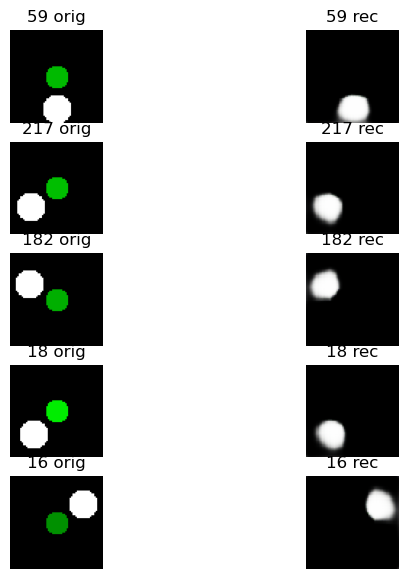

====> AE Epoch: 31 Train loss: 0.019446
====> AE Epoch: 31 Test loss: 0.015321
====> AE Epoch: 32 Train loss: 0.019367
====> AE Epoch: 32 Test loss: 0.015613
====> AE Epoch: 33 Train loss: 0.019782
====> AE Epoch: 33 Test loss: 0.018471
====> AE Epoch: 34 Train loss: 0.019448
====> AE Epoch: 34 Test loss: 0.017305
====> AE Epoch: 35 Train loss: 0.019200
====> AE Epoch: 35 Test loss: 0.016548


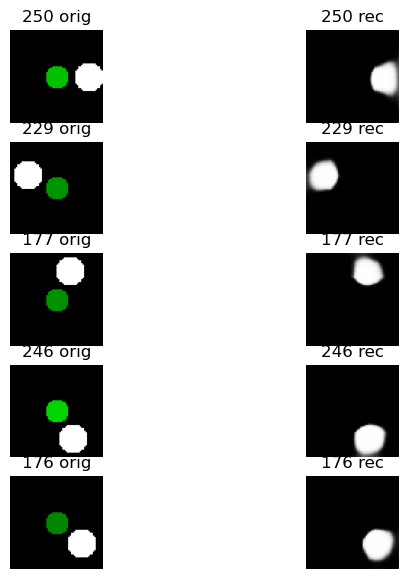

====> AE Epoch: 36 Train loss: 0.018632
====> AE Epoch: 36 Test loss: 0.017089
====> AE Epoch: 37 Train loss: 0.019048
====> AE Epoch: 37 Test loss: 0.015520
====> AE Epoch: 38 Train loss: 0.019411
====> AE Epoch: 38 Test loss: 0.017196
====> AE Epoch: 39 Train loss: 0.019000
====> AE Epoch: 39 Test loss: 0.024261
====> AE Epoch: 40 Train loss: 0.018083
====> AE Epoch: 40 Test loss: 0.015223


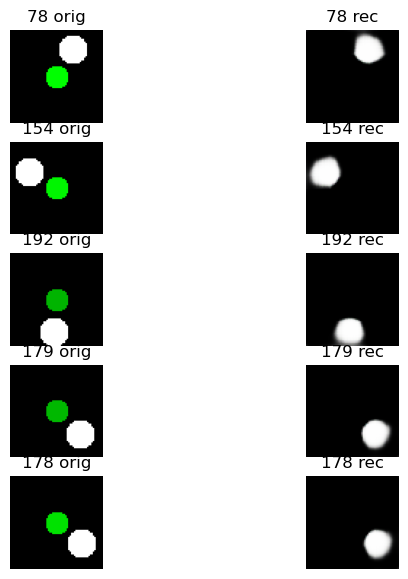

====> AE Epoch: 41 Train loss: 0.019846
====> AE Epoch: 41 Test loss: 0.018655
====> AE Epoch: 42 Train loss: 0.018495
====> AE Epoch: 42 Test loss: 0.015126
====> AE Epoch: 43 Train loss: 0.019102
====> AE Epoch: 43 Test loss: 0.016781
====> AE Epoch: 44 Train loss: 0.018966
====> AE Epoch: 44 Test loss: 0.017046
====> AE Epoch: 45 Train loss: 0.018385
====> AE Epoch: 45 Test loss: 0.015624


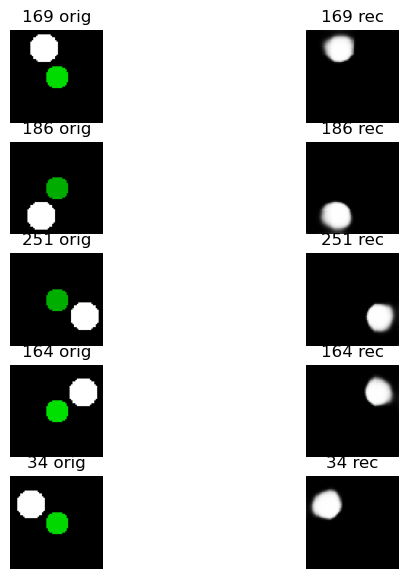

====> AE Epoch: 46 Train loss: 0.018173
====> AE Epoch: 46 Test loss: 0.035844
====> AE Epoch: 47 Train loss: 0.018948
====> AE Epoch: 47 Test loss: 0.014801
====> AE Epoch: 48 Train loss: 0.018940
====> AE Epoch: 48 Test loss: 0.017474
====> AE Epoch: 49 Train loss: 0.019101
====> AE Epoch: 49 Test loss: 0.015088
====> AE Epoch: 50 Train loss: 0.017768
====> AE Epoch: 50 Test loss: 0.014563


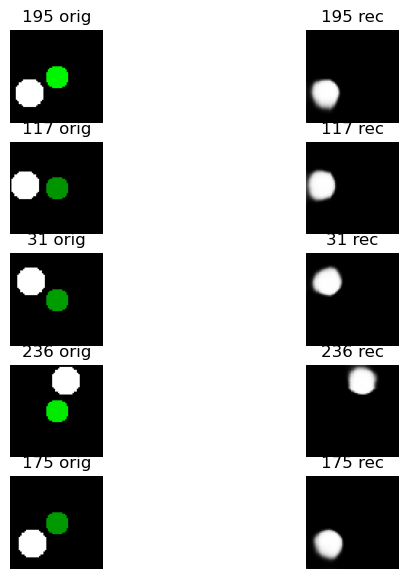

====> AE Epoch: 51 Train loss: 0.016785
====> AE Epoch: 51 Test loss: 0.018197
====> AE Epoch: 52 Train loss: 0.017589
====> AE Epoch: 52 Test loss: 0.016445
====> AE Epoch: 53 Train loss: 0.018805
====> AE Epoch: 53 Test loss: 0.017351
====> AE Epoch: 54 Train loss: 0.017588
====> AE Epoch: 54 Test loss: 0.015245
====> AE Epoch: 55 Train loss: 0.017998
====> AE Epoch: 55 Test loss: 0.049251


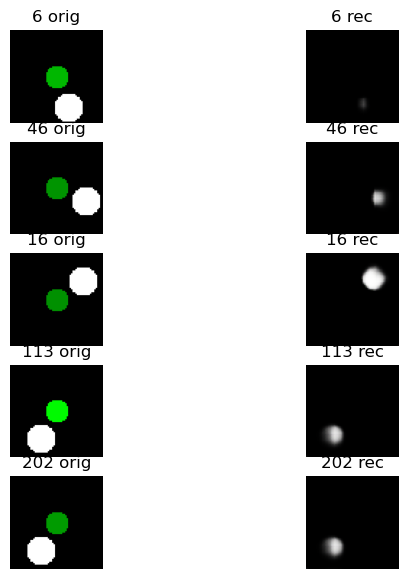

====> AE Epoch: 56 Train loss: 0.018050
====> AE Epoch: 56 Test loss: 0.018285
====> AE Epoch: 57 Train loss: 0.017443
====> AE Epoch: 57 Test loss: 0.014822
====> AE Epoch: 58 Train loss: 0.017200
====> AE Epoch: 58 Test loss: 0.026815
====> AE Epoch: 59 Train loss: 0.017151
====> AE Epoch: 59 Test loss: 0.019588
====> AE Epoch: 60 Train loss: 0.017791
====> AE Epoch: 60 Test loss: 0.014475


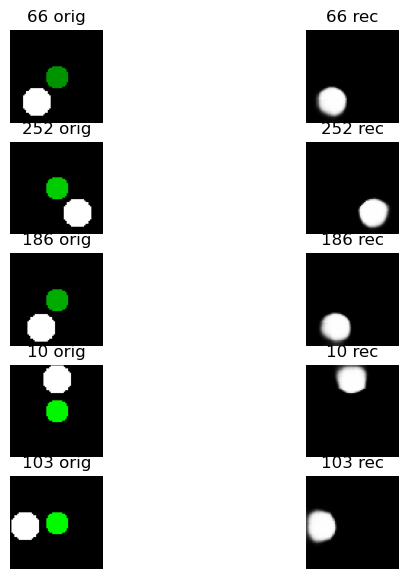

====> AE Epoch: 61 Train loss: 0.017286
====> AE Epoch: 61 Test loss: 0.014289
====> AE Epoch: 62 Train loss: 0.018241
====> AE Epoch: 62 Test loss: 0.014105
====> AE Epoch: 63 Train loss: 0.018030
====> AE Epoch: 63 Test loss: 0.017784
====> AE Epoch: 64 Train loss: 0.018283
====> AE Epoch: 64 Test loss: 0.014638
====> AE Epoch: 65 Train loss: 0.016593
====> AE Epoch: 65 Test loss: 0.015118


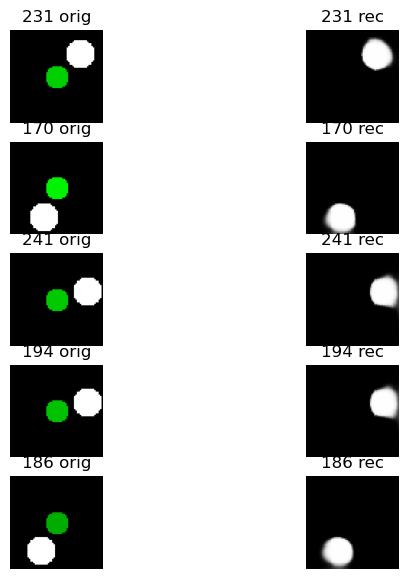

====> AE Epoch: 66 Train loss: 0.016642
====> AE Epoch: 66 Test loss: 0.015130
====> AE Epoch: 67 Train loss: 0.017318
====> AE Epoch: 67 Test loss: 0.016624
====> AE Epoch: 68 Train loss: 0.017469
====> AE Epoch: 68 Test loss: 0.020532
====> AE Epoch: 69 Train loss: 0.017489
====> AE Epoch: 69 Test loss: 0.017355
====> AE Epoch: 70 Train loss: 0.018142
====> AE Epoch: 70 Test loss: 0.016586


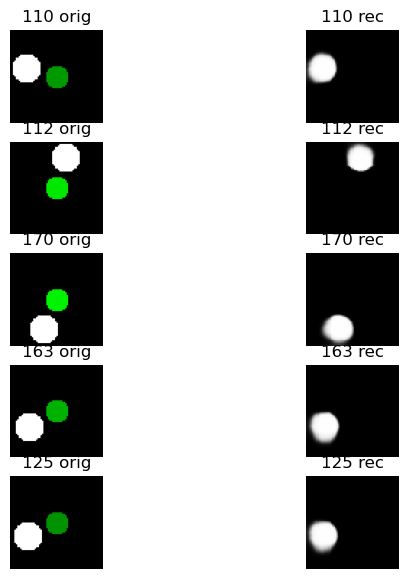

====> AE Epoch: 71 Train loss: 0.017391
====> AE Epoch: 71 Test loss: 0.019649
====> AE Epoch: 72 Train loss: 0.018183
====> AE Epoch: 72 Test loss: 0.024215
====> AE Epoch: 73 Train loss: 0.016789
====> AE Epoch: 73 Test loss: 0.015377
====> AE Epoch: 74 Train loss: 0.016904
====> AE Epoch: 74 Test loss: 0.015328
====> AE Epoch: 75 Train loss: 0.017649
====> AE Epoch: 75 Test loss: 0.020578


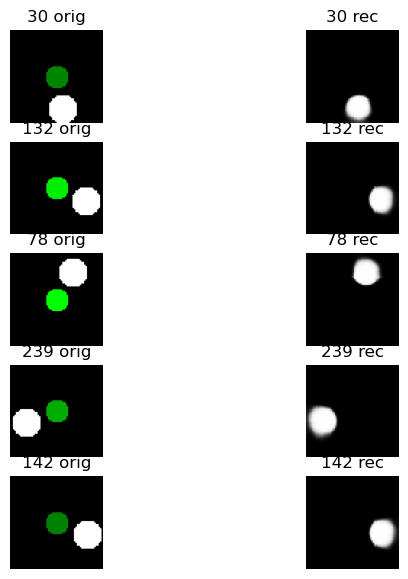

====> AE Epoch: 76 Train loss: 0.017027
====> AE Epoch: 76 Test loss: 0.014053
====> AE Epoch: 77 Train loss: 0.017155
====> AE Epoch: 77 Test loss: 0.015849
====> AE Epoch: 78 Train loss: 0.016555
====> AE Epoch: 78 Test loss: 0.014100
====> AE Epoch: 79 Train loss: 0.016885
====> AE Epoch: 79 Test loss: 0.016577
====> AE Epoch: 80 Train loss: 0.017795
====> AE Epoch: 80 Test loss: 0.016658


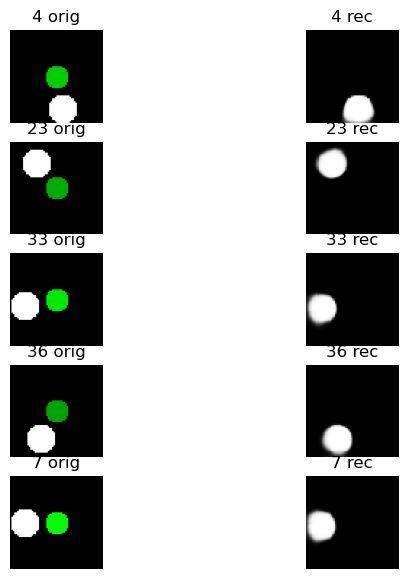

====> AE Epoch: 81 Train loss: 0.017466
====> AE Epoch: 81 Test loss: 0.016281
====> AE Epoch: 82 Train loss: 0.017013
====> AE Epoch: 82 Test loss: 0.013675
====> AE Epoch: 83 Train loss: 0.016894
====> AE Epoch: 83 Test loss: 0.013830
====> AE Epoch: 84 Train loss: 0.017303
====> AE Epoch: 84 Test loss: 0.014894
====> AE Epoch: 85 Train loss: 0.017164
====> AE Epoch: 85 Test loss: 0.013751


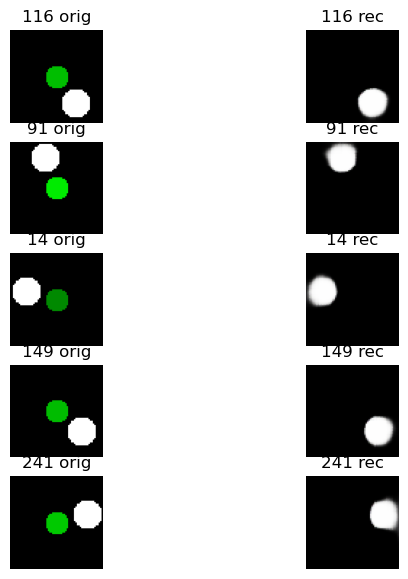

====> AE Epoch: 86 Train loss: 0.017145
====> AE Epoch: 86 Test loss: 0.014484
====> AE Epoch: 87 Train loss: 0.016899
====> AE Epoch: 87 Test loss: 0.014120
====> AE Epoch: 88 Train loss: 0.016819
====> AE Epoch: 88 Test loss: 0.014140
====> AE Epoch: 89 Train loss: 0.016551
====> AE Epoch: 89 Test loss: 0.016796
====> AE Epoch: 90 Train loss: 0.017444
====> AE Epoch: 90 Test loss: 0.013535


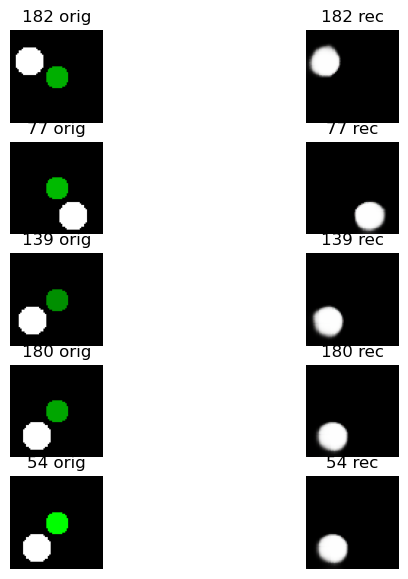

====> AE Epoch: 91 Train loss: 0.016716
====> AE Epoch: 91 Test loss: 0.014674
====> AE Epoch: 92 Train loss: 0.017046
====> AE Epoch: 92 Test loss: 0.017120
====> AE Epoch: 93 Train loss: 0.016711
====> AE Epoch: 93 Test loss: 0.013111
====> AE Epoch: 94 Train loss: 0.017646
====> AE Epoch: 94 Test loss: 0.014178
====> AE Epoch: 95 Train loss: 0.016372
====> AE Epoch: 95 Test loss: 0.016755


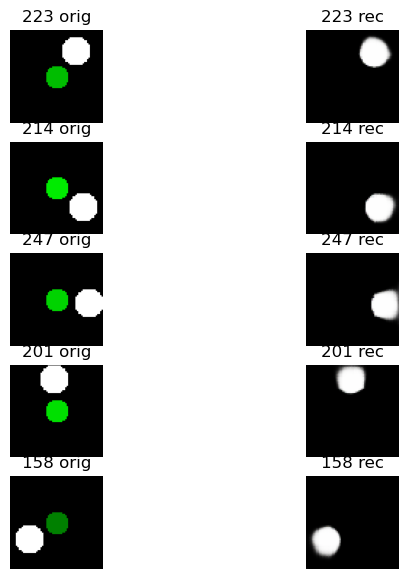

====> AE Epoch: 96 Train loss: 0.016226
====> AE Epoch: 96 Test loss: 0.013664
====> AE Epoch: 97 Train loss: 0.016763
====> AE Epoch: 97 Test loss: 0.013006
====> AE Epoch: 98 Train loss: 0.016861
====> AE Epoch: 98 Test loss: 0.017259
====> AE Epoch: 99 Train loss: 0.016742
====> AE Epoch: 99 Test loss: 0.029990
====> AE Epoch: 100 Train loss: 0.017445
====> AE Epoch: 100 Test loss: 0.018930


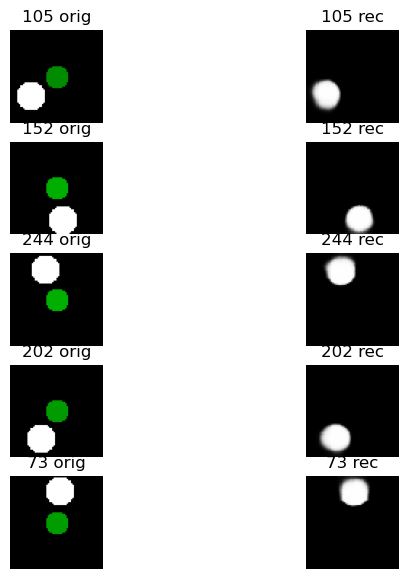

In [18]:
simple_AE_path = './models/simple_AE/'
if os.path.exists(simple_AE_path) is False:
    os.makedirs(simple_AE_path)
model_path_list = sorted(glob(f'{simple_AE_path}simple_AE*'), key=len)

if len(model_path_list) != 0:
    print('A trained model is found')
    is_training = False
    weightname = model_path_list[-1]

if is_training:
    print("Training simple AE")
    weightname = f'{simple_AE_path}simple_AE'
    for epoch in range(1, num_epoch + 1):
        train_AE(simple_AE_E, simple_AE_D, simple_AE_optim, epoch, train_loader, device)
        torch.save( {'simple_AE_E_state_dict': simple_AE_E.state_dict(),
                     'simple_AE_D_state_dict': simple_AE_D.state_dict(),
                     'simple_AE_optim_state_dict': simple_AE_optim.state_dict(),}, 
                    weightname)  

else:
    print(f"Load the model: {weightname}")
    checkpoint_simple_AE = torch.load(weightname, device)
    simple_AE_E.load_state_dict(checkpoint_simple_AE['simple_AE_E_state_dict'])
    simple_AE_D.load_state_dict(checkpoint_simple_AE['simple_AE_D_state_dict'])

PCA-AE trainner

In [19]:
def train_PCAAE(PCAAE_E, PCAAE_D, optimizer, epoch, step, device, train_loader, test_loader, 
                lambda_rec=1, lambda_dep=1, basic_loss=True):
    train_loss = 0.    
    train_rec_loss = 0.
    train_dep_loss = 0.
       
    test_loss = 0.
    test_rec_loss = 0.
    test_dep_loss = 0.       
    
    # Training part:
    for idx_step in range(1,step+1):
        PCAAE_E[idx_step-1].train()
    PCAAE_D[step-1].train()
    
    for id_step in range(1,step):
        for param in PCAAE_E[id_step-1].parameters():
            param.required_grad = False
            
    for batch_idx, (data) in enumerate(train_loader):
        data = data.to(device)
        
        z = []
        with torch.no_grad():
            for jd in range(step-1):
                z.append(PCAAE_E[jd](data))
        z_i = PCAAE_E[step-1](data)
        z.append(z_i)     
        
        latent_code = torch.cat(z, dim=-1)
        data_rec = PCAAE_D[step-1](latent_code)
        
        loss_rec = lambda_rec * reconstruction_loss(data_rec, data, MSE=True)
        if basic_loss:
            dependency_loss = covariance_loss(latent_code, step)
        else:
            dependency_loss = dcor_loss(latent_code, step, device)
        loss_dep = lambda_dep * dependency_loss
        loss = loss_rec + loss_dep
        
        optimizer[step-1].zero_grad()
        loss.backward()
        train_loss += loss.item()
        train_rec_loss += loss_rec.item()
        if step>1:
            train_dep_loss +=  loss_dep.item()
        optimizer[step-1].step()
    
    # Testing part:
    for idx_step in range(1,step+1):
        PCAAE_E[idx_step-1].eval()
    PCAAE_D[step-1].eval()
    
    for batch_idx, (data) in enumerate(test_loader):
        data = data.to(device)
        with torch.no_grad():
            z = []
            for jx in range(step):
                z.append(PCAAE_E[jx](data))   
            latent_code = torch.cat(z,dim=-1)
            data_rec = PCAAE_D[step-1](latent_code)            
            loss_rec = lambda_rec * reconstruction_loss(data_rec, data, MSE=True)
            if basic_loss:
                dependency_loss = covariance_loss(latent_code, step)
            else:
                dependency_loss = dcor_loss(latent_code, step, device)
            loss_dep = lambda_dep * dependency_loss
            test_loss += loss_rec + loss_dep
            test_rec_loss += loss_rec
            if step>1:
                test_dep_loss += loss_dep

                
    print(f"====> PCAAE{step} Epoch: {epoch} Train loss: {train_loss * batchsize / len(train_dataset):.6f},\t Train Rec loss: {train_rec_loss * batchsize / len(train_dataset):.6f},\t Train Dep loss: {train_dep_loss * batchsize / len(train_dataset):.6f}")
    
    print(f"====> PCAAE{step} Epoch: {epoch} Test loss: {test_loss * batchsize / len(test_dataset):.6f},\t Test Rec loss: {test_rec_loss * batchsize / len(test_dataset):.6f},\t Test Dep loss: {test_dep_loss * batchsize / len(test_dataset):.6f}")
    
    
    if epoch % 5 == 0:
        choice = np.random.choice(np.arange(len(data), dtype=int), size=5, replace=False)

        fig, axes = plt.subplots(5, 2, figsize=(7, 7))
        for num, i in enumerate(choice):
            img, img_rec = data[i], data_rec[i]
            img, img_rec = torch.squeeze(img.detach(), axis=0), torch.squeeze(img_rec.detach(), axis=0)
            img, img_rec = img.permute(1,2,0), img_rec.permute(1,2,0)
            img, img_rec = img.cpu().numpy(), img_rec.cpu().numpy()
            axes[num, 0].imshow(img)
            axes[num, 0].title.set_text(f"{i} orig")
            axes[num, 0].axis('off')
            axes[num, 1].imshow(img_rec)
            axes[num, 1].title.set_text(f"{i} rec")
            axes[num, 1].axis('off')
        plt.show()

basic PCA-AE

In [20]:
basic_PCAAE_E = []
basic_PCAAE_D = []
for id_m in range(train_latent):  
    basic_PCAAE_E_i = Encoder(code_size=1, channel=channel).to(device)
    basic_PCAAE_D_i = Decoder(code_size=id_m+1, channel=channel).to(device)
    basic_PCAAE_E_i.apply(init_weights)
    basic_PCAAE_D_i.apply(init_weights)
    basic_PCAAE_E.append(basic_PCAAE_E_i)
    basic_PCAAE_D.append(basic_PCAAE_D_i)

basic_PCAAE_optim = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(basic_PCAAE_E[id_m].parameters(), 
                                            basic_PCAAE_D[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    basic_PCAAE_optim.append(optim_temp)

Training basic PCAAE 

====> PCAAE1 Epoch: 1 Train loss: 0.200037,	 Train Rec loss: 0.200037,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 1 Test loss: 0.100935,	 Test Rec loss: 0.100935,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 2 Train loss: 0.088860,	 Train Rec loss: 0.088860,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 2 Test loss: 0.087399,	 Test Rec loss: 0.087399,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 3 Train loss: 0.082731,	 Train Rec loss: 0.082731,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 3 Test loss: 0.109462,	 Test Rec loss: 0.109462,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 4 Train loss: 0.075773,	 Train Rec loss: 0.075773,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 4 Test loss: 0.074673,	 Test Rec loss: 0.074673,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 5 Train loss: 0.073494,	 Train Rec loss: 0.073494,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 5 Test loss: 0.073279,	 Test Rec loss: 0.073279,	 Test Dep loss: 0.000000


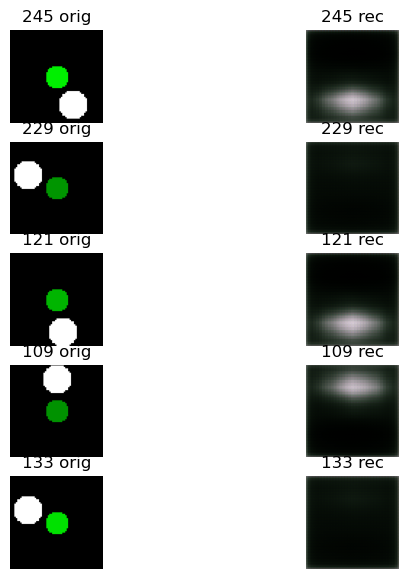

====> PCAAE1 Epoch: 6 Train loss: 0.072270,	 Train Rec loss: 0.072270,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 6 Test loss: 0.071556,	 Test Rec loss: 0.071556,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 7 Train loss: 0.071209,	 Train Rec loss: 0.071209,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 7 Test loss: 0.070444,	 Test Rec loss: 0.070444,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 8 Train loss: 0.070285,	 Train Rec loss: 0.070285,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 8 Test loss: 0.069611,	 Test Rec loss: 0.069611,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 9 Train loss: 0.069501,	 Train Rec loss: 0.069501,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 9 Test loss: 0.068768,	 Test Rec loss: 0.068768,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 10 Train loss: 0.068516,	 Train Rec loss: 0.068516,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 10 Test loss: 0.067701,	 Test Rec loss: 0.067701,	 Test Dep loss: 0.000000


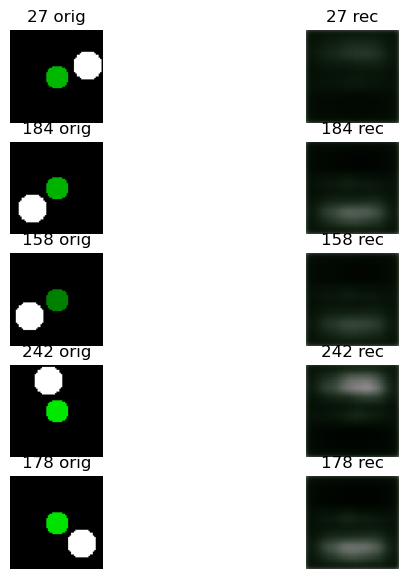

====> PCAAE1 Epoch: 11 Train loss: 0.067443,	 Train Rec loss: 0.067443,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 11 Test loss: 0.066696,	 Test Rec loss: 0.066696,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 12 Train loss: 0.066509,	 Train Rec loss: 0.066509,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 12 Test loss: 0.065870,	 Test Rec loss: 0.065870,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 13 Train loss: 0.065730,	 Train Rec loss: 0.065730,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 13 Test loss: 0.065231,	 Test Rec loss: 0.065231,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 14 Train loss: 0.064858,	 Train Rec loss: 0.064858,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 14 Test loss: 0.064223,	 Test Rec loss: 0.064223,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 15 Train loss: 0.063889,	 Train Rec loss: 0.063889,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 15 Test loss: 0.063197,	 Test Rec loss: 0.063197,	 Test Dep loss: 0.000000


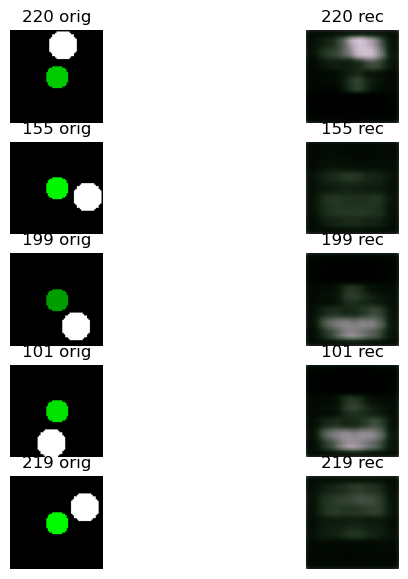

====> PCAAE1 Epoch: 16 Train loss: 0.062525,	 Train Rec loss: 0.062525,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 16 Test loss: 0.061531,	 Test Rec loss: 0.061531,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 17 Train loss: 0.060459,	 Train Rec loss: 0.060459,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 17 Test loss: 0.058950,	 Test Rec loss: 0.058950,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 18 Train loss: 0.057620,	 Train Rec loss: 0.057620,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 18 Test loss: 0.056326,	 Test Rec loss: 0.056326,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 19 Train loss: 0.055786,	 Train Rec loss: 0.055786,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 19 Test loss: 0.054845,	 Test Rec loss: 0.054845,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 20 Train loss: 0.054516,	 Train Rec loss: 0.054516,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 20 Test loss: 0.053974,	 Test Rec loss: 0.053974,	 Test Dep loss: 0.000000


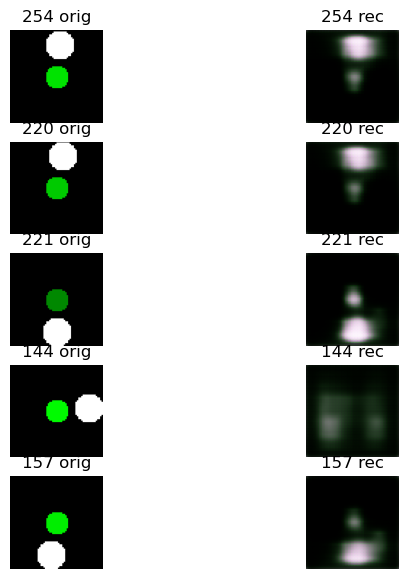

====> PCAAE1 Epoch: 21 Train loss: 0.053582,	 Train Rec loss: 0.053582,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 21 Test loss: 0.053306,	 Test Rec loss: 0.053306,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 22 Train loss: 0.052577,	 Train Rec loss: 0.052577,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 22 Test loss: 0.051334,	 Test Rec loss: 0.051334,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 23 Train loss: 0.050843,	 Train Rec loss: 0.050843,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 23 Test loss: 0.049721,	 Test Rec loss: 0.049721,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 24 Train loss: 0.049394,	 Train Rec loss: 0.049394,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 24 Test loss: 0.048460,	 Test Rec loss: 0.048460,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 25 Train loss: 0.048149,	 Train Rec loss: 0.048149,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 25 Test loss: 0.048312,	 Test Rec loss: 0.048312,	 Test Dep loss: 0.000000


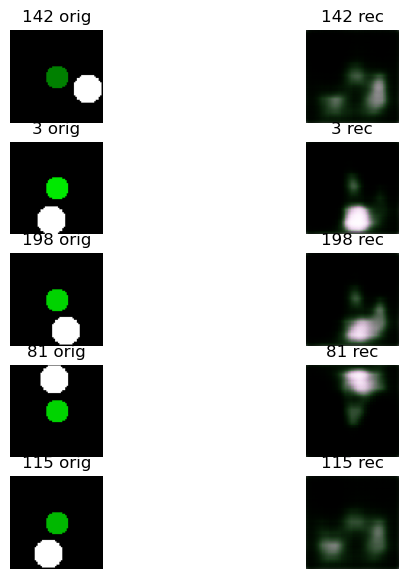

====> PCAAE1 Epoch: 26 Train loss: 0.046783,	 Train Rec loss: 0.046783,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 26 Test loss: 0.046093,	 Test Rec loss: 0.046093,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 27 Train loss: 0.045791,	 Train Rec loss: 0.045791,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 27 Test loss: 0.043524,	 Test Rec loss: 0.043524,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 28 Train loss: 0.044570,	 Train Rec loss: 0.044570,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 28 Test loss: 0.045280,	 Test Rec loss: 0.045280,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 29 Train loss: 0.044767,	 Train Rec loss: 0.044767,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 29 Test loss: 0.042123,	 Test Rec loss: 0.042123,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 30 Train loss: 0.042698,	 Train Rec loss: 0.042698,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 30 Test loss: 0.040326,	 Test Rec loss: 0.040326,	 Test Dep loss: 0.000000


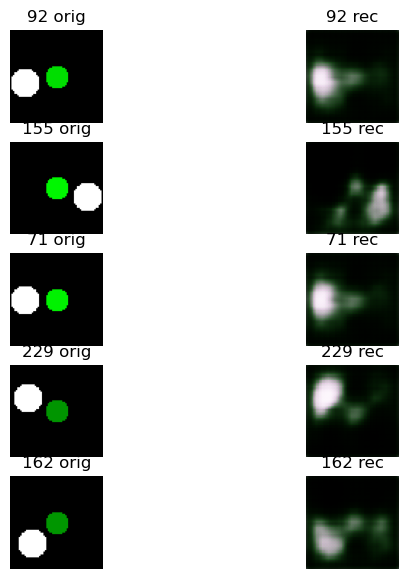

====> PCAAE1 Epoch: 31 Train loss: 0.041994,	 Train Rec loss: 0.041994,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 31 Test loss: 0.038994,	 Test Rec loss: 0.038994,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 32 Train loss: 0.041946,	 Train Rec loss: 0.041946,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 32 Test loss: 0.038460,	 Test Rec loss: 0.038460,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 33 Train loss: 0.040160,	 Train Rec loss: 0.040160,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 33 Test loss: 0.038732,	 Test Rec loss: 0.038732,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 34 Train loss: 0.041245,	 Train Rec loss: 0.041245,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 34 Test loss: 0.037523,	 Test Rec loss: 0.037523,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 35 Train loss: 0.038970,	 Train Rec loss: 0.038970,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 35 Test loss: 0.041241,	 Test Rec loss: 0.041241,	 Test Dep loss: 0.000000


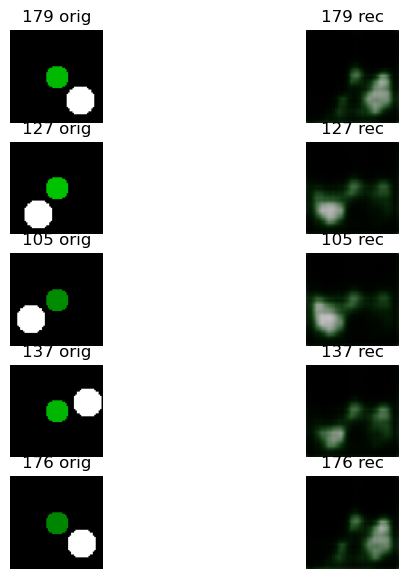

====> PCAAE1 Epoch: 36 Train loss: 0.039028,	 Train Rec loss: 0.039028,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 36 Test loss: 0.037787,	 Test Rec loss: 0.037787,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 37 Train loss: 0.037609,	 Train Rec loss: 0.037609,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 37 Test loss: 0.034881,	 Test Rec loss: 0.034881,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 38 Train loss: 0.038100,	 Train Rec loss: 0.038100,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 38 Test loss: 0.034386,	 Test Rec loss: 0.034386,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 39 Train loss: 0.037868,	 Train Rec loss: 0.037868,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 39 Test loss: 0.034755,	 Test Rec loss: 0.034755,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 40 Train loss: 0.037982,	 Train Rec loss: 0.037982,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 40 Test loss: 0.035864,	 Test Rec loss: 0.035864,	 Test Dep loss: 0.000000


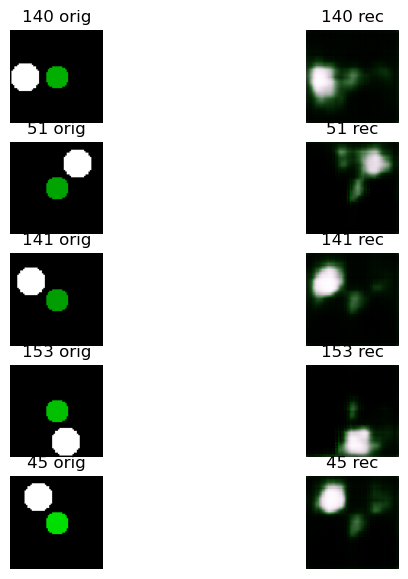

====> PCAAE1 Epoch: 41 Train loss: 0.035876,	 Train Rec loss: 0.035876,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 41 Test loss: 0.034067,	 Test Rec loss: 0.034067,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 42 Train loss: 0.035506,	 Train Rec loss: 0.035506,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 42 Test loss: 0.033884,	 Test Rec loss: 0.033884,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 43 Train loss: 0.036434,	 Train Rec loss: 0.036434,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 43 Test loss: 0.031833,	 Test Rec loss: 0.031833,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 44 Train loss: 0.035205,	 Train Rec loss: 0.035205,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 44 Test loss: 0.031710,	 Test Rec loss: 0.031710,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 45 Train loss: 0.035021,	 Train Rec loss: 0.035021,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 45 Test loss: 0.031188,	 Test Rec loss: 0.031188,	 Test Dep loss: 0.000000


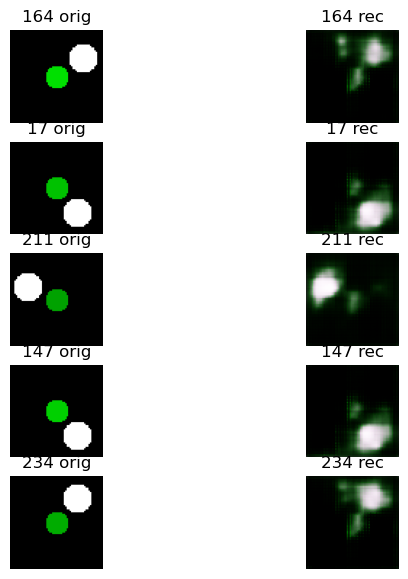

====> PCAAE1 Epoch: 46 Train loss: 0.034972,	 Train Rec loss: 0.034972,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 46 Test loss: 0.030549,	 Test Rec loss: 0.030549,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 47 Train loss: 0.034923,	 Train Rec loss: 0.034923,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 47 Test loss: 0.030434,	 Test Rec loss: 0.030434,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 48 Train loss: 0.035194,	 Train Rec loss: 0.035194,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 48 Test loss: 0.030421,	 Test Rec loss: 0.030421,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 49 Train loss: 0.034219,	 Train Rec loss: 0.034219,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 49 Test loss: 0.031282,	 Test Rec loss: 0.031282,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 50 Train loss: 0.035349,	 Train Rec loss: 0.035349,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 50 Test loss: 0.030000,	 Test Rec loss: 0.030000,	 Test Dep loss: 0.000000


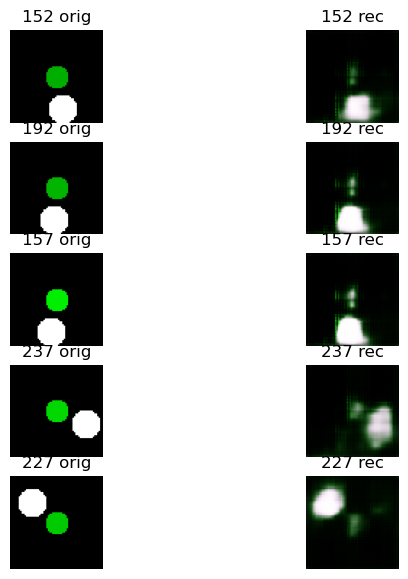

====> PCAAE1 Epoch: 51 Train loss: 0.035991,	 Train Rec loss: 0.035991,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 51 Test loss: 0.034498,	 Test Rec loss: 0.034498,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 52 Train loss: 0.035928,	 Train Rec loss: 0.035928,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 52 Test loss: 0.029638,	 Test Rec loss: 0.029638,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 53 Train loss: 0.032834,	 Train Rec loss: 0.032834,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 53 Test loss: 0.029229,	 Test Rec loss: 0.029229,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 54 Train loss: 0.034079,	 Train Rec loss: 0.034079,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 54 Test loss: 0.029797,	 Test Rec loss: 0.029797,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 55 Train loss: 0.035408,	 Train Rec loss: 0.035408,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 55 Test loss: 0.029503,	 Test Rec loss: 0.029503,	 Test Dep loss: 0.000000


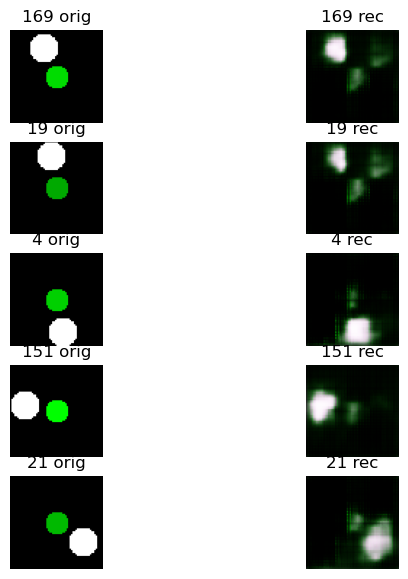

====> PCAAE1 Epoch: 56 Train loss: 0.034082,	 Train Rec loss: 0.034082,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 56 Test loss: 0.030776,	 Test Rec loss: 0.030776,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 57 Train loss: 0.033311,	 Train Rec loss: 0.033311,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 57 Test loss: 0.029707,	 Test Rec loss: 0.029707,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 58 Train loss: 0.035145,	 Train Rec loss: 0.035145,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 58 Test loss: 0.030605,	 Test Rec loss: 0.030605,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 59 Train loss: 0.034603,	 Train Rec loss: 0.034603,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 59 Test loss: 0.031289,	 Test Rec loss: 0.031289,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 60 Train loss: 0.034995,	 Train Rec loss: 0.034995,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 60 Test loss: 0.029187,	 Test Rec loss: 0.029187,	 Test Dep loss: 0.000000


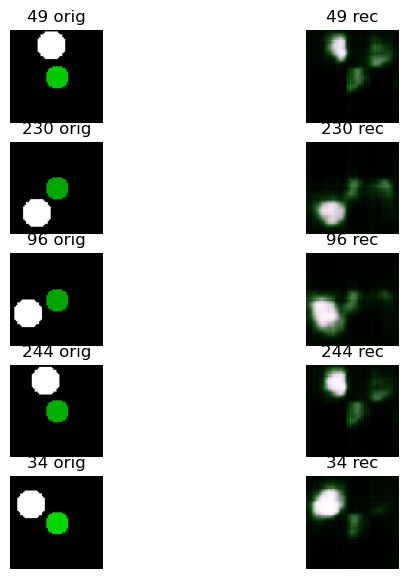

====> PCAAE1 Epoch: 61 Train loss: 0.033117,	 Train Rec loss: 0.033117,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 61 Test loss: 0.029323,	 Test Rec loss: 0.029323,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 62 Train loss: 0.032580,	 Train Rec loss: 0.032580,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 62 Test loss: 0.028382,	 Test Rec loss: 0.028382,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 63 Train loss: 0.034939,	 Train Rec loss: 0.034939,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 63 Test loss: 0.030468,	 Test Rec loss: 0.030468,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 64 Train loss: 0.032196,	 Train Rec loss: 0.032196,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 64 Test loss: 0.028161,	 Test Rec loss: 0.028161,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 65 Train loss: 0.034366,	 Train Rec loss: 0.034366,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 65 Test loss: 0.027721,	 Test Rec loss: 0.027721,	 Test Dep loss: 0.000000


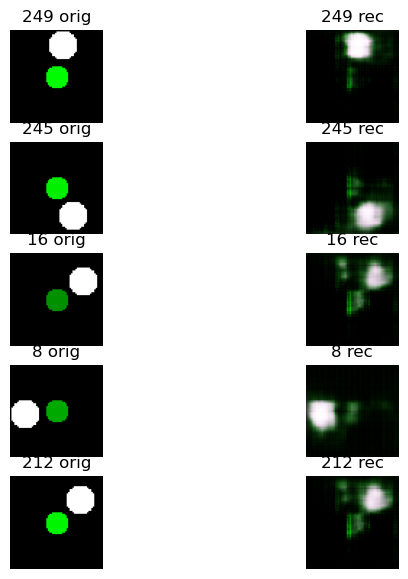

====> PCAAE1 Epoch: 66 Train loss: 0.031342,	 Train Rec loss: 0.031342,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 66 Test loss: 0.027448,	 Test Rec loss: 0.027448,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 67 Train loss: 0.033007,	 Train Rec loss: 0.033007,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 67 Test loss: 0.027199,	 Test Rec loss: 0.027199,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 68 Train loss: 0.031228,	 Train Rec loss: 0.031228,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 68 Test loss: 0.029433,	 Test Rec loss: 0.029433,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 69 Train loss: 0.032714,	 Train Rec loss: 0.032714,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 69 Test loss: 0.027450,	 Test Rec loss: 0.027450,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 70 Train loss: 0.033074,	 Train Rec loss: 0.033074,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 70 Test loss: 0.028181,	 Test Rec loss: 0.028181,	 Test Dep loss: 0.000000


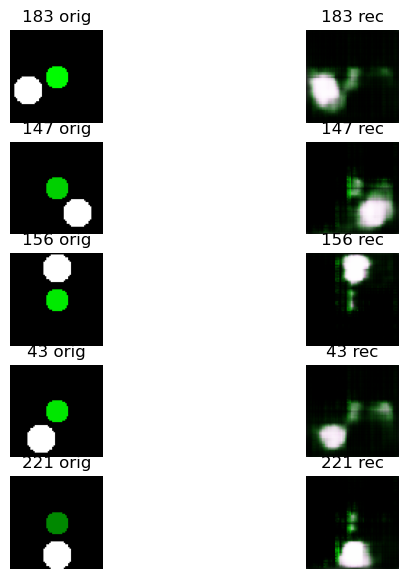

====> PCAAE1 Epoch: 71 Train loss: 0.032041,	 Train Rec loss: 0.032041,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 71 Test loss: 0.026774,	 Test Rec loss: 0.026774,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 72 Train loss: 0.030581,	 Train Rec loss: 0.030581,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 72 Test loss: 0.026387,	 Test Rec loss: 0.026387,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 73 Train loss: 0.032296,	 Train Rec loss: 0.032296,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 73 Test loss: 0.027224,	 Test Rec loss: 0.027224,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 74 Train loss: 0.032397,	 Train Rec loss: 0.032397,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 74 Test loss: 0.026503,	 Test Rec loss: 0.026503,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 75 Train loss: 0.031040,	 Train Rec loss: 0.031040,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 75 Test loss: 0.027588,	 Test Rec loss: 0.027588,	 Test Dep loss: 0.000000


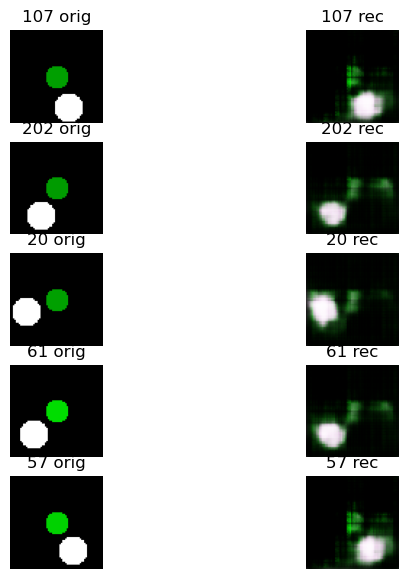

====> PCAAE1 Epoch: 76 Train loss: 0.033422,	 Train Rec loss: 0.033422,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 76 Test loss: 0.026001,	 Test Rec loss: 0.026001,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 77 Train loss: 0.032306,	 Train Rec loss: 0.032306,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 77 Test loss: 0.032084,	 Test Rec loss: 0.032084,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 78 Train loss: 0.031021,	 Train Rec loss: 0.031021,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 78 Test loss: 0.027338,	 Test Rec loss: 0.027338,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 79 Train loss: 0.030363,	 Train Rec loss: 0.030363,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 79 Test loss: 0.025064,	 Test Rec loss: 0.025064,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 80 Train loss: 0.030859,	 Train Rec loss: 0.030859,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 80 Test loss: 0.026211,	 Test Rec loss: 0.026211,	 Test Dep loss: 0.000000


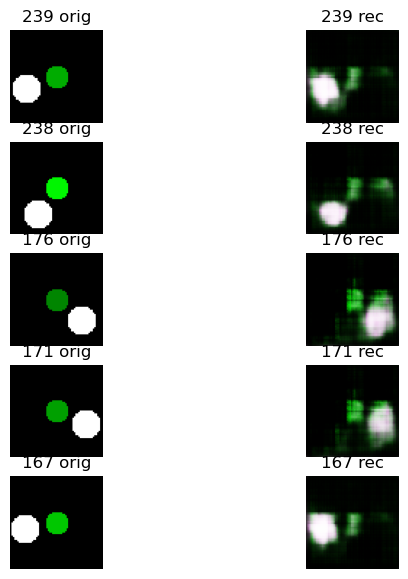

====> PCAAE1 Epoch: 81 Train loss: 0.030246,	 Train Rec loss: 0.030246,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 81 Test loss: 0.024721,	 Test Rec loss: 0.024721,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 82 Train loss: 0.029938,	 Train Rec loss: 0.029938,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 82 Test loss: 0.026561,	 Test Rec loss: 0.026561,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 83 Train loss: 0.031386,	 Train Rec loss: 0.031386,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 83 Test loss: 0.027568,	 Test Rec loss: 0.027568,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 84 Train loss: 0.028509,	 Train Rec loss: 0.028509,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 84 Test loss: 0.023759,	 Test Rec loss: 0.023759,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 85 Train loss: 0.030512,	 Train Rec loss: 0.030512,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 85 Test loss: 0.024235,	 Test Rec loss: 0.024235,	 Test Dep loss: 0.000000


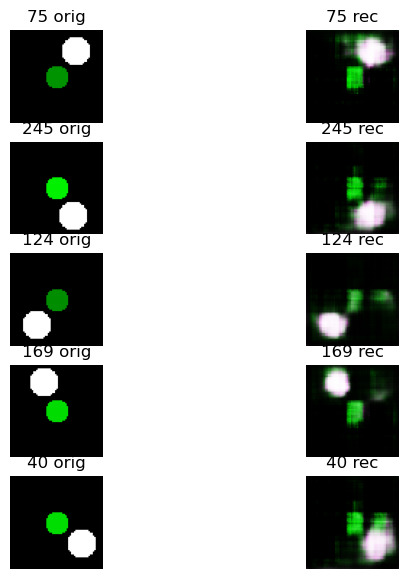

====> PCAAE1 Epoch: 86 Train loss: 0.028819,	 Train Rec loss: 0.028819,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 86 Test loss: 0.023386,	 Test Rec loss: 0.023386,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 87 Train loss: 0.030502,	 Train Rec loss: 0.030502,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 87 Test loss: 0.024551,	 Test Rec loss: 0.024551,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 88 Train loss: 0.027460,	 Train Rec loss: 0.027460,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 88 Test loss: 0.022918,	 Test Rec loss: 0.022918,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 89 Train loss: 0.027027,	 Train Rec loss: 0.027027,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 89 Test loss: 0.023247,	 Test Rec loss: 0.023247,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 90 Train loss: 0.028519,	 Train Rec loss: 0.028519,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 90 Test loss: 0.024127,	 Test Rec loss: 0.024127,	 Test Dep loss: 0.000000


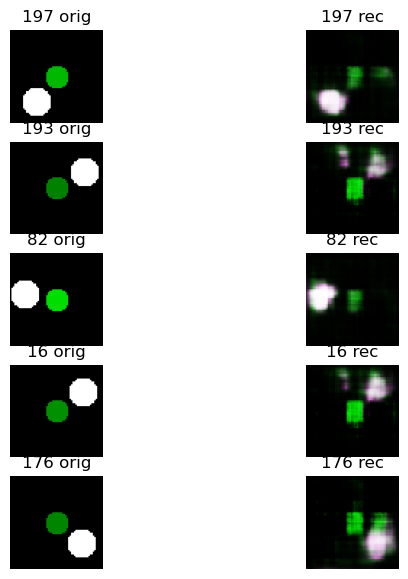

====> PCAAE1 Epoch: 91 Train loss: 0.027682,	 Train Rec loss: 0.027682,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 91 Test loss: 0.021987,	 Test Rec loss: 0.021987,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 92 Train loss: 0.026916,	 Train Rec loss: 0.026916,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 92 Test loss: 0.021559,	 Test Rec loss: 0.021559,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 93 Train loss: 0.028282,	 Train Rec loss: 0.028282,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 93 Test loss: 0.022397,	 Test Rec loss: 0.022397,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 94 Train loss: 0.025705,	 Train Rec loss: 0.025705,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 94 Test loss: 0.021527,	 Test Rec loss: 0.021527,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 95 Train loss: 0.025338,	 Train Rec loss: 0.025338,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 95 Test loss: 0.024851,	 Test Rec loss: 0.024851,	 Test Dep loss: 0.000000


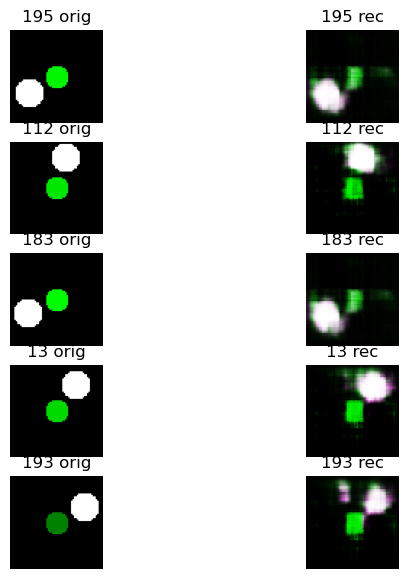

====> PCAAE1 Epoch: 96 Train loss: 0.027678,	 Train Rec loss: 0.027678,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 96 Test loss: 0.021383,	 Test Rec loss: 0.021383,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 97 Train loss: 0.025930,	 Train Rec loss: 0.025930,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 97 Test loss: 0.022461,	 Test Rec loss: 0.022461,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 98 Train loss: 0.026209,	 Train Rec loss: 0.026209,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 98 Test loss: 0.021243,	 Test Rec loss: 0.021243,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 99 Train loss: 0.026161,	 Train Rec loss: 0.026161,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 99 Test loss: 0.021377,	 Test Rec loss: 0.021377,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 100 Train loss: 0.026635,	 Train Rec loss: 0.026635,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 100 Test loss: 0.020442,	 Test Rec loss: 0.020442,	 Test Dep loss: 0.000000


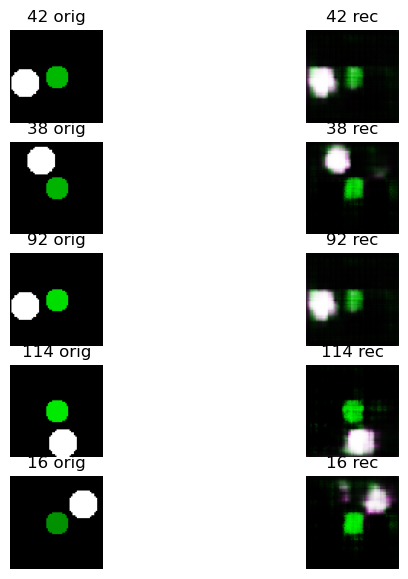

====> PCAAE2 Epoch: 1 Train loss: 0.215610,	 Train Rec loss: 0.163587,	 Train Dep loss: 0.052023
====> PCAAE2 Epoch: 1 Test loss: 0.087905,	 Test Rec loss: 0.087905,	 Test Dep loss: 0.000000
====> PCAAE2 Epoch: 2 Train loss: 0.083763,	 Train Rec loss: 0.080856,	 Train Dep loss: 0.002907
====> PCAAE2 Epoch: 2 Test loss: 0.078412,	 Test Rec loss: 0.078410,	 Test Dep loss: 0.000001
====> PCAAE2 Epoch: 3 Train loss: 0.070410,	 Train Rec loss: 0.066013,	 Train Dep loss: 0.004397
====> PCAAE2 Epoch: 3 Test loss: 0.071950,	 Test Rec loss: 0.071775,	 Test Dep loss: 0.000175
====> PCAAE2 Epoch: 4 Train loss: 0.061297,	 Train Rec loss: 0.058804,	 Train Dep loss: 0.002493
====> PCAAE2 Epoch: 4 Test loss: 0.056260,	 Test Rec loss: 0.055648,	 Test Dep loss: 0.000613
====> PCAAE2 Epoch: 5 Train loss: 0.055955,	 Train Rec loss: 0.052045,	 Train Dep loss: 0.003910
====> PCAAE2 Epoch: 5 Test loss: 0.049489,	 Test Rec loss: 0.048267,	 Test Dep loss: 0.001223


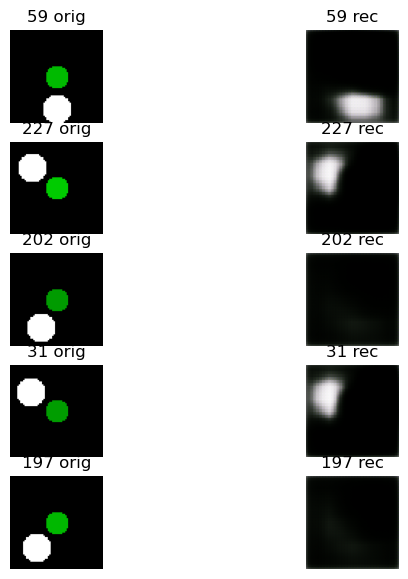

====> PCAAE2 Epoch: 6 Train loss: 0.047628,	 Train Rec loss: 0.043223,	 Train Dep loss: 0.004405
====> PCAAE2 Epoch: 6 Test loss: 0.043531,	 Test Rec loss: 0.037654,	 Test Dep loss: 0.005877
====> PCAAE2 Epoch: 7 Train loss: 0.038398,	 Train Rec loss: 0.035085,	 Train Dep loss: 0.003313
====> PCAAE2 Epoch: 7 Test loss: 0.033348,	 Test Rec loss: 0.031472,	 Test Dep loss: 0.001877
====> PCAAE2 Epoch: 8 Train loss: 0.035018,	 Train Rec loss: 0.032101,	 Train Dep loss: 0.002917
====> PCAAE2 Epoch: 8 Test loss: 0.030865,	 Test Rec loss: 0.028951,	 Test Dep loss: 0.001914
====> PCAAE2 Epoch: 9 Train loss: 0.033193,	 Train Rec loss: 0.030278,	 Train Dep loss: 0.002915
====> PCAAE2 Epoch: 9 Test loss: 0.029228,	 Test Rec loss: 0.026910,	 Test Dep loss: 0.002318
====> PCAAE2 Epoch: 10 Train loss: 0.030830,	 Train Rec loss: 0.028316,	 Train Dep loss: 0.002514
====> PCAAE2 Epoch: 10 Test loss: 0.027330,	 Test Rec loss: 0.025972,	 Test Dep loss: 0.001358


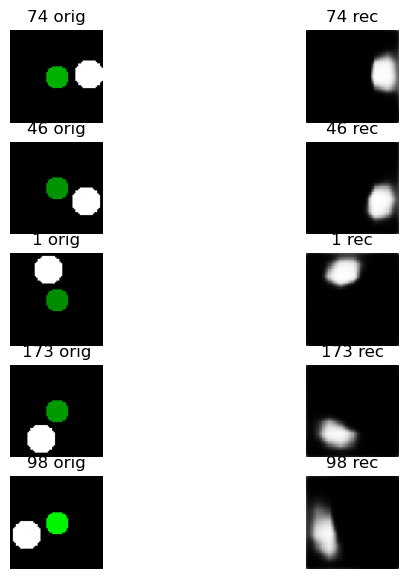

====> PCAAE2 Epoch: 11 Train loss: 0.029434,	 Train Rec loss: 0.027109,	 Train Dep loss: 0.002325
====> PCAAE2 Epoch: 11 Test loss: 0.031072,	 Test Rec loss: 0.025943,	 Test Dep loss: 0.005128
====> PCAAE2 Epoch: 12 Train loss: 0.030733,	 Train Rec loss: 0.026392,	 Train Dep loss: 0.004341
====> PCAAE2 Epoch: 12 Test loss: 0.024520,	 Test Rec loss: 0.023255,	 Test Dep loss: 0.001266
====> PCAAE2 Epoch: 13 Train loss: 0.028693,	 Train Rec loss: 0.026229,	 Train Dep loss: 0.002464
====> PCAAE2 Epoch: 13 Test loss: 0.025995,	 Test Rec loss: 0.023800,	 Test Dep loss: 0.002195
====> PCAAE2 Epoch: 14 Train loss: 0.027271,	 Train Rec loss: 0.024964,	 Train Dep loss: 0.002307
====> PCAAE2 Epoch: 14 Test loss: 0.024093,	 Test Rec loss: 0.022744,	 Test Dep loss: 0.001349
====> PCAAE2 Epoch: 15 Train loss: 0.027309,	 Train Rec loss: 0.024776,	 Train Dep loss: 0.002533
====> PCAAE2 Epoch: 15 Test loss: 0.022911,	 Test Rec loss: 0.021506,	 Test Dep loss: 0.001405


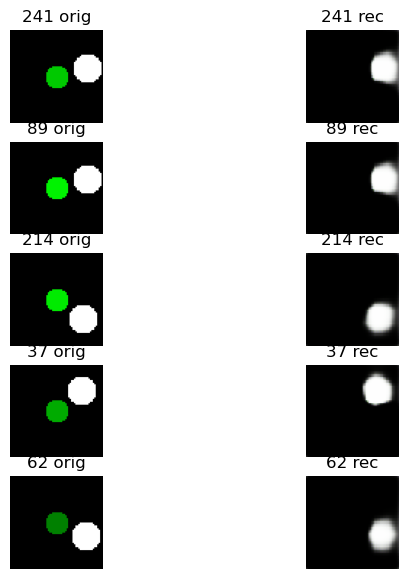

====> PCAAE2 Epoch: 16 Train loss: 0.028871,	 Train Rec loss: 0.025721,	 Train Dep loss: 0.003150
====> PCAAE2 Epoch: 16 Test loss: 0.022930,	 Test Rec loss: 0.021707,	 Test Dep loss: 0.001223
====> PCAAE2 Epoch: 17 Train loss: 0.025360,	 Train Rec loss: 0.023232,	 Train Dep loss: 0.002128
====> PCAAE2 Epoch: 17 Test loss: 0.021429,	 Test Rec loss: 0.020148,	 Test Dep loss: 0.001281
====> PCAAE2 Epoch: 18 Train loss: 0.025938,	 Train Rec loss: 0.024154,	 Train Dep loss: 0.001784
====> PCAAE2 Epoch: 18 Test loss: 0.023635,	 Test Rec loss: 0.020614,	 Test Dep loss: 0.003021
====> PCAAE2 Epoch: 19 Train loss: 0.025508,	 Train Rec loss: 0.023198,	 Train Dep loss: 0.002310
====> PCAAE2 Epoch: 19 Test loss: 0.023585,	 Test Rec loss: 0.021655,	 Test Dep loss: 0.001930
====> PCAAE2 Epoch: 20 Train loss: 0.025858,	 Train Rec loss: 0.023030,	 Train Dep loss: 0.002829
====> PCAAE2 Epoch: 20 Test loss: 0.021878,	 Test Rec loss: 0.020524,	 Test Dep loss: 0.001353


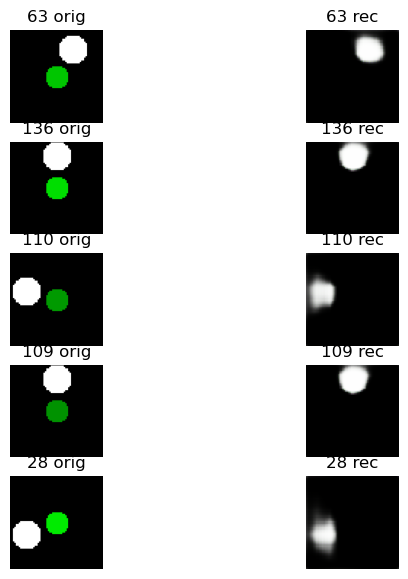

====> PCAAE2 Epoch: 21 Train loss: 0.026380,	 Train Rec loss: 0.023501,	 Train Dep loss: 0.002879
====> PCAAE2 Epoch: 21 Test loss: 0.027405,	 Test Rec loss: 0.022635,	 Test Dep loss: 0.004770
====> PCAAE2 Epoch: 22 Train loss: 0.024009,	 Train Rec loss: 0.022324,	 Train Dep loss: 0.001685
====> PCAAE2 Epoch: 22 Test loss: 0.021526,	 Test Rec loss: 0.019424,	 Test Dep loss: 0.002102
====> PCAAE2 Epoch: 23 Train loss: 0.024640,	 Train Rec loss: 0.022441,	 Train Dep loss: 0.002199
====> PCAAE2 Epoch: 23 Test loss: 0.020034,	 Test Rec loss: 0.018693,	 Test Dep loss: 0.001341
====> PCAAE2 Epoch: 24 Train loss: 0.025734,	 Train Rec loss: 0.022302,	 Train Dep loss: 0.003432
====> PCAAE2 Epoch: 24 Test loss: 0.020231,	 Test Rec loss: 0.018706,	 Test Dep loss: 0.001525
====> PCAAE2 Epoch: 25 Train loss: 0.024282,	 Train Rec loss: 0.022360,	 Train Dep loss: 0.001922
====> PCAAE2 Epoch: 25 Test loss: 0.019665,	 Test Rec loss: 0.018420,	 Test Dep loss: 0.001245


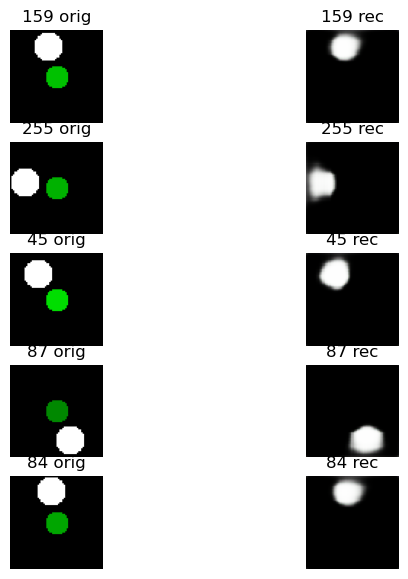

====> PCAAE2 Epoch: 26 Train loss: 0.023825,	 Train Rec loss: 0.022155,	 Train Dep loss: 0.001670
====> PCAAE2 Epoch: 26 Test loss: 0.021267,	 Test Rec loss: 0.018830,	 Test Dep loss: 0.002437
====> PCAAE2 Epoch: 27 Train loss: 0.024375,	 Train Rec loss: 0.022339,	 Train Dep loss: 0.002036
====> PCAAE2 Epoch: 27 Test loss: 0.019836,	 Test Rec loss: 0.018211,	 Test Dep loss: 0.001625
====> PCAAE2 Epoch: 28 Train loss: 0.024038,	 Train Rec loss: 0.021921,	 Train Dep loss: 0.002116
====> PCAAE2 Epoch: 28 Test loss: 0.020724,	 Test Rec loss: 0.018991,	 Test Dep loss: 0.001733
====> PCAAE2 Epoch: 29 Train loss: 0.024461,	 Train Rec loss: 0.022247,	 Train Dep loss: 0.002214
====> PCAAE2 Epoch: 29 Test loss: 0.019446,	 Test Rec loss: 0.017955,	 Test Dep loss: 0.001491
====> PCAAE2 Epoch: 30 Train loss: 0.022647,	 Train Rec loss: 0.021031,	 Train Dep loss: 0.001616
====> PCAAE2 Epoch: 30 Test loss: 0.019845,	 Test Rec loss: 0.018617,	 Test Dep loss: 0.001228


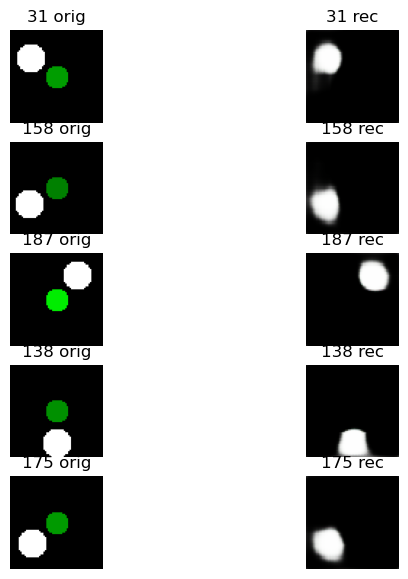

====> PCAAE2 Epoch: 31 Train loss: 0.024896,	 Train Rec loss: 0.022324,	 Train Dep loss: 0.002571
====> PCAAE2 Epoch: 31 Test loss: 0.019310,	 Test Rec loss: 0.018259,	 Test Dep loss: 0.001051
====> PCAAE2 Epoch: 32 Train loss: 0.024990,	 Train Rec loss: 0.021878,	 Train Dep loss: 0.003112
====> PCAAE2 Epoch: 32 Test loss: 0.019323,	 Test Rec loss: 0.017980,	 Test Dep loss: 0.001343
====> PCAAE2 Epoch: 33 Train loss: 0.023135,	 Train Rec loss: 0.020777,	 Train Dep loss: 0.002358
====> PCAAE2 Epoch: 33 Test loss: 0.018168,	 Test Rec loss: 0.016983,	 Test Dep loss: 0.001186
====> PCAAE2 Epoch: 34 Train loss: 0.021967,	 Train Rec loss: 0.020706,	 Train Dep loss: 0.001261
====> PCAAE2 Epoch: 34 Test loss: 0.018883,	 Test Rec loss: 0.017731,	 Test Dep loss: 0.001152
====> PCAAE2 Epoch: 35 Train loss: 0.023232,	 Train Rec loss: 0.021254,	 Train Dep loss: 0.001978
====> PCAAE2 Epoch: 35 Test loss: 0.018229,	 Test Rec loss: 0.016994,	 Test Dep loss: 0.001235


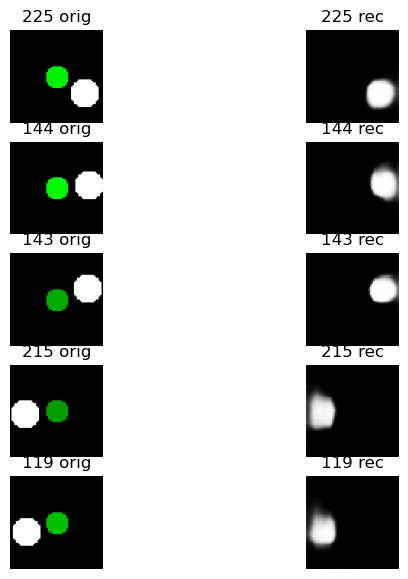

====> PCAAE2 Epoch: 36 Train loss: 0.023096,	 Train Rec loss: 0.020401,	 Train Dep loss: 0.002695
====> PCAAE2 Epoch: 36 Test loss: 0.018501,	 Test Rec loss: 0.017204,	 Test Dep loss: 0.001297
====> PCAAE2 Epoch: 37 Train loss: 0.023939,	 Train Rec loss: 0.020823,	 Train Dep loss: 0.003116
====> PCAAE2 Epoch: 37 Test loss: 0.018700,	 Test Rec loss: 0.017241,	 Test Dep loss: 0.001459
====> PCAAE2 Epoch: 38 Train loss: 0.022916,	 Train Rec loss: 0.021061,	 Train Dep loss: 0.001855
====> PCAAE2 Epoch: 38 Test loss: 0.018733,	 Test Rec loss: 0.017529,	 Test Dep loss: 0.001204
====> PCAAE2 Epoch: 39 Train loss: 0.021842,	 Train Rec loss: 0.019845,	 Train Dep loss: 0.001997
====> PCAAE2 Epoch: 39 Test loss: 0.018173,	 Test Rec loss: 0.016846,	 Test Dep loss: 0.001327
====> PCAAE2 Epoch: 40 Train loss: 0.022866,	 Train Rec loss: 0.020995,	 Train Dep loss: 0.001871
====> PCAAE2 Epoch: 40 Test loss: 0.019262,	 Test Rec loss: 0.018007,	 Test Dep loss: 0.001255


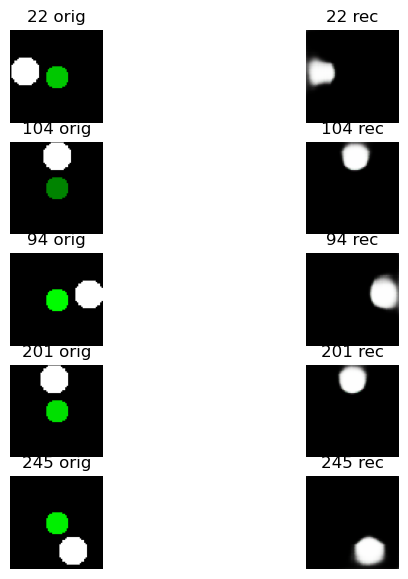

====> PCAAE2 Epoch: 41 Train loss: 0.024312,	 Train Rec loss: 0.022126,	 Train Dep loss: 0.002187
====> PCAAE2 Epoch: 41 Test loss: 0.017897,	 Test Rec loss: 0.016656,	 Test Dep loss: 0.001241
====> PCAAE2 Epoch: 42 Train loss: 0.022615,	 Train Rec loss: 0.019915,	 Train Dep loss: 0.002699
====> PCAAE2 Epoch: 42 Test loss: 0.020308,	 Test Rec loss: 0.018740,	 Test Dep loss: 0.001568
====> PCAAE2 Epoch: 43 Train loss: 0.021491,	 Train Rec loss: 0.019775,	 Train Dep loss: 0.001716
====> PCAAE2 Epoch: 43 Test loss: 0.019256,	 Test Rec loss: 0.018046,	 Test Dep loss: 0.001210
====> PCAAE2 Epoch: 44 Train loss: 0.023564,	 Train Rec loss: 0.020361,	 Train Dep loss: 0.003203
====> PCAAE2 Epoch: 44 Test loss: 0.018316,	 Test Rec loss: 0.017106,	 Test Dep loss: 0.001210
====> PCAAE2 Epoch: 45 Train loss: 0.024781,	 Train Rec loss: 0.020907,	 Train Dep loss: 0.003875
====> PCAAE2 Epoch: 45 Test loss: 0.018582,	 Test Rec loss: 0.017097,	 Test Dep loss: 0.001484


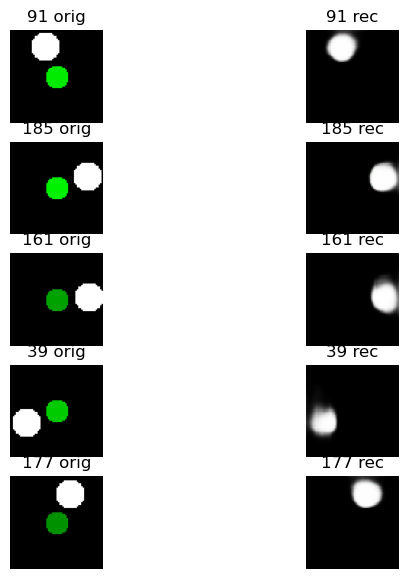

====> PCAAE2 Epoch: 46 Train loss: 0.022145,	 Train Rec loss: 0.020056,	 Train Dep loss: 0.002089
====> PCAAE2 Epoch: 46 Test loss: 0.018451,	 Test Rec loss: 0.017206,	 Test Dep loss: 0.001245
====> PCAAE2 Epoch: 47 Train loss: 0.021627,	 Train Rec loss: 0.019721,	 Train Dep loss: 0.001906
====> PCAAE2 Epoch: 47 Test loss: 0.021021,	 Test Rec loss: 0.017972,	 Test Dep loss: 0.003049
====> PCAAE2 Epoch: 48 Train loss: 0.022584,	 Train Rec loss: 0.019652,	 Train Dep loss: 0.002932
====> PCAAE2 Epoch: 48 Test loss: 0.020967,	 Test Rec loss: 0.017879,	 Test Dep loss: 0.003089
====> PCAAE2 Epoch: 49 Train loss: 0.021769,	 Train Rec loss: 0.019485,	 Train Dep loss: 0.002284
====> PCAAE2 Epoch: 49 Test loss: 0.017092,	 Test Rec loss: 0.015851,	 Test Dep loss: 0.001241
====> PCAAE2 Epoch: 50 Train loss: 0.021212,	 Train Rec loss: 0.019534,	 Train Dep loss: 0.001678
====> PCAAE2 Epoch: 50 Test loss: 0.018041,	 Test Rec loss: 0.016110,	 Test Dep loss: 0.001930


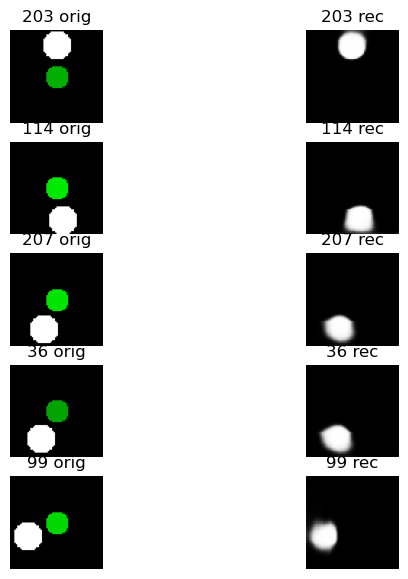

====> PCAAE2 Epoch: 51 Train loss: 0.023593,	 Train Rec loss: 0.020538,	 Train Dep loss: 0.003055
====> PCAAE2 Epoch: 51 Test loss: 0.019544,	 Test Rec loss: 0.017052,	 Test Dep loss: 0.002492
====> PCAAE2 Epoch: 52 Train loss: 0.022106,	 Train Rec loss: 0.019366,	 Train Dep loss: 0.002740
====> PCAAE2 Epoch: 52 Test loss: 0.019043,	 Test Rec loss: 0.017335,	 Test Dep loss: 0.001708
====> PCAAE2 Epoch: 53 Train loss: 0.021161,	 Train Rec loss: 0.019752,	 Train Dep loss: 0.001409
====> PCAAE2 Epoch: 53 Test loss: 0.017045,	 Test Rec loss: 0.015917,	 Test Dep loss: 0.001128
====> PCAAE2 Epoch: 54 Train loss: 0.021044,	 Train Rec loss: 0.019589,	 Train Dep loss: 0.001455
====> PCAAE2 Epoch: 54 Test loss: 0.018641,	 Test Rec loss: 0.017451,	 Test Dep loss: 0.001190
====> PCAAE2 Epoch: 55 Train loss: 0.021567,	 Train Rec loss: 0.019257,	 Train Dep loss: 0.002309
====> PCAAE2 Epoch: 55 Test loss: 0.018237,	 Test Rec loss: 0.016802,	 Test Dep loss: 0.001436


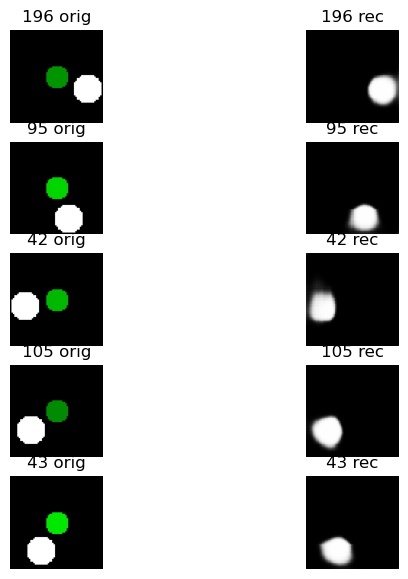

====> PCAAE2 Epoch: 56 Train loss: 0.022902,	 Train Rec loss: 0.020950,	 Train Dep loss: 0.001952
====> PCAAE2 Epoch: 56 Test loss: 0.019840,	 Test Rec loss: 0.017484,	 Test Dep loss: 0.002356
====> PCAAE2 Epoch: 57 Train loss: 0.024289,	 Train Rec loss: 0.021055,	 Train Dep loss: 0.003234
====> PCAAE2 Epoch: 57 Test loss: 0.018536,	 Test Rec loss: 0.016872,	 Test Dep loss: 0.001664
====> PCAAE2 Epoch: 58 Train loss: 0.021241,	 Train Rec loss: 0.019482,	 Train Dep loss: 0.001760
====> PCAAE2 Epoch: 58 Test loss: 0.016961,	 Test Rec loss: 0.015761,	 Test Dep loss: 0.001201
====> PCAAE2 Epoch: 59 Train loss: 0.021707,	 Train Rec loss: 0.018760,	 Train Dep loss: 0.002947
====> PCAAE2 Epoch: 59 Test loss: 0.018204,	 Test Rec loss: 0.016767,	 Test Dep loss: 0.001437
====> PCAAE2 Epoch: 60 Train loss: 0.021466,	 Train Rec loss: 0.018808,	 Train Dep loss: 0.002658
====> PCAAE2 Epoch: 60 Test loss: 0.019046,	 Test Rec loss: 0.016830,	 Test Dep loss: 0.002216


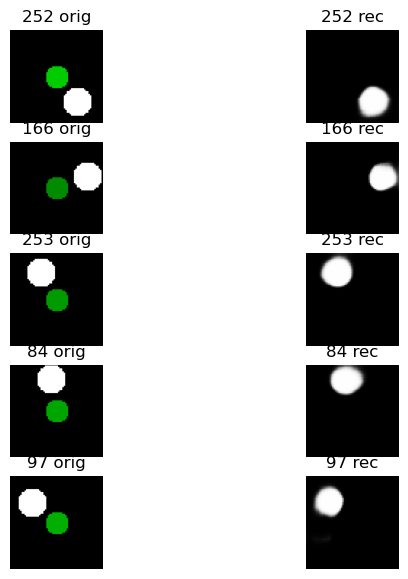

====> PCAAE2 Epoch: 61 Train loss: 0.022945,	 Train Rec loss: 0.019901,	 Train Dep loss: 0.003043
====> PCAAE2 Epoch: 61 Test loss: 0.017149,	 Test Rec loss: 0.015917,	 Test Dep loss: 0.001232
====> PCAAE2 Epoch: 62 Train loss: 0.023381,	 Train Rec loss: 0.020664,	 Train Dep loss: 0.002717
====> PCAAE2 Epoch: 62 Test loss: 0.018736,	 Test Rec loss: 0.016750,	 Test Dep loss: 0.001987
====> PCAAE2 Epoch: 63 Train loss: 0.022664,	 Train Rec loss: 0.020343,	 Train Dep loss: 0.002322
====> PCAAE2 Epoch: 63 Test loss: 0.018269,	 Test Rec loss: 0.016734,	 Test Dep loss: 0.001535
====> PCAAE2 Epoch: 64 Train loss: 0.021454,	 Train Rec loss: 0.019521,	 Train Dep loss: 0.001933
====> PCAAE2 Epoch: 64 Test loss: 0.018093,	 Test Rec loss: 0.017067,	 Test Dep loss: 0.001025
====> PCAAE2 Epoch: 65 Train loss: 0.022306,	 Train Rec loss: 0.020754,	 Train Dep loss: 0.001552
====> PCAAE2 Epoch: 65 Test loss: 0.018105,	 Test Rec loss: 0.016765,	 Test Dep loss: 0.001340


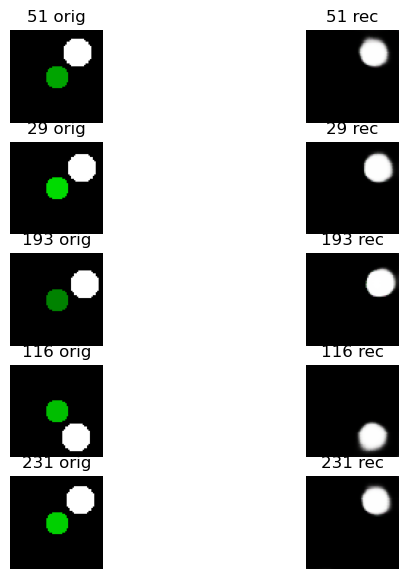

====> PCAAE2 Epoch: 66 Train loss: 0.022336,	 Train Rec loss: 0.019020,	 Train Dep loss: 0.003316
====> PCAAE2 Epoch: 66 Test loss: 0.016995,	 Test Rec loss: 0.015650,	 Test Dep loss: 0.001346
====> PCAAE2 Epoch: 67 Train loss: 0.021225,	 Train Rec loss: 0.019624,	 Train Dep loss: 0.001601
====> PCAAE2 Epoch: 67 Test loss: 0.018078,	 Test Rec loss: 0.016342,	 Test Dep loss: 0.001737
====> PCAAE2 Epoch: 68 Train loss: 0.019891,	 Train Rec loss: 0.018871,	 Train Dep loss: 0.001020
====> PCAAE2 Epoch: 68 Test loss: 0.016700,	 Test Rec loss: 0.015360,	 Test Dep loss: 0.001340
====> PCAAE2 Epoch: 69 Train loss: 0.021574,	 Train Rec loss: 0.019684,	 Train Dep loss: 0.001890
====> PCAAE2 Epoch: 69 Test loss: 0.017883,	 Test Rec loss: 0.016637,	 Test Dep loss: 0.001246
====> PCAAE2 Epoch: 70 Train loss: 0.022742,	 Train Rec loss: 0.020166,	 Train Dep loss: 0.002576
====> PCAAE2 Epoch: 70 Test loss: 0.018928,	 Test Rec loss: 0.017484,	 Test Dep loss: 0.001443


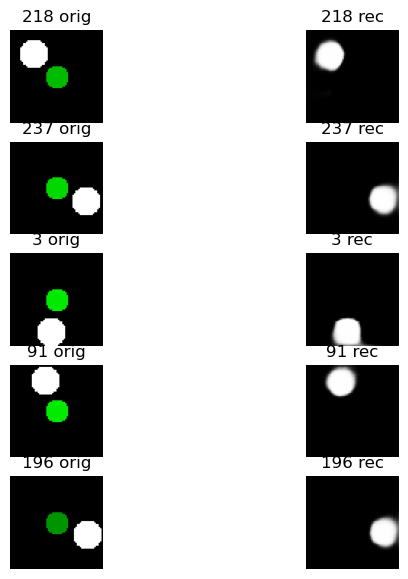

====> PCAAE2 Epoch: 71 Train loss: 0.019761,	 Train Rec loss: 0.018329,	 Train Dep loss: 0.001431
====> PCAAE2 Epoch: 71 Test loss: 0.015979,	 Test Rec loss: 0.014818,	 Test Dep loss: 0.001160
====> PCAAE2 Epoch: 72 Train loss: 0.021190,	 Train Rec loss: 0.019054,	 Train Dep loss: 0.002136
====> PCAAE2 Epoch: 72 Test loss: 0.016905,	 Test Rec loss: 0.015712,	 Test Dep loss: 0.001193
====> PCAAE2 Epoch: 73 Train loss: 0.022555,	 Train Rec loss: 0.020000,	 Train Dep loss: 0.002555
====> PCAAE2 Epoch: 73 Test loss: 0.016950,	 Test Rec loss: 0.015432,	 Test Dep loss: 0.001518
====> PCAAE2 Epoch: 74 Train loss: 0.022929,	 Train Rec loss: 0.019855,	 Train Dep loss: 0.003074
====> PCAAE2 Epoch: 74 Test loss: 0.018403,	 Test Rec loss: 0.016556,	 Test Dep loss: 0.001847
====> PCAAE2 Epoch: 75 Train loss: 0.021614,	 Train Rec loss: 0.019465,	 Train Dep loss: 0.002149
====> PCAAE2 Epoch: 75 Test loss: 0.017719,	 Test Rec loss: 0.016072,	 Test Dep loss: 0.001647


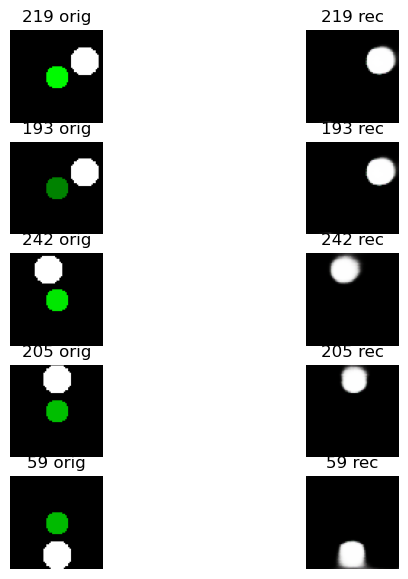

====> PCAAE2 Epoch: 76 Train loss: 0.020958,	 Train Rec loss: 0.019302,	 Train Dep loss: 0.001656
====> PCAAE2 Epoch: 76 Test loss: 0.018619,	 Test Rec loss: 0.016809,	 Test Dep loss: 0.001809
====> PCAAE2 Epoch: 77 Train loss: 0.021004,	 Train Rec loss: 0.019155,	 Train Dep loss: 0.001849
====> PCAAE2 Epoch: 77 Test loss: 0.018265,	 Test Rec loss: 0.017028,	 Test Dep loss: 0.001237
====> PCAAE2 Epoch: 78 Train loss: 0.022783,	 Train Rec loss: 0.019614,	 Train Dep loss: 0.003169
====> PCAAE2 Epoch: 78 Test loss: 0.017575,	 Test Rec loss: 0.016276,	 Test Dep loss: 0.001299
====> PCAAE2 Epoch: 79 Train loss: 0.021033,	 Train Rec loss: 0.018968,	 Train Dep loss: 0.002064
====> PCAAE2 Epoch: 79 Test loss: 0.015757,	 Test Rec loss: 0.014600,	 Test Dep loss: 0.001157
====> PCAAE2 Epoch: 80 Train loss: 0.022391,	 Train Rec loss: 0.018972,	 Train Dep loss: 0.003419
====> PCAAE2 Epoch: 80 Test loss: 0.017628,	 Test Rec loss: 0.016443,	 Test Dep loss: 0.001185


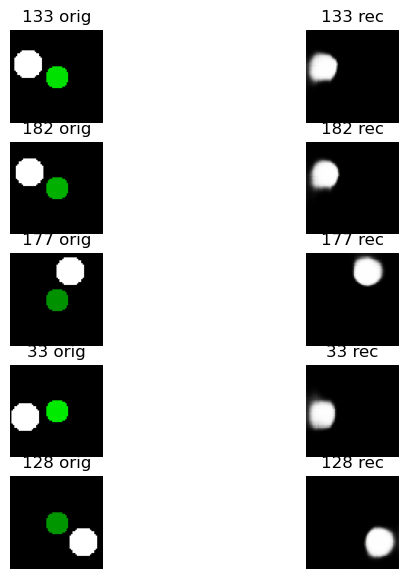

====> PCAAE2 Epoch: 81 Train loss: 0.022027,	 Train Rec loss: 0.018972,	 Train Dep loss: 0.003055
====> PCAAE2 Epoch: 81 Test loss: 0.016495,	 Test Rec loss: 0.015127,	 Test Dep loss: 0.001368
====> PCAAE2 Epoch: 82 Train loss: 0.022430,	 Train Rec loss: 0.020595,	 Train Dep loss: 0.001835
====> PCAAE2 Epoch: 82 Test loss: 0.015862,	 Test Rec loss: 0.014610,	 Test Dep loss: 0.001251
====> PCAAE2 Epoch: 83 Train loss: 0.020864,	 Train Rec loss: 0.018413,	 Train Dep loss: 0.002451
====> PCAAE2 Epoch: 83 Test loss: 0.022230,	 Test Rec loss: 0.020796,	 Test Dep loss: 0.001434
====> PCAAE2 Epoch: 84 Train loss: 0.021338,	 Train Rec loss: 0.019829,	 Train Dep loss: 0.001508
====> PCAAE2 Epoch: 84 Test loss: 0.017022,	 Test Rec loss: 0.015723,	 Test Dep loss: 0.001299
====> PCAAE2 Epoch: 85 Train loss: 0.020104,	 Train Rec loss: 0.018160,	 Train Dep loss: 0.001944
====> PCAAE2 Epoch: 85 Test loss: 0.016740,	 Test Rec loss: 0.015511,	 Test Dep loss: 0.001229


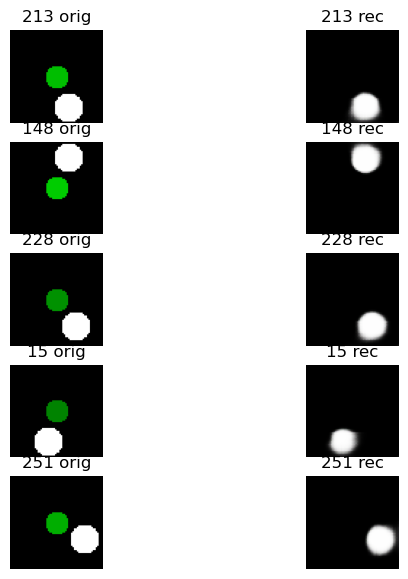

====> PCAAE2 Epoch: 86 Train loss: 0.020096,	 Train Rec loss: 0.018618,	 Train Dep loss: 0.001478
====> PCAAE2 Epoch: 86 Test loss: 0.016302,	 Test Rec loss: 0.014809,	 Test Dep loss: 0.001494
====> PCAAE2 Epoch: 87 Train loss: 0.021552,	 Train Rec loss: 0.019684,	 Train Dep loss: 0.001868
====> PCAAE2 Epoch: 87 Test loss: 0.016737,	 Test Rec loss: 0.015393,	 Test Dep loss: 0.001344
====> PCAAE2 Epoch: 88 Train loss: 0.022372,	 Train Rec loss: 0.019828,	 Train Dep loss: 0.002544
====> PCAAE2 Epoch: 88 Test loss: 0.016670,	 Test Rec loss: 0.015448,	 Test Dep loss: 0.001222
====> PCAAE2 Epoch: 89 Train loss: 0.022163,	 Train Rec loss: 0.019559,	 Train Dep loss: 0.002604
====> PCAAE2 Epoch: 89 Test loss: 0.016247,	 Test Rec loss: 0.015146,	 Test Dep loss: 0.001101
====> PCAAE2 Epoch: 90 Train loss: 0.021442,	 Train Rec loss: 0.019339,	 Train Dep loss: 0.002103
====> PCAAE2 Epoch: 90 Test loss: 0.017040,	 Test Rec loss: 0.015777,	 Test Dep loss: 0.001263


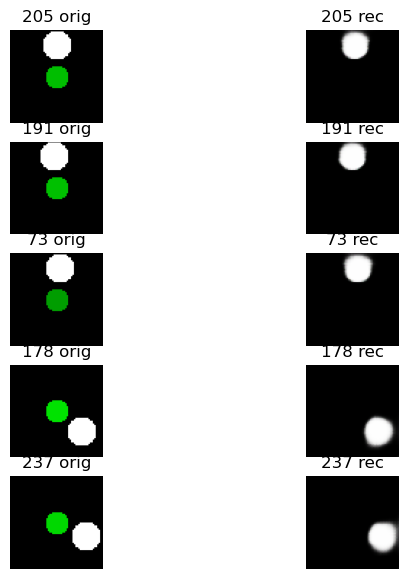

====> PCAAE2 Epoch: 91 Train loss: 0.020748,	 Train Rec loss: 0.018204,	 Train Dep loss: 0.002544
====> PCAAE2 Epoch: 91 Test loss: 0.015855,	 Test Rec loss: 0.014684,	 Test Dep loss: 0.001171
====> PCAAE2 Epoch: 92 Train loss: 0.020768,	 Train Rec loss: 0.018794,	 Train Dep loss: 0.001974
====> PCAAE2 Epoch: 92 Test loss: 0.016535,	 Test Rec loss: 0.014949,	 Test Dep loss: 0.001586
====> PCAAE2 Epoch: 93 Train loss: 0.021452,	 Train Rec loss: 0.019174,	 Train Dep loss: 0.002278
====> PCAAE2 Epoch: 93 Test loss: 0.019019,	 Test Rec loss: 0.017509,	 Test Dep loss: 0.001509
====> PCAAE2 Epoch: 94 Train loss: 0.022532,	 Train Rec loss: 0.019545,	 Train Dep loss: 0.002987
====> PCAAE2 Epoch: 94 Test loss: 0.017186,	 Test Rec loss: 0.016095,	 Test Dep loss: 0.001090
====> PCAAE2 Epoch: 95 Train loss: 0.021894,	 Train Rec loss: 0.019650,	 Train Dep loss: 0.002244
====> PCAAE2 Epoch: 95 Test loss: 0.019354,	 Test Rec loss: 0.018231,	 Test Dep loss: 0.001123


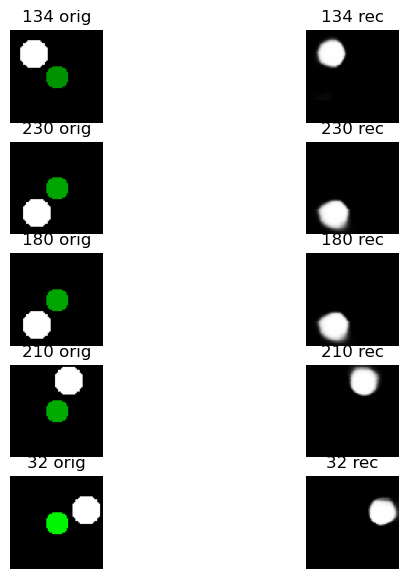

====> PCAAE2 Epoch: 96 Train loss: 0.021106,	 Train Rec loss: 0.018855,	 Train Dep loss: 0.002252
====> PCAAE2 Epoch: 96 Test loss: 0.016082,	 Test Rec loss: 0.014790,	 Test Dep loss: 0.001292
====> PCAAE2 Epoch: 97 Train loss: 0.020441,	 Train Rec loss: 0.018562,	 Train Dep loss: 0.001879
====> PCAAE2 Epoch: 97 Test loss: 0.016060,	 Test Rec loss: 0.014697,	 Test Dep loss: 0.001363
====> PCAAE2 Epoch: 98 Train loss: 0.020626,	 Train Rec loss: 0.018374,	 Train Dep loss: 0.002253
====> PCAAE2 Epoch: 98 Test loss: 0.016007,	 Test Rec loss: 0.014696,	 Test Dep loss: 0.001310
====> PCAAE2 Epoch: 99 Train loss: 0.020789,	 Train Rec loss: 0.018293,	 Train Dep loss: 0.002496
====> PCAAE2 Epoch: 99 Test loss: 0.015520,	 Test Rec loss: 0.014358,	 Test Dep loss: 0.001162
====> PCAAE2 Epoch: 100 Train loss: 0.021190,	 Train Rec loss: 0.018722,	 Train Dep loss: 0.002468
====> PCAAE2 Epoch: 100 Test loss: 0.016004,	 Test Rec loss: 0.014645,	 Test Dep loss: 0.001359


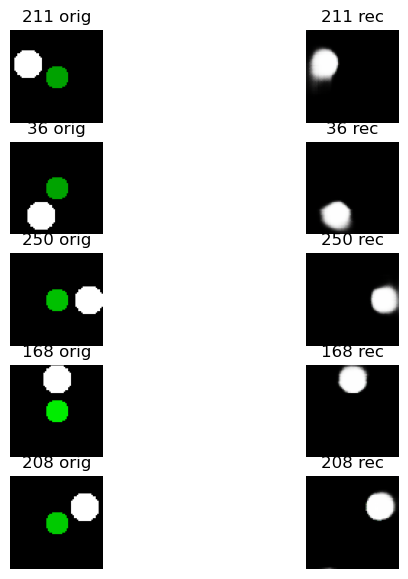

In [21]:
basic_PCAAE_path = './models/basic_PCAAE/'
if os.path.exists(basic_PCAAE_path) is False:
    os.makedirs(basic_PCAAE_path)
model_path_list = sorted(glob(f'{basic_PCAAE_path}basic_PCAAE_step*'), key=len)

if len(model_path_list) != 0:
    print('A trained model is found')
    is_training = False
    weightname = model_path_list[-1]

if is_training:
    print("Training basic PCAAE \n")
    for step in range(1, train_latent + 1):
        weightname = f'{basic_PCAAE_path}basic_PCAAE_step{step}_lambdadep{lambda_dep_basic}'
        for epoch in range(1, num_epoch + 1):
            train_PCAAE(basic_PCAAE_E, basic_PCAAE_D, basic_PCAAE_optim, epoch, step, device, train_loader, test_loader,
                         lambda_rec, lambda_dep_basic, basic_loss=True)
            torch.save( {'basic_PCAAE_E_state_dict': basic_PCAAE_E[step-1].state_dict(),
                         'basic_PCAAE_D_state_dict': basic_PCAAE_D[step-1].state_dict(),
                         'basic_PCAAE_optim_state_dict': basic_PCAAE_optim[step-1].state_dict(),}, 
                        weightname)
                    
else:
    print(f"Load the model: {weightname}")
    checkpoint_basic_PCAAE = torch.load(weightname, device)
    basic_PCAAE_E[test_latent-1].load_state_dict(checkpoint_basic_PCAAE['basic_PCAAE_E_state_dict'])
    basic_PCAAE_D[test_latent-1].load_state_dict(checkpoint_basic_PCAAE['basic_PCAAE_D_state_dict'])

dcor-PCAAE

In [22]:
dcor_PCAAE_E = []
dcor_PCAAE_D = []
for id_m in range(train_latent):  
    dcor_PCAAE_E_i = Encoder(code_size=1, channel=channel).to(device)
    dcor_PCAAE_D_i = Decoder(code_size=id_m+1, channel=channel).to(device)
    dcor_PCAAE_E_i.apply(init_weights)
    dcor_PCAAE_D_i.apply(init_weights)
    dcor_PCAAE_E.append(dcor_PCAAE_E_i)
    dcor_PCAAE_D.append(dcor_PCAAE_D_i)

dcor_PCAAE_optim = []
for id_m in range(train_latent):
    optim_temp = optim.Adam(itertools.chain(dcor_PCAAE_E[id_m].parameters(), 
                                            dcor_PCAAE_D[id_m].parameters()), 
                            lr=lr, betas=(0.5, 0.999))
    dcor_PCAAE_optim.append(optim_temp)

Training dcor-PCAAE 

====> PCAAE1 Epoch: 1 Train loss: 0.199583,	 Train Rec loss: 0.199583,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 1 Test loss: 0.099650,	 Test Rec loss: 0.099650,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 2 Train loss: 0.089022,	 Train Rec loss: 0.089022,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 2 Test loss: 0.087697,	 Test Rec loss: 0.087697,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 3 Train loss: 0.083570,	 Train Rec loss: 0.083570,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 3 Test loss: 0.082497,	 Test Rec loss: 0.082497,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 4 Train loss: 0.076384,	 Train Rec loss: 0.076384,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 4 Test loss: 0.073997,	 Test Rec loss: 0.073997,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 5 Train loss: 0.073352,	 Train Rec loss: 0.073352,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 5 Test loss: 0.072476,	 Test Rec loss: 0.072476,	 Test Dep loss: 0.000000


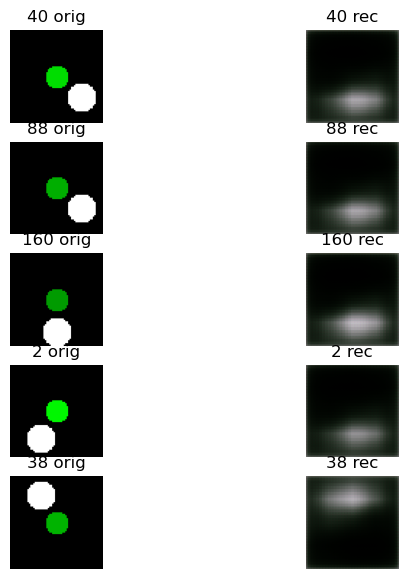

====> PCAAE1 Epoch: 6 Train loss: 0.072265,	 Train Rec loss: 0.072265,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 6 Test loss: 0.071270,	 Test Rec loss: 0.071270,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 7 Train loss: 0.071051,	 Train Rec loss: 0.071051,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 7 Test loss: 0.070521,	 Test Rec loss: 0.070521,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 8 Train loss: 0.070044,	 Train Rec loss: 0.070044,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 8 Test loss: 0.069155,	 Test Rec loss: 0.069155,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 9 Train loss: 0.068985,	 Train Rec loss: 0.068985,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 9 Test loss: 0.068370,	 Test Rec loss: 0.068370,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 10 Train loss: 0.067997,	 Train Rec loss: 0.067997,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 10 Test loss: 0.067266,	 Test Rec loss: 0.067266,	 Test Dep loss: 0.000000


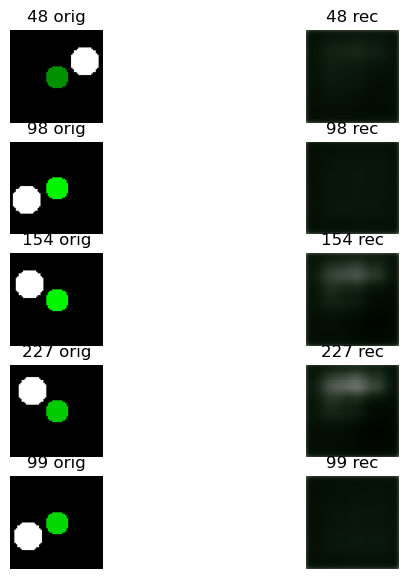

====> PCAAE1 Epoch: 11 Train loss: 0.067060,	 Train Rec loss: 0.067060,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 11 Test loss: 0.066253,	 Test Rec loss: 0.066253,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 12 Train loss: 0.065997,	 Train Rec loss: 0.065997,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 12 Test loss: 0.065049,	 Test Rec loss: 0.065049,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 13 Train loss: 0.064622,	 Train Rec loss: 0.064622,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 13 Test loss: 0.063530,	 Test Rec loss: 0.063530,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 14 Train loss: 0.063240,	 Train Rec loss: 0.063240,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 14 Test loss: 0.062360,	 Test Rec loss: 0.062360,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 15 Train loss: 0.062409,	 Train Rec loss: 0.062409,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 15 Test loss: 0.061599,	 Test Rec loss: 0.061599,	 Test Dep loss: 0.000000


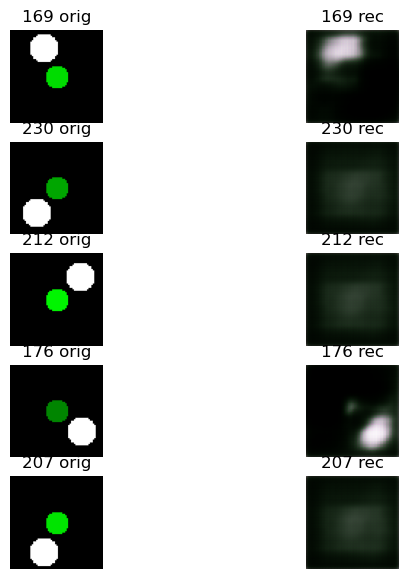

====> PCAAE1 Epoch: 16 Train loss: 0.061599,	 Train Rec loss: 0.061599,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 16 Test loss: 0.060790,	 Test Rec loss: 0.060790,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 17 Train loss: 0.060833,	 Train Rec loss: 0.060833,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 17 Test loss: 0.059662,	 Test Rec loss: 0.059662,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 18 Train loss: 0.059720,	 Train Rec loss: 0.059720,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 18 Test loss: 0.058479,	 Test Rec loss: 0.058479,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 19 Train loss: 0.058159,	 Train Rec loss: 0.058159,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 19 Test loss: 0.056716,	 Test Rec loss: 0.056716,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 20 Train loss: 0.056592,	 Train Rec loss: 0.056592,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 20 Test loss: 0.055566,	 Test Rec loss: 0.055566,	 Test Dep loss: 0.000000


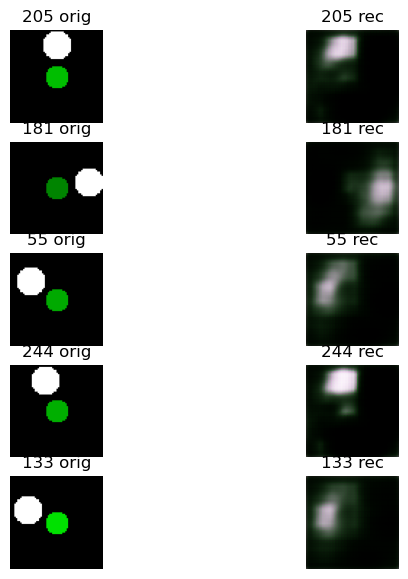

====> PCAAE1 Epoch: 21 Train loss: 0.055129,	 Train Rec loss: 0.055129,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 21 Test loss: 0.053802,	 Test Rec loss: 0.053802,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 22 Train loss: 0.053838,	 Train Rec loss: 0.053838,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 22 Test loss: 0.052109,	 Test Rec loss: 0.052109,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 23 Train loss: 0.052752,	 Train Rec loss: 0.052752,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 23 Test loss: 0.050665,	 Test Rec loss: 0.050665,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 24 Train loss: 0.051588,	 Train Rec loss: 0.051588,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 24 Test loss: 0.049920,	 Test Rec loss: 0.049920,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 25 Train loss: 0.050664,	 Train Rec loss: 0.050664,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 25 Test loss: 0.049664,	 Test Rec loss: 0.049664,	 Test Dep loss: 0.000000


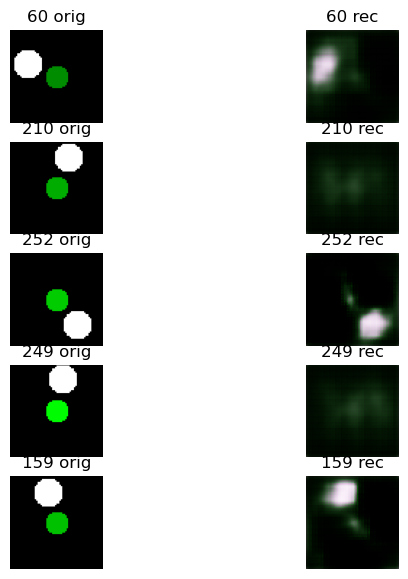

====> PCAAE1 Epoch: 26 Train loss: 0.050331,	 Train Rec loss: 0.050331,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 26 Test loss: 0.048091,	 Test Rec loss: 0.048091,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 27 Train loss: 0.049275,	 Train Rec loss: 0.049275,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 27 Test loss: 0.047080,	 Test Rec loss: 0.047080,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 28 Train loss: 0.048319,	 Train Rec loss: 0.048319,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 28 Test loss: 0.045928,	 Test Rec loss: 0.045928,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 29 Train loss: 0.047903,	 Train Rec loss: 0.047903,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 29 Test loss: 0.045554,	 Test Rec loss: 0.045554,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 30 Train loss: 0.047546,	 Train Rec loss: 0.047546,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 30 Test loss: 0.044814,	 Test Rec loss: 0.044814,	 Test Dep loss: 0.000000


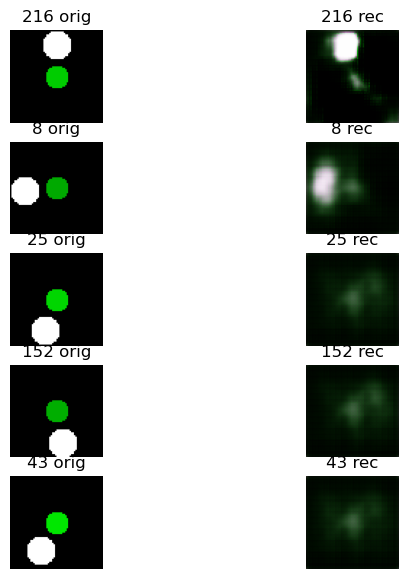

====> PCAAE1 Epoch: 31 Train loss: 0.046227,	 Train Rec loss: 0.046227,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 31 Test loss: 0.045884,	 Test Rec loss: 0.045884,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 32 Train loss: 0.045862,	 Train Rec loss: 0.045862,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 32 Test loss: 0.043032,	 Test Rec loss: 0.043032,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 33 Train loss: 0.045381,	 Train Rec loss: 0.045381,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 33 Test loss: 0.042197,	 Test Rec loss: 0.042197,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 34 Train loss: 0.044597,	 Train Rec loss: 0.044597,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 34 Test loss: 0.044900,	 Test Rec loss: 0.044900,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 35 Train loss: 0.043968,	 Train Rec loss: 0.043968,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 35 Test loss: 0.045438,	 Test Rec loss: 0.045438,	 Test Dep loss: 0.000000


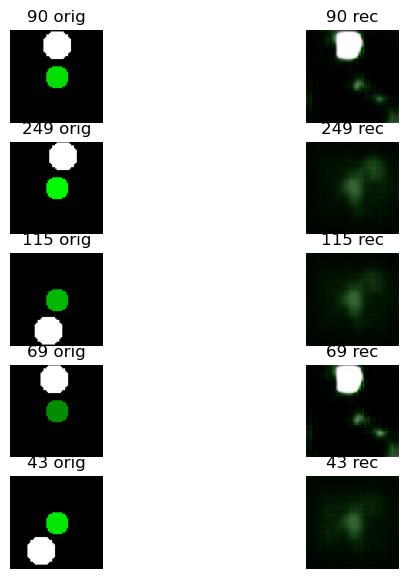

====> PCAAE1 Epoch: 36 Train loss: 0.042955,	 Train Rec loss: 0.042955,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 36 Test loss: 0.043229,	 Test Rec loss: 0.043229,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 37 Train loss: 0.042021,	 Train Rec loss: 0.042021,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 37 Test loss: 0.042338,	 Test Rec loss: 0.042338,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 38 Train loss: 0.042396,	 Train Rec loss: 0.042396,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 38 Test loss: 0.039866,	 Test Rec loss: 0.039866,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 39 Train loss: 0.041042,	 Train Rec loss: 0.041042,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 39 Test loss: 0.038911,	 Test Rec loss: 0.038911,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 40 Train loss: 0.040214,	 Train Rec loss: 0.040214,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 40 Test loss: 0.040027,	 Test Rec loss: 0.040027,	 Test Dep loss: 0.000000


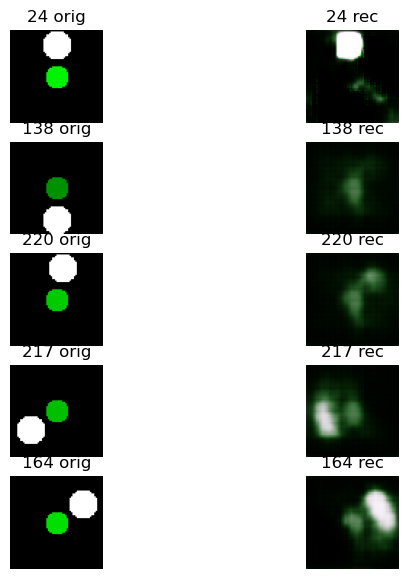

====> PCAAE1 Epoch: 41 Train loss: 0.040146,	 Train Rec loss: 0.040146,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 41 Test loss: 0.037744,	 Test Rec loss: 0.037744,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 42 Train loss: 0.038386,	 Train Rec loss: 0.038386,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 42 Test loss: 0.037882,	 Test Rec loss: 0.037882,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 43 Train loss: 0.039731,	 Train Rec loss: 0.039731,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 43 Test loss: 0.038145,	 Test Rec loss: 0.038145,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 44 Train loss: 0.038546,	 Train Rec loss: 0.038546,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 44 Test loss: 0.041635,	 Test Rec loss: 0.041635,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 45 Train loss: 0.038737,	 Train Rec loss: 0.038737,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 45 Test loss: 0.035521,	 Test Rec loss: 0.035521,	 Test Dep loss: 0.000000


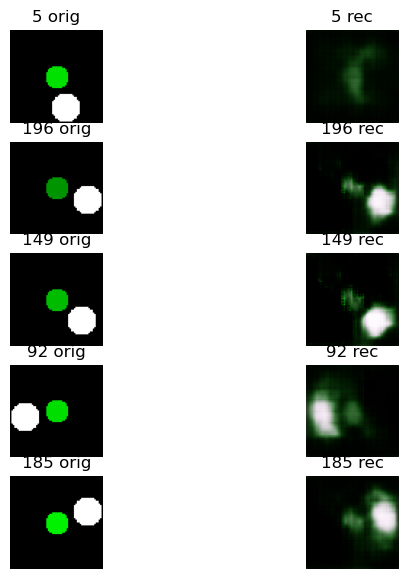

====> PCAAE1 Epoch: 46 Train loss: 0.039111,	 Train Rec loss: 0.039111,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 46 Test loss: 0.034889,	 Test Rec loss: 0.034889,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 47 Train loss: 0.037253,	 Train Rec loss: 0.037253,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 47 Test loss: 0.036670,	 Test Rec loss: 0.036670,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 48 Train loss: 0.036936,	 Train Rec loss: 0.036936,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 48 Test loss: 0.033151,	 Test Rec loss: 0.033151,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 49 Train loss: 0.038393,	 Train Rec loss: 0.038393,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 49 Test loss: 0.035063,	 Test Rec loss: 0.035063,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 50 Train loss: 0.036615,	 Train Rec loss: 0.036615,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 50 Test loss: 0.036642,	 Test Rec loss: 0.036642,	 Test Dep loss: 0.000000


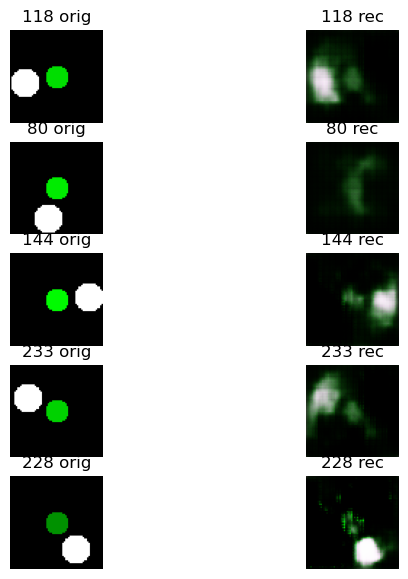

====> PCAAE1 Epoch: 51 Train loss: 0.036130,	 Train Rec loss: 0.036130,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 51 Test loss: 0.033181,	 Test Rec loss: 0.033181,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 52 Train loss: 0.036244,	 Train Rec loss: 0.036244,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 52 Test loss: 0.033939,	 Test Rec loss: 0.033939,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 53 Train loss: 0.035437,	 Train Rec loss: 0.035437,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 53 Test loss: 0.033921,	 Test Rec loss: 0.033921,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 54 Train loss: 0.036043,	 Train Rec loss: 0.036043,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 54 Test loss: 0.031484,	 Test Rec loss: 0.031484,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 55 Train loss: 0.034819,	 Train Rec loss: 0.034819,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 55 Test loss: 0.034134,	 Test Rec loss: 0.034134,	 Test Dep loss: 0.000000


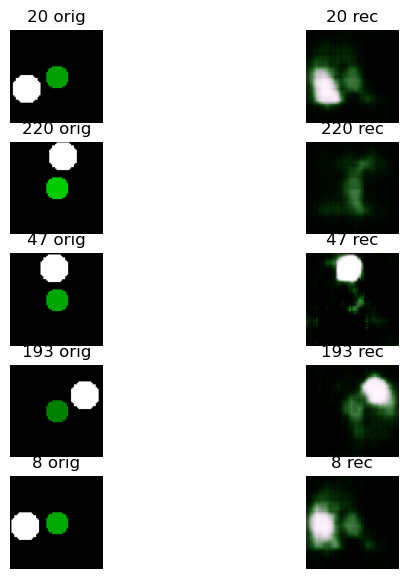

====> PCAAE1 Epoch: 56 Train loss: 0.033514,	 Train Rec loss: 0.033514,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 56 Test loss: 0.030905,	 Test Rec loss: 0.030905,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 57 Train loss: 0.035800,	 Train Rec loss: 0.035800,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 57 Test loss: 0.031173,	 Test Rec loss: 0.031173,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 58 Train loss: 0.035183,	 Train Rec loss: 0.035183,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 58 Test loss: 0.030585,	 Test Rec loss: 0.030585,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 59 Train loss: 0.033572,	 Train Rec loss: 0.033572,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 59 Test loss: 0.031312,	 Test Rec loss: 0.031312,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 60 Train loss: 0.035259,	 Train Rec loss: 0.035259,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 60 Test loss: 0.032824,	 Test Rec loss: 0.032824,	 Test Dep loss: 0.000000


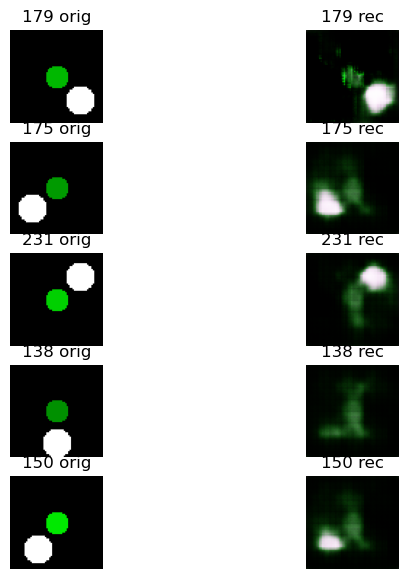

====> PCAAE1 Epoch: 61 Train loss: 0.035687,	 Train Rec loss: 0.035687,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 61 Test loss: 0.030210,	 Test Rec loss: 0.030210,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 62 Train loss: 0.032954,	 Train Rec loss: 0.032954,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 62 Test loss: 0.029299,	 Test Rec loss: 0.029299,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 63 Train loss: 0.032565,	 Train Rec loss: 0.032565,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 63 Test loss: 0.034014,	 Test Rec loss: 0.034014,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 64 Train loss: 0.034417,	 Train Rec loss: 0.034417,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 64 Test loss: 0.030083,	 Test Rec loss: 0.030083,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 65 Train loss: 0.032932,	 Train Rec loss: 0.032932,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 65 Test loss: 0.029088,	 Test Rec loss: 0.029088,	 Test Dep loss: 0.000000


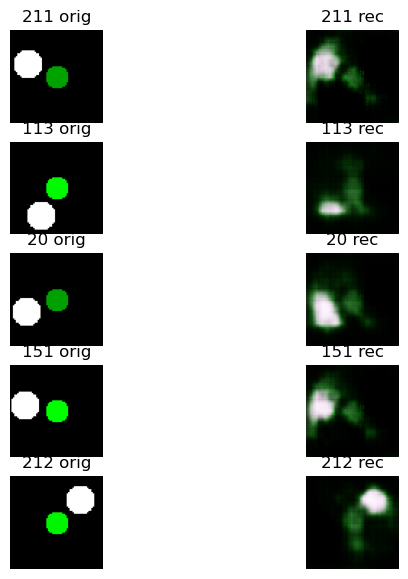

====> PCAAE1 Epoch: 66 Train loss: 0.033374,	 Train Rec loss: 0.033374,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 66 Test loss: 0.031152,	 Test Rec loss: 0.031152,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 67 Train loss: 0.034521,	 Train Rec loss: 0.034521,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 67 Test loss: 0.029772,	 Test Rec loss: 0.029772,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 68 Train loss: 0.031828,	 Train Rec loss: 0.031828,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 68 Test loss: 0.030604,	 Test Rec loss: 0.030604,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 69 Train loss: 0.032436,	 Train Rec loss: 0.032436,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 69 Test loss: 0.029949,	 Test Rec loss: 0.029949,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 70 Train loss: 0.031447,	 Train Rec loss: 0.031447,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 70 Test loss: 0.026704,	 Test Rec loss: 0.026704,	 Test Dep loss: 0.000000


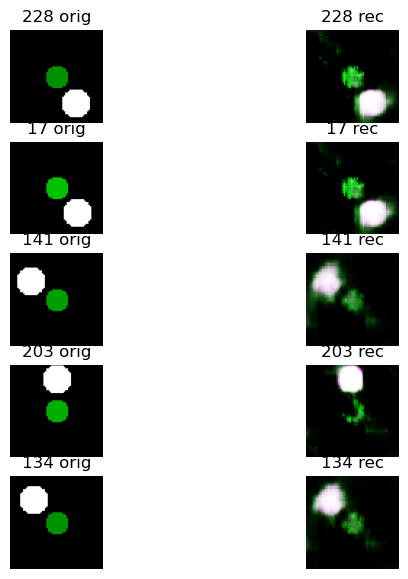

====> PCAAE1 Epoch: 71 Train loss: 0.032369,	 Train Rec loss: 0.032369,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 71 Test loss: 0.027105,	 Test Rec loss: 0.027105,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 72 Train loss: 0.034536,	 Train Rec loss: 0.034536,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 72 Test loss: 0.028862,	 Test Rec loss: 0.028862,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 73 Train loss: 0.031042,	 Train Rec loss: 0.031042,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 73 Test loss: 0.031606,	 Test Rec loss: 0.031606,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 74 Train loss: 0.030869,	 Train Rec loss: 0.030869,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 74 Test loss: 0.025845,	 Test Rec loss: 0.025845,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 75 Train loss: 0.030038,	 Train Rec loss: 0.030038,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 75 Test loss: 0.025300,	 Test Rec loss: 0.025300,	 Test Dep loss: 0.000000


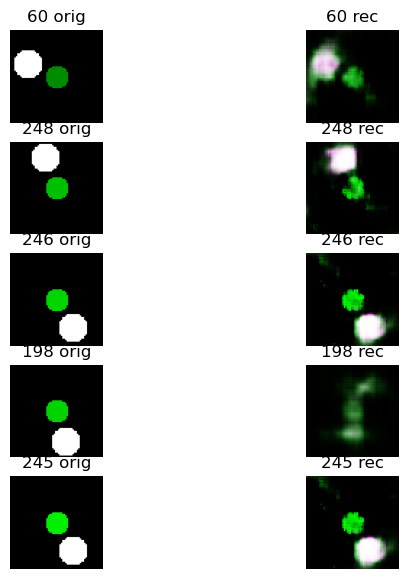

====> PCAAE1 Epoch: 76 Train loss: 0.029229,	 Train Rec loss: 0.029229,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 76 Test loss: 0.026418,	 Test Rec loss: 0.026418,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 77 Train loss: 0.027874,	 Train Rec loss: 0.027874,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 77 Test loss: 0.025294,	 Test Rec loss: 0.025294,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 78 Train loss: 0.028663,	 Train Rec loss: 0.028663,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 78 Test loss: 0.024329,	 Test Rec loss: 0.024329,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 79 Train loss: 0.029751,	 Train Rec loss: 0.029751,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 79 Test loss: 0.025363,	 Test Rec loss: 0.025363,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 80 Train loss: 0.029100,	 Train Rec loss: 0.029100,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 80 Test loss: 0.024351,	 Test Rec loss: 0.024351,	 Test Dep loss: 0.000000


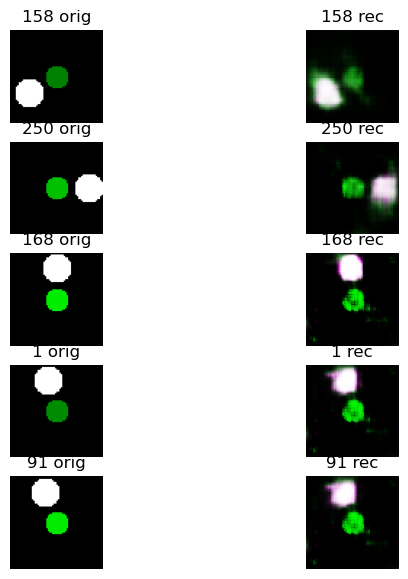

====> PCAAE1 Epoch: 81 Train loss: 0.028258,	 Train Rec loss: 0.028258,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 81 Test loss: 0.023957,	 Test Rec loss: 0.023957,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 82 Train loss: 0.028464,	 Train Rec loss: 0.028464,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 82 Test loss: 0.022921,	 Test Rec loss: 0.022921,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 83 Train loss: 0.029419,	 Train Rec loss: 0.029419,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 83 Test loss: 0.027782,	 Test Rec loss: 0.027782,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 84 Train loss: 0.026828,	 Train Rec loss: 0.026828,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 84 Test loss: 0.022815,	 Test Rec loss: 0.022815,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 85 Train loss: 0.027246,	 Train Rec loss: 0.027246,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 85 Test loss: 0.021637,	 Test Rec loss: 0.021637,	 Test Dep loss: 0.000000


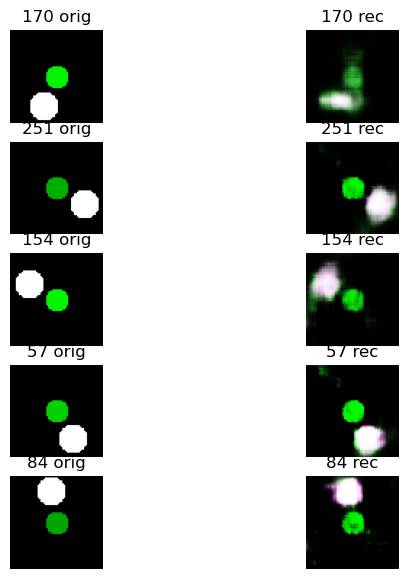

====> PCAAE1 Epoch: 86 Train loss: 0.027014,	 Train Rec loss: 0.027014,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 86 Test loss: 0.024598,	 Test Rec loss: 0.024598,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 87 Train loss: 0.026501,	 Train Rec loss: 0.026501,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 87 Test loss: 0.024037,	 Test Rec loss: 0.024037,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 88 Train loss: 0.026075,	 Train Rec loss: 0.026075,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 88 Test loss: 0.020343,	 Test Rec loss: 0.020343,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 89 Train loss: 0.025506,	 Train Rec loss: 0.025506,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 89 Test loss: 0.019826,	 Test Rec loss: 0.019826,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 90 Train loss: 0.026522,	 Train Rec loss: 0.026522,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 90 Test loss: 0.019955,	 Test Rec loss: 0.019955,	 Test Dep loss: 0.000000


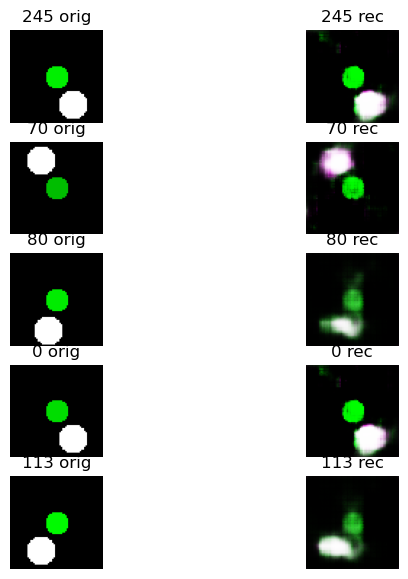

====> PCAAE1 Epoch: 91 Train loss: 0.027359,	 Train Rec loss: 0.027359,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 91 Test loss: 0.022037,	 Test Rec loss: 0.022037,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 92 Train loss: 0.025107,	 Train Rec loss: 0.025107,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 92 Test loss: 0.020928,	 Test Rec loss: 0.020928,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 93 Train loss: 0.024109,	 Train Rec loss: 0.024109,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 93 Test loss: 0.019260,	 Test Rec loss: 0.019260,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 94 Train loss: 0.024945,	 Train Rec loss: 0.024945,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 94 Test loss: 0.020580,	 Test Rec loss: 0.020580,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 95 Train loss: 0.023513,	 Train Rec loss: 0.023513,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 95 Test loss: 0.018844,	 Test Rec loss: 0.018844,	 Test Dep loss: 0.000000


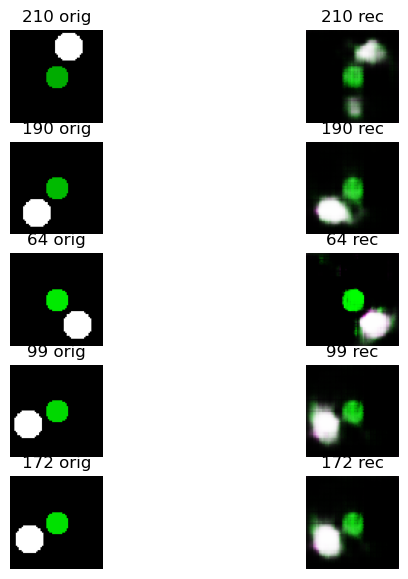

====> PCAAE1 Epoch: 96 Train loss: 0.024953,	 Train Rec loss: 0.024953,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 96 Test loss: 0.019646,	 Test Rec loss: 0.019646,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 97 Train loss: 0.024287,	 Train Rec loss: 0.024287,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 97 Test loss: 0.018297,	 Test Rec loss: 0.018297,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 98 Train loss: 0.025600,	 Train Rec loss: 0.025600,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 98 Test loss: 0.018674,	 Test Rec loss: 0.018674,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 99 Train loss: 0.026496,	 Train Rec loss: 0.026496,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 99 Test loss: 0.018451,	 Test Rec loss: 0.018451,	 Test Dep loss: 0.000000
====> PCAAE1 Epoch: 100 Train loss: 0.021791,	 Train Rec loss: 0.021791,	 Train Dep loss: 0.000000
====> PCAAE1 Epoch: 100 Test loss: 0.018788,	 Test Rec loss: 0.018788,	 Test Dep loss: 0.000000


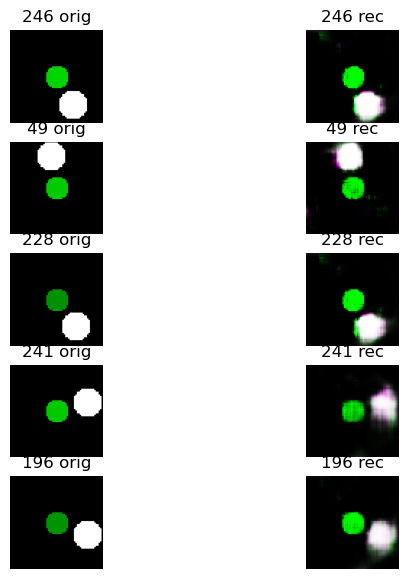

====> PCAAE2 Epoch: 1 Train loss: 0.201561,	 Train Rec loss: 0.163733,	 Train Dep loss: 0.037828
====> PCAAE2 Epoch: 1 Test loss: 0.098470,	 Test Rec loss: 0.089187,	 Test Dep loss: 0.009283
====> PCAAE2 Epoch: 2 Train loss: 0.100987,	 Train Rec loss: 0.086764,	 Train Dep loss: 0.014223
====> PCAAE2 Epoch: 2 Test loss: 0.099524,	 Test Rec loss: 0.083632,	 Test Dep loss: 0.015892
====> PCAAE2 Epoch: 3 Train loss: 0.090155,	 Train Rec loss: 0.079343,	 Train Dep loss: 0.010812
====> PCAAE2 Epoch: 3 Test loss: 0.089483,	 Test Rec loss: 0.075726,	 Test Dep loss: 0.013757
====> PCAAE2 Epoch: 4 Train loss: 0.086824,	 Train Rec loss: 0.074454,	 Train Dep loss: 0.012370
====> PCAAE2 Epoch: 4 Test loss: 0.082520,	 Test Rec loss: 0.072468,	 Test Dep loss: 0.010052
====> PCAAE2 Epoch: 5 Train loss: 0.083200,	 Train Rec loss: 0.071439,	 Train Dep loss: 0.011761
====> PCAAE2 Epoch: 5 Test loss: 0.080151,	 Test Rec loss: 0.069533,	 Test Dep loss: 0.010618


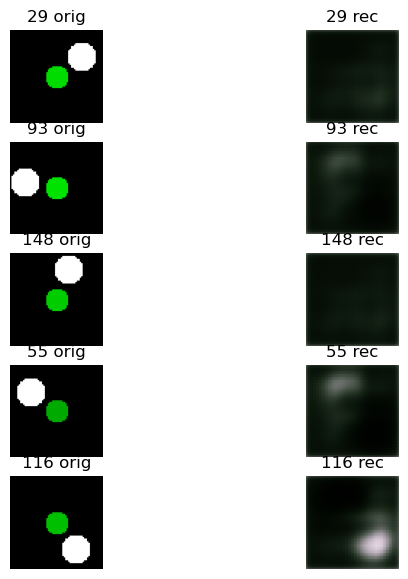

====> PCAAE2 Epoch: 6 Train loss: 0.079577,	 Train Rec loss: 0.068457,	 Train Dep loss: 0.011119
====> PCAAE2 Epoch: 6 Test loss: 0.077239,	 Test Rec loss: 0.066545,	 Test Dep loss: 0.010695
====> PCAAE2 Epoch: 7 Train loss: 0.077379,	 Train Rec loss: 0.066147,	 Train Dep loss: 0.011232
====> PCAAE2 Epoch: 7 Test loss: 0.075419,	 Test Rec loss: 0.065005,	 Test Dep loss: 0.010414
====> PCAAE2 Epoch: 8 Train loss: 0.075360,	 Train Rec loss: 0.064445,	 Train Dep loss: 0.010915
====> PCAAE2 Epoch: 8 Test loss: 0.072833,	 Test Rec loss: 0.063175,	 Test Dep loss: 0.009658
====> PCAAE2 Epoch: 9 Train loss: 0.072023,	 Train Rec loss: 0.062109,	 Train Dep loss: 0.009915
====> PCAAE2 Epoch: 9 Test loss: 0.068640,	 Test Rec loss: 0.059563,	 Test Dep loss: 0.009077
====> PCAAE2 Epoch: 10 Train loss: 0.069220,	 Train Rec loss: 0.057648,	 Train Dep loss: 0.011572
====> PCAAE2 Epoch: 10 Test loss: 0.064524,	 Test Rec loss: 0.053619,	 Test Dep loss: 0.010905


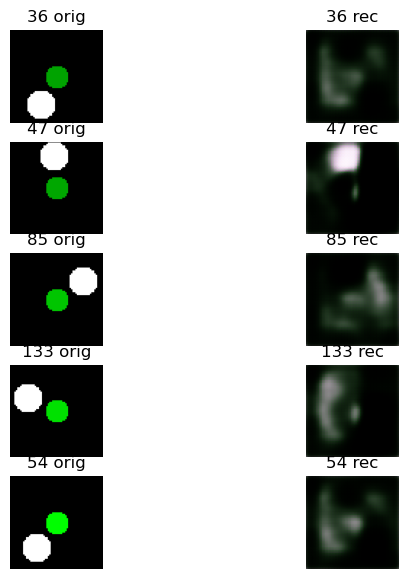

====> PCAAE2 Epoch: 11 Train loss: 0.063325,	 Train Rec loss: 0.053198,	 Train Dep loss: 0.010127
====> PCAAE2 Epoch: 11 Test loss: 0.058772,	 Test Rec loss: 0.049354,	 Test Dep loss: 0.009419
====> PCAAE2 Epoch: 12 Train loss: 0.060025,	 Train Rec loss: 0.049084,	 Train Dep loss: 0.010942
====> PCAAE2 Epoch: 12 Test loss: 0.056732,	 Test Rec loss: 0.046379,	 Test Dep loss: 0.010352
====> PCAAE2 Epoch: 13 Train loss: 0.055833,	 Train Rec loss: 0.046391,	 Train Dep loss: 0.009441
====> PCAAE2 Epoch: 13 Test loss: 0.054050,	 Test Rec loss: 0.043817,	 Test Dep loss: 0.010233
====> PCAAE2 Epoch: 14 Train loss: 0.055725,	 Train Rec loss: 0.044147,	 Train Dep loss: 0.011578
====> PCAAE2 Epoch: 14 Test loss: 0.051176,	 Test Rec loss: 0.041325,	 Test Dep loss: 0.009851
====> PCAAE2 Epoch: 15 Train loss: 0.053305,	 Train Rec loss: 0.042329,	 Train Dep loss: 0.010977
====> PCAAE2 Epoch: 15 Test loss: 0.049079,	 Test Rec loss: 0.039600,	 Test Dep loss: 0.009479


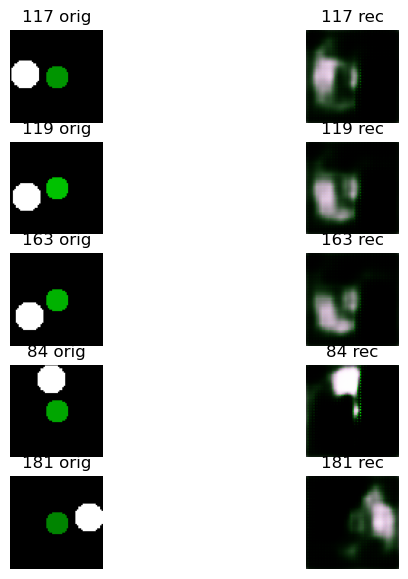

====> PCAAE2 Epoch: 16 Train loss: 0.050571,	 Train Rec loss: 0.040917,	 Train Dep loss: 0.009654
====> PCAAE2 Epoch: 16 Test loss: 0.047076,	 Test Rec loss: 0.036760,	 Test Dep loss: 0.010316
====> PCAAE2 Epoch: 17 Train loss: 0.048716,	 Train Rec loss: 0.039640,	 Train Dep loss: 0.009076
====> PCAAE2 Epoch: 17 Test loss: 0.046451,	 Test Rec loss: 0.035949,	 Test Dep loss: 0.010503
====> PCAAE2 Epoch: 18 Train loss: 0.049572,	 Train Rec loss: 0.038509,	 Train Dep loss: 0.011063
====> PCAAE2 Epoch: 18 Test loss: 0.044343,	 Test Rec loss: 0.034072,	 Test Dep loss: 0.010272
====> PCAAE2 Epoch: 19 Train loss: 0.050150,	 Train Rec loss: 0.037348,	 Train Dep loss: 0.012802
====> PCAAE2 Epoch: 19 Test loss: 0.042840,	 Test Rec loss: 0.032881,	 Test Dep loss: 0.009959
====> PCAAE2 Epoch: 20 Train loss: 0.046879,	 Train Rec loss: 0.035940,	 Train Dep loss: 0.010938
====> PCAAE2 Epoch: 20 Test loss: 0.042686,	 Test Rec loss: 0.032403,	 Test Dep loss: 0.010283


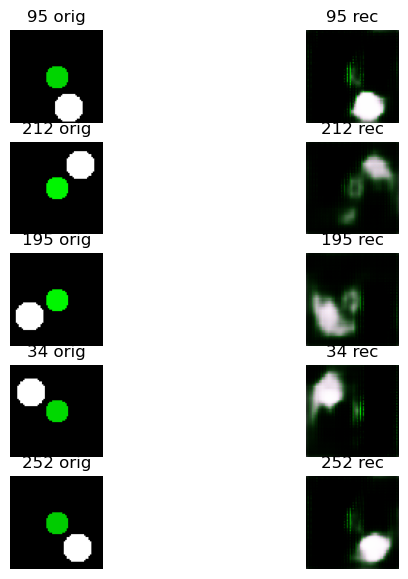

====> PCAAE2 Epoch: 21 Train loss: 0.046662,	 Train Rec loss: 0.036343,	 Train Dep loss: 0.010319
====> PCAAE2 Epoch: 21 Test loss: 0.041515,	 Test Rec loss: 0.031111,	 Test Dep loss: 0.010404
====> PCAAE2 Epoch: 22 Train loss: 0.045921,	 Train Rec loss: 0.034688,	 Train Dep loss: 0.011233
====> PCAAE2 Epoch: 22 Test loss: 0.041951,	 Test Rec loss: 0.031556,	 Test Dep loss: 0.010395
====> PCAAE2 Epoch: 23 Train loss: 0.045658,	 Train Rec loss: 0.034348,	 Train Dep loss: 0.011310
====> PCAAE2 Epoch: 23 Test loss: 0.040013,	 Test Rec loss: 0.029300,	 Test Dep loss: 0.010712
====> PCAAE2 Epoch: 24 Train loss: 0.043712,	 Train Rec loss: 0.034102,	 Train Dep loss: 0.009609
====> PCAAE2 Epoch: 24 Test loss: 0.041408,	 Test Rec loss: 0.030939,	 Test Dep loss: 0.010469
====> PCAAE2 Epoch: 25 Train loss: 0.044228,	 Train Rec loss: 0.033970,	 Train Dep loss: 0.010258
====> PCAAE2 Epoch: 25 Test loss: 0.041451,	 Test Rec loss: 0.030991,	 Test Dep loss: 0.010460


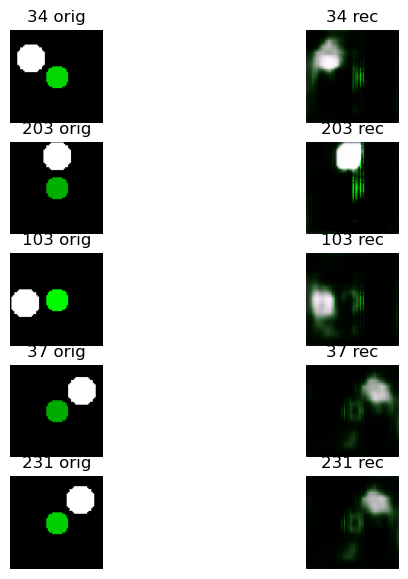

====> PCAAE2 Epoch: 26 Train loss: 0.042334,	 Train Rec loss: 0.033445,	 Train Dep loss: 0.008889
====> PCAAE2 Epoch: 26 Test loss: 0.038245,	 Test Rec loss: 0.027901,	 Test Dep loss: 0.010344
====> PCAAE2 Epoch: 27 Train loss: 0.043567,	 Train Rec loss: 0.032784,	 Train Dep loss: 0.010783
====> PCAAE2 Epoch: 27 Test loss: 0.042055,	 Test Rec loss: 0.031323,	 Test Dep loss: 0.010732
====> PCAAE2 Epoch: 28 Train loss: 0.041353,	 Train Rec loss: 0.032069,	 Train Dep loss: 0.009284
====> PCAAE2 Epoch: 28 Test loss: 0.039618,	 Test Rec loss: 0.029097,	 Test Dep loss: 0.010521
====> PCAAE2 Epoch: 29 Train loss: 0.042127,	 Train Rec loss: 0.032164,	 Train Dep loss: 0.009963
====> PCAAE2 Epoch: 29 Test loss: 0.039291,	 Test Rec loss: 0.029023,	 Test Dep loss: 0.010268
====> PCAAE2 Epoch: 30 Train loss: 0.042187,	 Train Rec loss: 0.031263,	 Train Dep loss: 0.010924
====> PCAAE2 Epoch: 30 Test loss: 0.036039,	 Test Rec loss: 0.025679,	 Test Dep loss: 0.010359


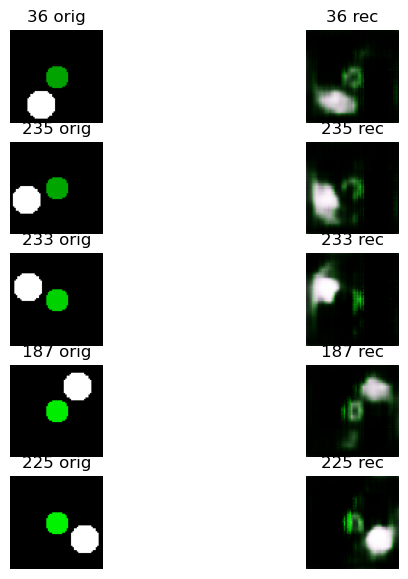

====> PCAAE2 Epoch: 31 Train loss: 0.043181,	 Train Rec loss: 0.031420,	 Train Dep loss: 0.011760
====> PCAAE2 Epoch: 31 Test loss: 0.043080,	 Test Rec loss: 0.032715,	 Test Dep loss: 0.010365
====> PCAAE2 Epoch: 32 Train loss: 0.042241,	 Train Rec loss: 0.030934,	 Train Dep loss: 0.011307
====> PCAAE2 Epoch: 32 Test loss: 0.035388,	 Test Rec loss: 0.025176,	 Test Dep loss: 0.010212
====> PCAAE2 Epoch: 33 Train loss: 0.041467,	 Train Rec loss: 0.029194,	 Train Dep loss: 0.012273
====> PCAAE2 Epoch: 33 Test loss: 0.034082,	 Test Rec loss: 0.024029,	 Test Dep loss: 0.010053
====> PCAAE2 Epoch: 34 Train loss: 0.038297,	 Train Rec loss: 0.027301,	 Train Dep loss: 0.010996
====> PCAAE2 Epoch: 34 Test loss: 0.034729,	 Test Rec loss: 0.024588,	 Test Dep loss: 0.010141
====> PCAAE2 Epoch: 35 Train loss: 0.036728,	 Train Rec loss: 0.027822,	 Train Dep loss: 0.008906
====> PCAAE2 Epoch: 35 Test loss: 0.032117,	 Test Rec loss: 0.022290,	 Test Dep loss: 0.009827


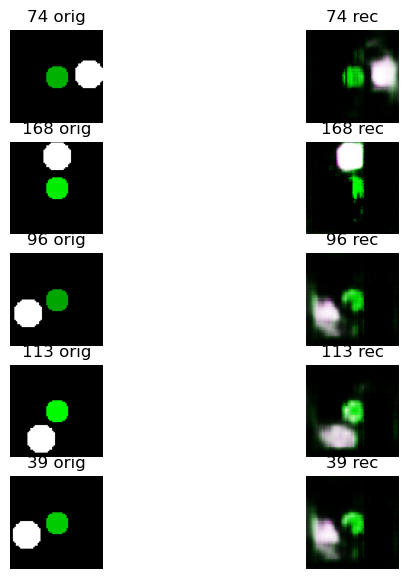

====> PCAAE2 Epoch: 36 Train loss: 0.039003,	 Train Rec loss: 0.027479,	 Train Dep loss: 0.011524
====> PCAAE2 Epoch: 36 Test loss: 0.032170,	 Test Rec loss: 0.021979,	 Test Dep loss: 0.010192
====> PCAAE2 Epoch: 37 Train loss: 0.037392,	 Train Rec loss: 0.026911,	 Train Dep loss: 0.010481
====> PCAAE2 Epoch: 37 Test loss: 0.031579,	 Test Rec loss: 0.021324,	 Test Dep loss: 0.010255
====> PCAAE2 Epoch: 38 Train loss: 0.037390,	 Train Rec loss: 0.028021,	 Train Dep loss: 0.009369
====> PCAAE2 Epoch: 38 Test loss: 0.031019,	 Test Rec loss: 0.020728,	 Test Dep loss: 0.010292
====> PCAAE2 Epoch: 39 Train loss: 0.037706,	 Train Rec loss: 0.026440,	 Train Dep loss: 0.011266
====> PCAAE2 Epoch: 39 Test loss: 0.030446,	 Test Rec loss: 0.020111,	 Test Dep loss: 0.010335
====> PCAAE2 Epoch: 40 Train loss: 0.037296,	 Train Rec loss: 0.026895,	 Train Dep loss: 0.010402
====> PCAAE2 Epoch: 40 Test loss: 0.031616,	 Test Rec loss: 0.021239,	 Test Dep loss: 0.010376


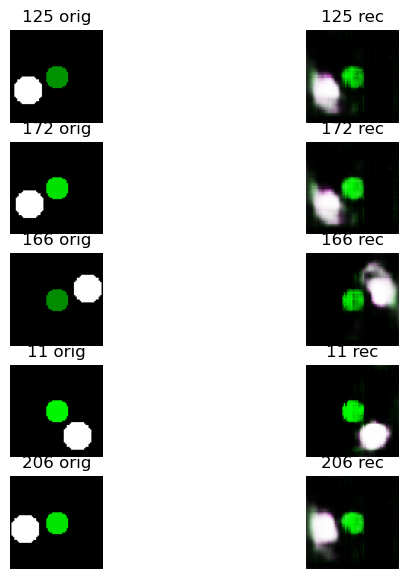

====> PCAAE2 Epoch: 41 Train loss: 0.034602,	 Train Rec loss: 0.023902,	 Train Dep loss: 0.010701
====> PCAAE2 Epoch: 41 Test loss: 0.029912,	 Test Rec loss: 0.019479,	 Test Dep loss: 0.010432
====> PCAAE2 Epoch: 42 Train loss: 0.034623,	 Train Rec loss: 0.024741,	 Train Dep loss: 0.009881
====> PCAAE2 Epoch: 42 Test loss: 0.032055,	 Test Rec loss: 0.021845,	 Test Dep loss: 0.010210
====> PCAAE2 Epoch: 43 Train loss: 0.033926,	 Train Rec loss: 0.024046,	 Train Dep loss: 0.009880
====> PCAAE2 Epoch: 43 Test loss: 0.029079,	 Test Rec loss: 0.018832,	 Test Dep loss: 0.010247
====> PCAAE2 Epoch: 44 Train loss: 0.036051,	 Train Rec loss: 0.025358,	 Train Dep loss: 0.010693
====> PCAAE2 Epoch: 44 Test loss: 0.029028,	 Test Rec loss: 0.018909,	 Test Dep loss: 0.010119
====> PCAAE2 Epoch: 45 Train loss: 0.036091,	 Train Rec loss: 0.026857,	 Train Dep loss: 0.009233
====> PCAAE2 Epoch: 45 Test loss: 0.029654,	 Test Rec loss: 0.019572,	 Test Dep loss: 0.010081


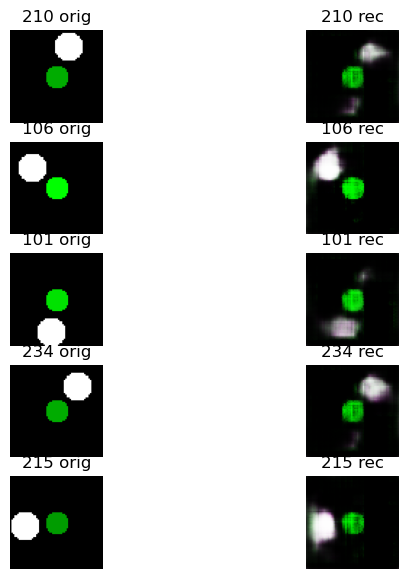

====> PCAAE2 Epoch: 46 Train loss: 0.035133,	 Train Rec loss: 0.023635,	 Train Dep loss: 0.011498
====> PCAAE2 Epoch: 46 Test loss: 0.028535,	 Test Rec loss: 0.018399,	 Test Dep loss: 0.010137
====> PCAAE2 Epoch: 47 Train loss: 0.034490,	 Train Rec loss: 0.024685,	 Train Dep loss: 0.009805
====> PCAAE2 Epoch: 47 Test loss: 0.028495,	 Test Rec loss: 0.018373,	 Test Dep loss: 0.010123
====> PCAAE2 Epoch: 48 Train loss: 0.034915,	 Train Rec loss: 0.023912,	 Train Dep loss: 0.011004
====> PCAAE2 Epoch: 48 Test loss: 0.029087,	 Test Rec loss: 0.018879,	 Test Dep loss: 0.010208
====> PCAAE2 Epoch: 49 Train loss: 0.034556,	 Train Rec loss: 0.023226,	 Train Dep loss: 0.011330
====> PCAAE2 Epoch: 49 Test loss: 0.027847,	 Test Rec loss: 0.017732,	 Test Dep loss: 0.010116
====> PCAAE2 Epoch: 50 Train loss: 0.036566,	 Train Rec loss: 0.026388,	 Train Dep loss: 0.010178
====> PCAAE2 Epoch: 50 Test loss: 0.029259,	 Test Rec loss: 0.019137,	 Test Dep loss: 0.010122


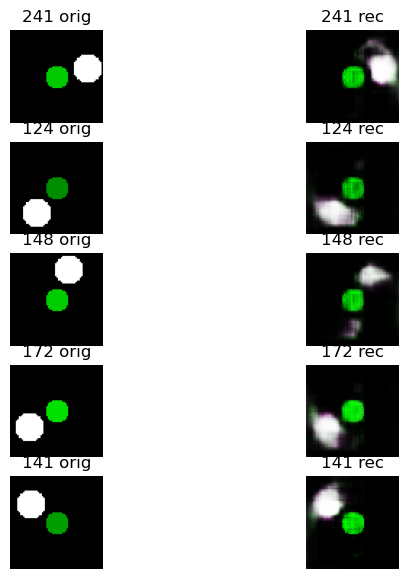

====> PCAAE2 Epoch: 51 Train loss: 0.033502,	 Train Rec loss: 0.023056,	 Train Dep loss: 0.010446
====> PCAAE2 Epoch: 51 Test loss: 0.028309,	 Test Rec loss: 0.017876,	 Test Dep loss: 0.010434
====> PCAAE2 Epoch: 52 Train loss: 0.036142,	 Train Rec loss: 0.025577,	 Train Dep loss: 0.010565
====> PCAAE2 Epoch: 52 Test loss: 0.027557,	 Test Rec loss: 0.017443,	 Test Dep loss: 0.010114
====> PCAAE2 Epoch: 53 Train loss: 0.037958,	 Train Rec loss: 0.024704,	 Train Dep loss: 0.013254
====> PCAAE2 Epoch: 53 Test loss: 0.027192,	 Test Rec loss: 0.017125,	 Test Dep loss: 0.010067
====> PCAAE2 Epoch: 54 Train loss: 0.033826,	 Train Rec loss: 0.023734,	 Train Dep loss: 0.010092
====> PCAAE2 Epoch: 54 Test loss: 0.028113,	 Test Rec loss: 0.017768,	 Test Dep loss: 0.010345
====> PCAAE2 Epoch: 55 Train loss: 0.034138,	 Train Rec loss: 0.022965,	 Train Dep loss: 0.011173
====> PCAAE2 Epoch: 55 Test loss: 0.027464,	 Test Rec loss: 0.017078,	 Test Dep loss: 0.010386


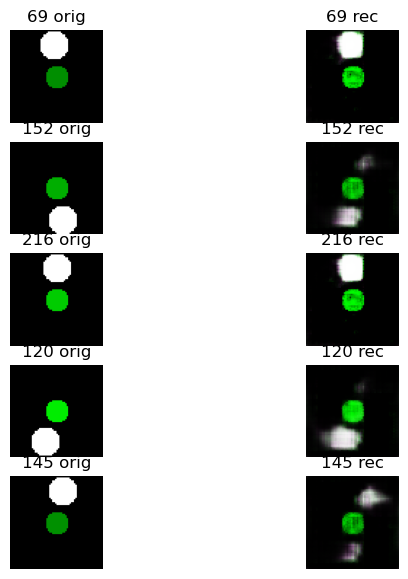

====> PCAAE2 Epoch: 56 Train loss: 0.036141,	 Train Rec loss: 0.025512,	 Train Dep loss: 0.010629
====> PCAAE2 Epoch: 56 Test loss: 0.029341,	 Test Rec loss: 0.019301,	 Test Dep loss: 0.010040
====> PCAAE2 Epoch: 57 Train loss: 0.033824,	 Train Rec loss: 0.023308,	 Train Dep loss: 0.010516
====> PCAAE2 Epoch: 57 Test loss: 0.027102,	 Test Rec loss: 0.016959,	 Test Dep loss: 0.010143
====> PCAAE2 Epoch: 58 Train loss: 0.035435,	 Train Rec loss: 0.024400,	 Train Dep loss: 0.011035
====> PCAAE2 Epoch: 58 Test loss: 0.031530,	 Test Rec loss: 0.021574,	 Test Dep loss: 0.009956
====> PCAAE2 Epoch: 59 Train loss: 0.035569,	 Train Rec loss: 0.023614,	 Train Dep loss: 0.011954
====> PCAAE2 Epoch: 59 Test loss: 0.026666,	 Test Rec loss: 0.016587,	 Test Dep loss: 0.010079
====> PCAAE2 Epoch: 60 Train loss: 0.032851,	 Train Rec loss: 0.022307,	 Train Dep loss: 0.010544
====> PCAAE2 Epoch: 60 Test loss: 0.026460,	 Test Rec loss: 0.016496,	 Test Dep loss: 0.009964


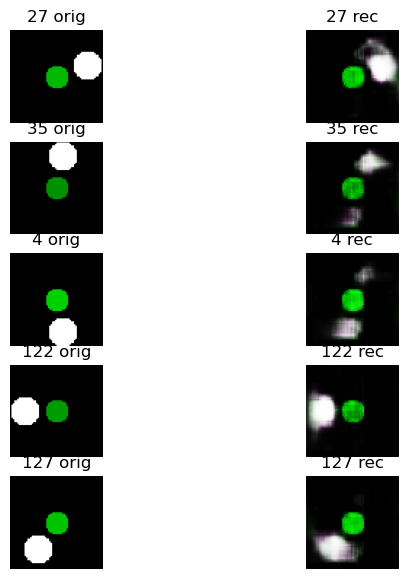

====> PCAAE2 Epoch: 61 Train loss: 0.035038,	 Train Rec loss: 0.025423,	 Train Dep loss: 0.009615
====> PCAAE2 Epoch: 61 Test loss: 0.026601,	 Test Rec loss: 0.016564,	 Test Dep loss: 0.010037
====> PCAAE2 Epoch: 62 Train loss: 0.035795,	 Train Rec loss: 0.023533,	 Train Dep loss: 0.012262
====> PCAAE2 Epoch: 62 Test loss: 0.026873,	 Test Rec loss: 0.016790,	 Test Dep loss: 0.010083
====> PCAAE2 Epoch: 63 Train loss: 0.030713,	 Train Rec loss: 0.021425,	 Train Dep loss: 0.009289
====> PCAAE2 Epoch: 63 Test loss: 0.026671,	 Test Rec loss: 0.016532,	 Test Dep loss: 0.010139
====> PCAAE2 Epoch: 64 Train loss: 0.032195,	 Train Rec loss: 0.021488,	 Train Dep loss: 0.010707
====> PCAAE2 Epoch: 64 Test loss: 0.028417,	 Test Rec loss: 0.018247,	 Test Dep loss: 0.010169
====> PCAAE2 Epoch: 65 Train loss: 0.033181,	 Train Rec loss: 0.022169,	 Train Dep loss: 0.011013
====> PCAAE2 Epoch: 65 Test loss: 0.026036,	 Test Rec loss: 0.015912,	 Test Dep loss: 0.010124


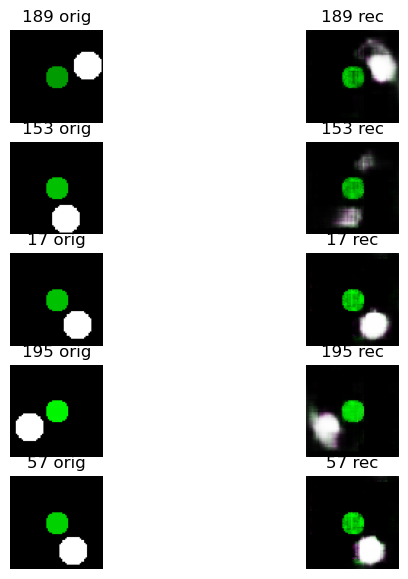

====> PCAAE2 Epoch: 66 Train loss: 0.033772,	 Train Rec loss: 0.022218,	 Train Dep loss: 0.011555
====> PCAAE2 Epoch: 66 Test loss: 0.026250,	 Test Rec loss: 0.016288,	 Test Dep loss: 0.009962
====> PCAAE2 Epoch: 67 Train loss: 0.030773,	 Train Rec loss: 0.021648,	 Train Dep loss: 0.009125
====> PCAAE2 Epoch: 67 Test loss: 0.025379,	 Test Rec loss: 0.015560,	 Test Dep loss: 0.009819
====> PCAAE2 Epoch: 68 Train loss: 0.033617,	 Train Rec loss: 0.022309,	 Train Dep loss: 0.011308
====> PCAAE2 Epoch: 68 Test loss: 0.026067,	 Test Rec loss: 0.016223,	 Test Dep loss: 0.009844
====> PCAAE2 Epoch: 69 Train loss: 0.032350,	 Train Rec loss: 0.021430,	 Train Dep loss: 0.010920
====> PCAAE2 Epoch: 69 Test loss: 0.024859,	 Test Rec loss: 0.015036,	 Test Dep loss: 0.009823
====> PCAAE2 Epoch: 70 Train loss: 0.032536,	 Train Rec loss: 0.022369,	 Train Dep loss: 0.010167
====> PCAAE2 Epoch: 70 Test loss: 0.025487,	 Test Rec loss: 0.015663,	 Test Dep loss: 0.009824


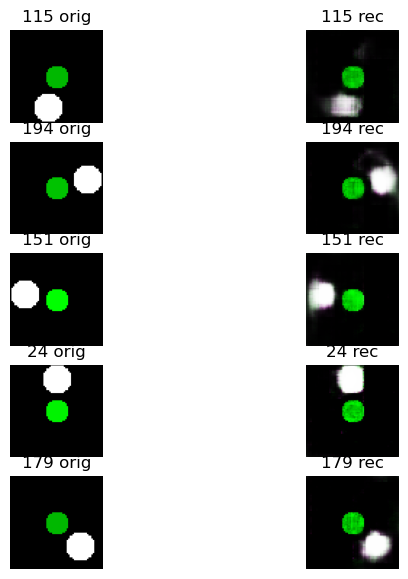

====> PCAAE2 Epoch: 71 Train loss: 0.030137,	 Train Rec loss: 0.019446,	 Train Dep loss: 0.010691
====> PCAAE2 Epoch: 71 Test loss: 0.025140,	 Test Rec loss: 0.015180,	 Test Dep loss: 0.009960
====> PCAAE2 Epoch: 72 Train loss: 0.032044,	 Train Rec loss: 0.022961,	 Train Dep loss: 0.009083
====> PCAAE2 Epoch: 72 Test loss: 0.024886,	 Test Rec loss: 0.014976,	 Test Dep loss: 0.009911
====> PCAAE2 Epoch: 73 Train loss: 0.032079,	 Train Rec loss: 0.021745,	 Train Dep loss: 0.010334
====> PCAAE2 Epoch: 73 Test loss: 0.025315,	 Test Rec loss: 0.015167,	 Test Dep loss: 0.010147
====> PCAAE2 Epoch: 74 Train loss: 0.034144,	 Train Rec loss: 0.021871,	 Train Dep loss: 0.012274
====> PCAAE2 Epoch: 74 Test loss: 0.024906,	 Test Rec loss: 0.014952,	 Test Dep loss: 0.009955
====> PCAAE2 Epoch: 75 Train loss: 0.028617,	 Train Rec loss: 0.020837,	 Train Dep loss: 0.007780
====> PCAAE2 Epoch: 75 Test loss: 0.024678,	 Test Rec loss: 0.014707,	 Test Dep loss: 0.009971


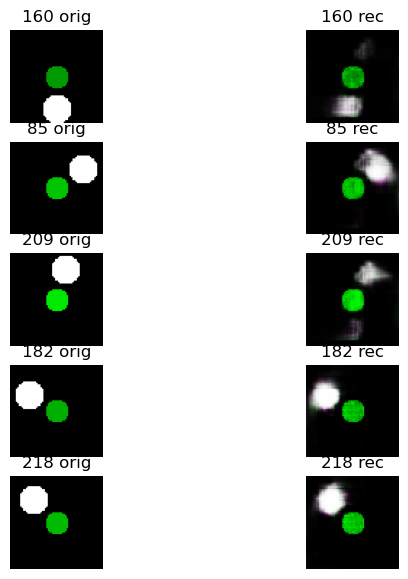

====> PCAAE2 Epoch: 76 Train loss: 0.031319,	 Train Rec loss: 0.021164,	 Train Dep loss: 0.010155
====> PCAAE2 Epoch: 76 Test loss: 0.024465,	 Test Rec loss: 0.014508,	 Test Dep loss: 0.009956
====> PCAAE2 Epoch: 77 Train loss: 0.033091,	 Train Rec loss: 0.022674,	 Train Dep loss: 0.010417
====> PCAAE2 Epoch: 77 Test loss: 0.025331,	 Test Rec loss: 0.015287,	 Test Dep loss: 0.010044
====> PCAAE2 Epoch: 78 Train loss: 0.030915,	 Train Rec loss: 0.020552,	 Train Dep loss: 0.010363
====> PCAAE2 Epoch: 78 Test loss: 0.024876,	 Test Rec loss: 0.014712,	 Test Dep loss: 0.010164
====> PCAAE2 Epoch: 79 Train loss: 0.032039,	 Train Rec loss: 0.022217,	 Train Dep loss: 0.009822
====> PCAAE2 Epoch: 79 Test loss: 0.024744,	 Test Rec loss: 0.014591,	 Test Dep loss: 0.010153
====> PCAAE2 Epoch: 80 Train loss: 0.029515,	 Train Rec loss: 0.019858,	 Train Dep loss: 0.009657
====> PCAAE2 Epoch: 80 Test loss: 0.024175,	 Test Rec loss: 0.013820,	 Test Dep loss: 0.010355


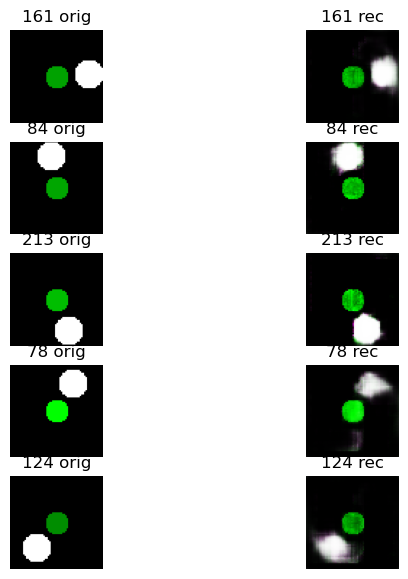

====> PCAAE2 Epoch: 81 Train loss: 0.030688,	 Train Rec loss: 0.019841,	 Train Dep loss: 0.010847
====> PCAAE2 Epoch: 81 Test loss: 0.024628,	 Test Rec loss: 0.014454,	 Test Dep loss: 0.010175
====> PCAAE2 Epoch: 82 Train loss: 0.029632,	 Train Rec loss: 0.021107,	 Train Dep loss: 0.008526
====> PCAAE2 Epoch: 82 Test loss: 0.025976,	 Test Rec loss: 0.016105,	 Test Dep loss: 0.009872
====> PCAAE2 Epoch: 83 Train loss: 0.030333,	 Train Rec loss: 0.020079,	 Train Dep loss: 0.010254
====> PCAAE2 Epoch: 83 Test loss: 0.024312,	 Test Rec loss: 0.014567,	 Test Dep loss: 0.009745
====> PCAAE2 Epoch: 84 Train loss: 0.032561,	 Train Rec loss: 0.022085,	 Train Dep loss: 0.010475
====> PCAAE2 Epoch: 84 Test loss: 0.024951,	 Test Rec loss: 0.015080,	 Test Dep loss: 0.009872
====> PCAAE2 Epoch: 85 Train loss: 0.031802,	 Train Rec loss: 0.021843,	 Train Dep loss: 0.009959
====> PCAAE2 Epoch: 85 Test loss: 0.027745,	 Test Rec loss: 0.017803,	 Test Dep loss: 0.009942


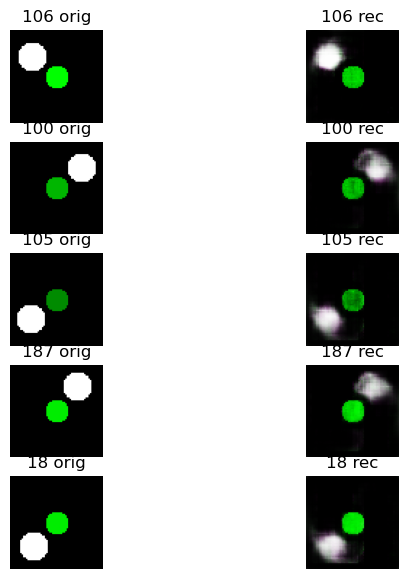

====> PCAAE2 Epoch: 86 Train loss: 0.030911,	 Train Rec loss: 0.020002,	 Train Dep loss: 0.010909
====> PCAAE2 Epoch: 86 Test loss: 0.023525,	 Test Rec loss: 0.013846,	 Test Dep loss: 0.009680
====> PCAAE2 Epoch: 87 Train loss: 0.031428,	 Train Rec loss: 0.020378,	 Train Dep loss: 0.011050
====> PCAAE2 Epoch: 87 Test loss: 0.023895,	 Test Rec loss: 0.013917,	 Test Dep loss: 0.009978
====> PCAAE2 Epoch: 88 Train loss: 0.032402,	 Train Rec loss: 0.021660,	 Train Dep loss: 0.010742
====> PCAAE2 Epoch: 88 Test loss: 0.023873,	 Test Rec loss: 0.014257,	 Test Dep loss: 0.009616
====> PCAAE2 Epoch: 89 Train loss: 0.031666,	 Train Rec loss: 0.019971,	 Train Dep loss: 0.011695
====> PCAAE2 Epoch: 89 Test loss: 0.023611,	 Test Rec loss: 0.013880,	 Test Dep loss: 0.009731
====> PCAAE2 Epoch: 90 Train loss: 0.034099,	 Train Rec loss: 0.022296,	 Train Dep loss: 0.011803
====> PCAAE2 Epoch: 90 Test loss: 0.023168,	 Test Rec loss: 0.013531,	 Test Dep loss: 0.009637


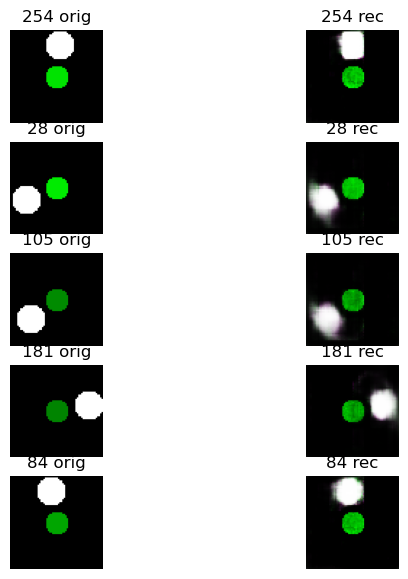

====> PCAAE2 Epoch: 91 Train loss: 0.034091,	 Train Rec loss: 0.023864,	 Train Dep loss: 0.010227
====> PCAAE2 Epoch: 91 Test loss: 0.027727,	 Test Rec loss: 0.018147,	 Test Dep loss: 0.009581
====> PCAAE2 Epoch: 92 Train loss: 0.031464,	 Train Rec loss: 0.021360,	 Train Dep loss: 0.010104
====> PCAAE2 Epoch: 92 Test loss: 0.023113,	 Test Rec loss: 0.014432,	 Test Dep loss: 0.008681
====> PCAAE2 Epoch: 93 Train loss: 0.032111,	 Train Rec loss: 0.021407,	 Train Dep loss: 0.010704
====> PCAAE2 Epoch: 93 Test loss: 0.025319,	 Test Rec loss: 0.015240,	 Test Dep loss: 0.010078
====> PCAAE2 Epoch: 94 Train loss: 0.032093,	 Train Rec loss: 0.021485,	 Train Dep loss: 0.010608
====> PCAAE2 Epoch: 94 Test loss: 0.026645,	 Test Rec loss: 0.017443,	 Test Dep loss: 0.009202
====> PCAAE2 Epoch: 95 Train loss: 0.029991,	 Train Rec loss: 0.021339,	 Train Dep loss: 0.008652
====> PCAAE2 Epoch: 95 Test loss: 0.022909,	 Test Rec loss: 0.014336,	 Test Dep loss: 0.008573


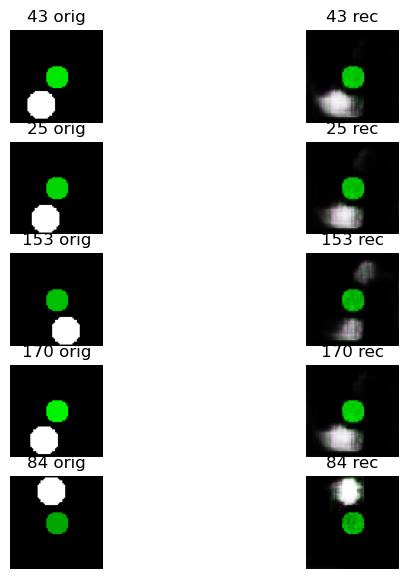

====> PCAAE2 Epoch: 96 Train loss: 0.031957,	 Train Rec loss: 0.021326,	 Train Dep loss: 0.010631
====> PCAAE2 Epoch: 96 Test loss: 0.022124,	 Test Rec loss: 0.013058,	 Test Dep loss: 0.009066
====> PCAAE2 Epoch: 97 Train loss: 0.032665,	 Train Rec loss: 0.021141,	 Train Dep loss: 0.011523
====> PCAAE2 Epoch: 97 Test loss: 0.022224,	 Test Rec loss: 0.013474,	 Test Dep loss: 0.008751
====> PCAAE2 Epoch: 98 Train loss: 0.029232,	 Train Rec loss: 0.020667,	 Train Dep loss: 0.008565
====> PCAAE2 Epoch: 98 Test loss: 0.021931,	 Test Rec loss: 0.013347,	 Test Dep loss: 0.008584
====> PCAAE2 Epoch: 99 Train loss: 0.031856,	 Train Rec loss: 0.021396,	 Train Dep loss: 0.010460
====> PCAAE2 Epoch: 99 Test loss: 0.021725,	 Test Rec loss: 0.013154,	 Test Dep loss: 0.008571
====> PCAAE2 Epoch: 100 Train loss: 0.031648,	 Train Rec loss: 0.021292,	 Train Dep loss: 0.010356
====> PCAAE2 Epoch: 100 Test loss: 0.022438,	 Test Rec loss: 0.013276,	 Test Dep loss: 0.009162


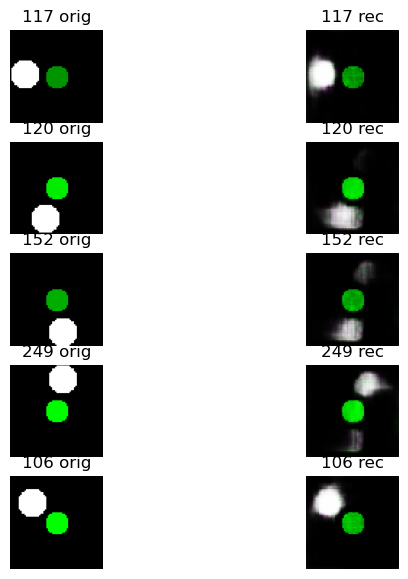

In [23]:
dcor_PCAAE_path = './models/dcor_PCAAE/'
if os.path.exists(dcor_PCAAE_path) is False:
    os.makedirs(dcor_PCAAE_path)
model_path_list = sorted(glob(f'{dcor_PCAAE_path}dcor_PCAAE_step*'), key=len)

if len(model_path_list) != 0:
    print('A trained model is found')
    is_training = False
    weightname = model_path_list[-1]

if is_training:
    print("Training dcor-PCAAE \n")
    for step in range(1, train_latent + 1):
        weightname = f'{dcor_PCAAE_path}dcor_PCAAE_step{step}_lambdadep{lambda_dep_dcor}'
        for epoch in range(1, num_epoch + 1):
            train_PCAAE(dcor_PCAAE_E, dcor_PCAAE_D, dcor_PCAAE_optim, epoch, step, device, train_loader, test_loader,
                         lambda_rec, lambda_dep_dcor, basic_loss=False)
            torch.save( {'dcor_PCAAE_E_state_dict': dcor_PCAAE_E[step-1].state_dict(),
                         'dcor_PCAAE_D_state_dict': dcor_PCAAE_D[step-1].state_dict(),
                         'dcor_PCAAE_optim_state_dict': dcor_PCAAE_optim[step-1].state_dict(),}, 
                        weightname)
                    
else:
    print(f"Load the model: {weightname}")
    checkpoint_dcor_PCAAE = torch.load(weightname, device)
    dcor_PCAAE_E[test_latent-1].load_state_dict(checkpoint_dcor_PCAAE['dcor_PCAAE_E_state_dict'])
    dcor_PCAAE_D[test_latent-1].load_state_dict(checkpoint_dcor_PCAAE['dcor_PCAAE_D_state_dict'])

## Qualitative test

output image comparison

In [24]:
img_plot_size = 5
img_sample_num = int(img_plot_size**2)
figsize=12
sample_list = np.sort(np.random.choice(np.arange(batchsize, dtype=int), size=img_sample_num, replace=False))
sample_list  

array([ 27,  47,  52,  97, 108, 124, 129, 130, 142, 153, 157, 158, 168,
       177, 186, 193, 202, 211, 214, 230, 234, 235, 240, 245, 255])

In [25]:
def reconstruction_plot(encoder, decoder, data, test_latent, sample_list, suptitle: str,
                        PCAAE=True, device='cuda', img_plot_size=5, fig_size=12):
    
    data = data.to(device)
        
    if PCAAE:
        for idx_step in range(1, test_latent+1):
            encoder[idx_step-1].eval()
        D = decoder[test_latent-1].eval()
    else:
        E = encoder.eval()
        D = decoder.eval()
    
    plt.figure(figsize=(figsize, figsize))
    with torch.no_grad():
        for i in range(img_sample_num):
            k = sample_list[i]
            ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
            ax.title.set_text('{}'.format(k))
            
            img = torch.unsqueeze(data[k], 0)
            
            if PCAAE:
                z = []
                for jd in range(test_latent-1):
                    z.append(encoder[jd](img))
                z_i = encoder[test_latent-1](img)
                z.append(z_i)
                latent_code = torch.cat(z, dim=-1)
            else:
                latent_code = E(img)

            img_rec = torch.squeeze(D(latent_code), 0).permute(1,2,0).detach().cpu().numpy()
            plt.imshow(img_rec)
            plt.axis("off")
            plt.suptitle(f"{suptitle}", fontsize=32)

original images

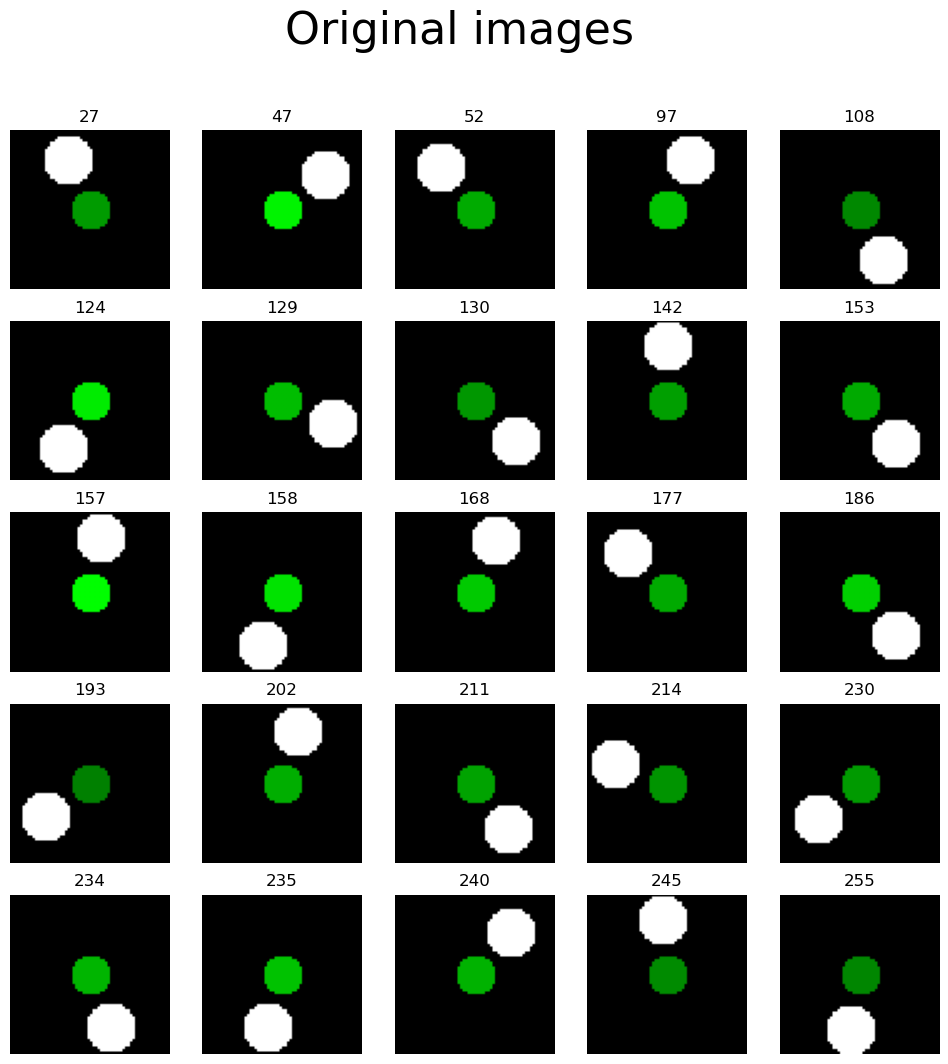

In [26]:
plt.figure(figsize=(figsize, figsize))
for i in range(img_sample_num):
    k = sample_list[i]
    ax = plt.subplot(img_plot_size, img_plot_size, i + 1)
    ax.title.set_text('{}'.format(k))
    img = data[k].permute(1,2,0)
    plt.imshow(img)
    plt.axis("off")
    plt.suptitle('Original images', fontsize=32)

simple AE output

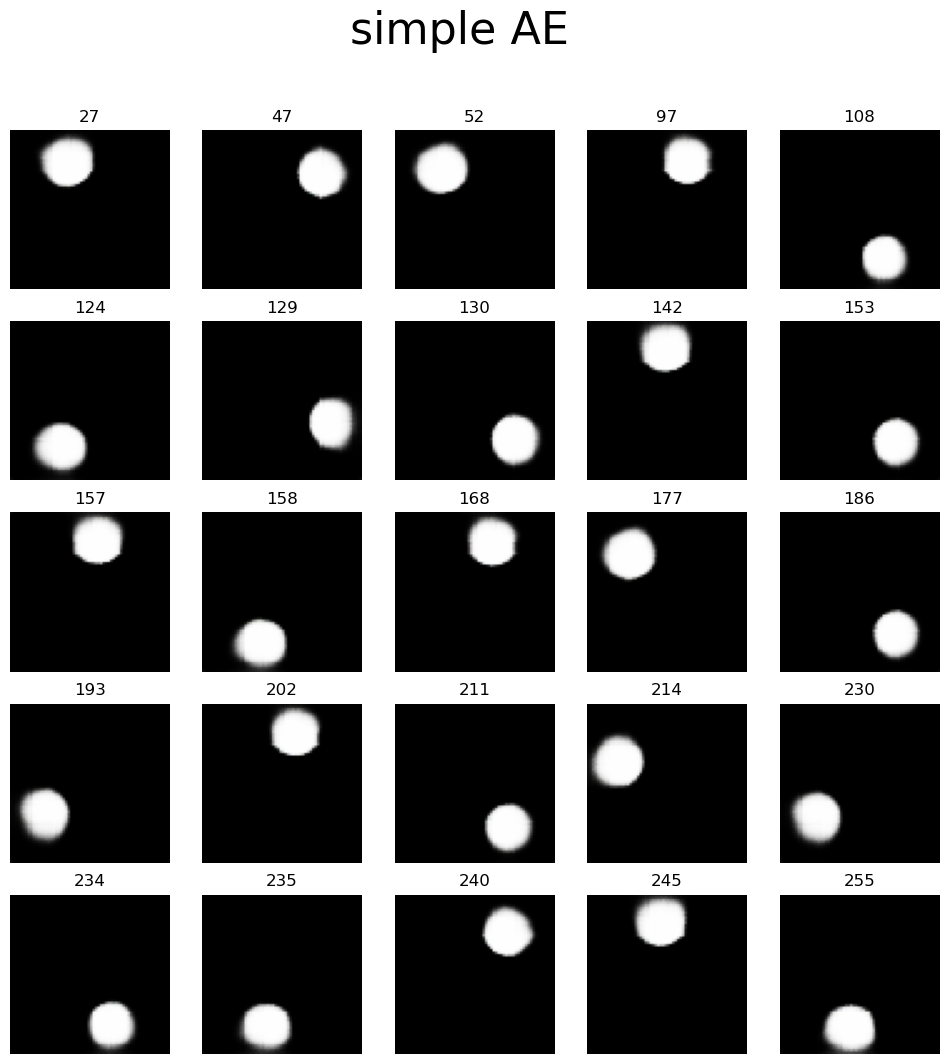

In [27]:
reconstruction_plot(simple_AE_E, simple_AE_D, data, test_latent, sample_list, suptitle='simple AE', PCAAE=False, device=device)

basic PCA-AE output

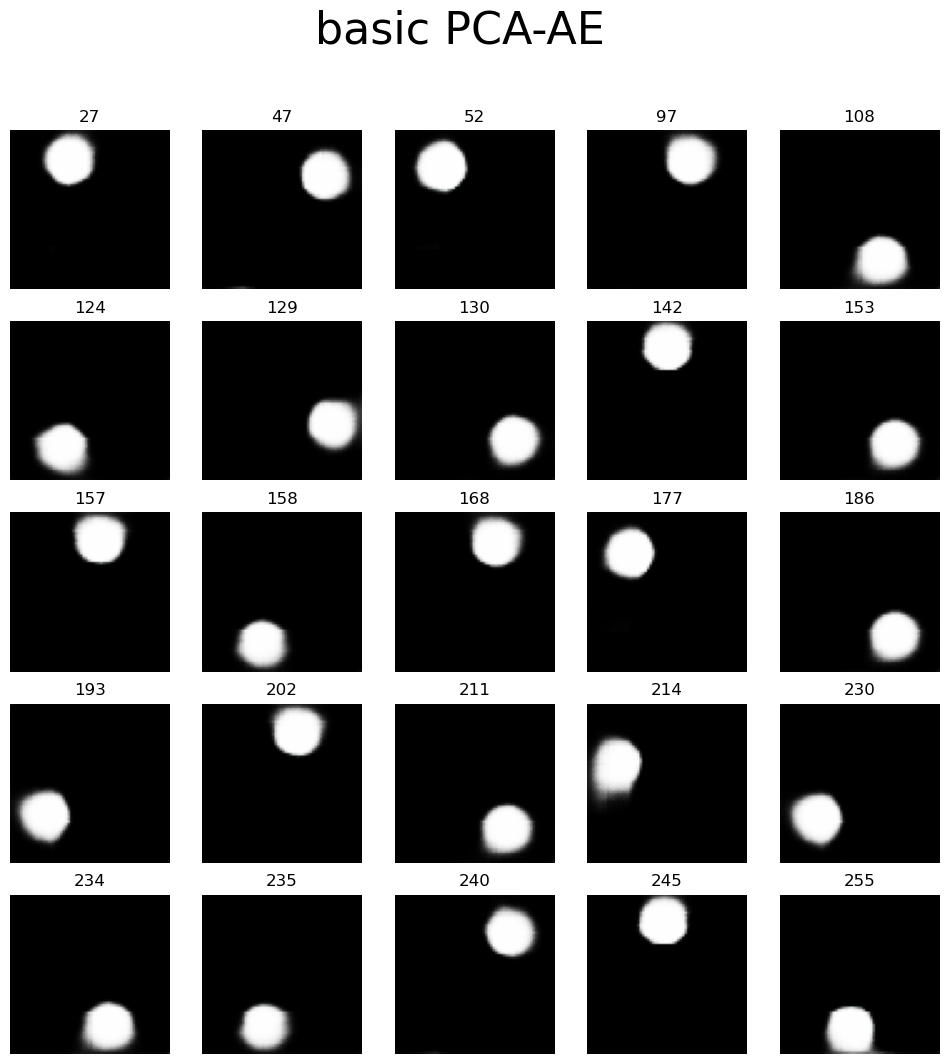

In [28]:
reconstruction_plot(basic_PCAAE_E, basic_PCAAE_D, data, test_latent, sample_list, suptitle='basic PCA-AE', device=device)

modified PCA-AE output

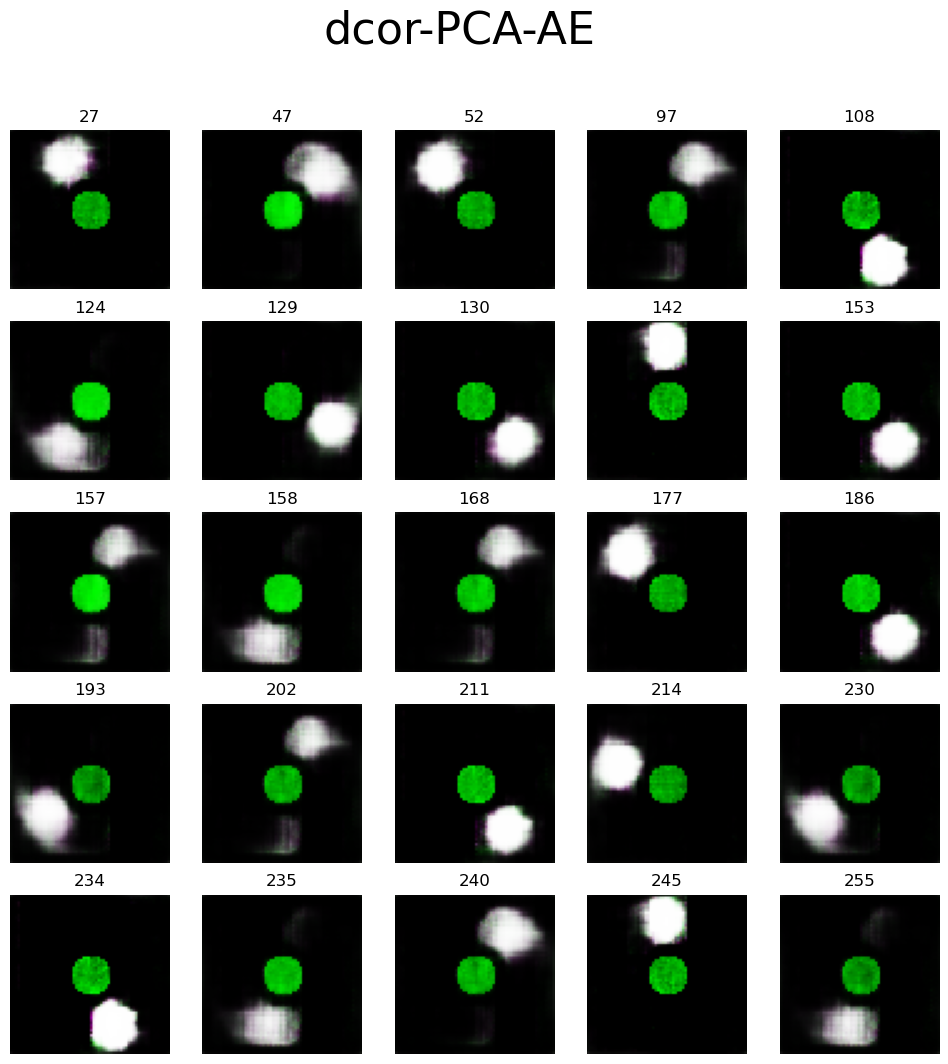

In [29]:
reconstruction_plot(dcor_PCAAE_E, dcor_PCAAE_D, data, test_latent, sample_list, suptitle='dcor-PCA-AE', device=device)

### image interpolations from latent space

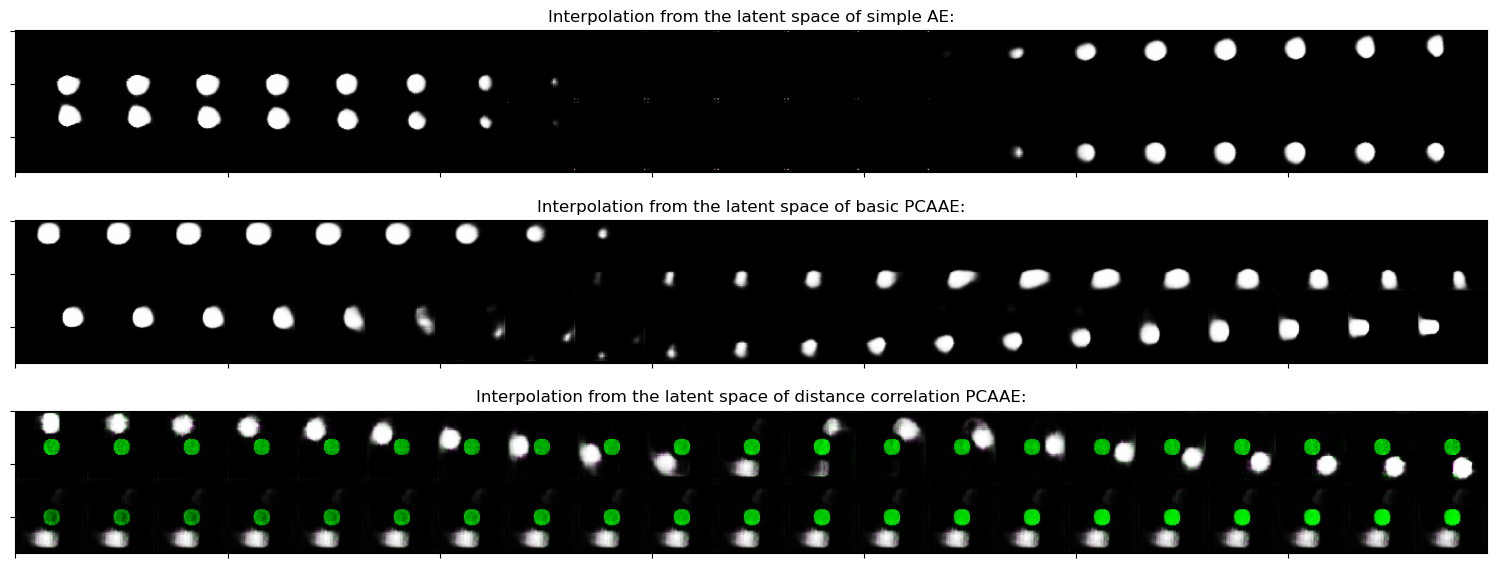

In [30]:
def test_model(model_D, nrow=21):
    z = torch.linspace(-2, 2, nrow).unsqueeze(1)
    length = len(z)
    z1_full = torch.cat((z, torch.zeros(length, 1)),dim=-1).to(device)
    z2_full = torch.cat((torch.zeros(length, 1), z),dim=-1).to(device)
    with torch.no_grad():
        rec_z1_AE = model_D(z1_full)
        rec_z2_AE = model_D(z2_full)
        rec_AE = torch.cat((rec_z1_AE, rec_z2_AE), dim=0)
    return rec_AE
   
fig, ax = plt.subplots(figsize=(19, 7))
ax.axis('off')
nrow = 21

grid_AE = torchvision.utils.make_grid(test_model(simple_AE_D, nrow=nrow).clamp(min=-1, max=1), nrow=nrow, scale_each=True, normalize=True).cpu().numpy()

ax1 = fig.add_subplot(3,1,1, xticklabels=[], yticklabels=[])
ax1.title.set_text("Interpolation from the latent space of simple AE:")
plt.imshow(grid_AE.transpose(1,2,0))

grid_basic_PCAAE = torchvision.utils.make_grid(test_model(basic_PCAAE_D[test_latent-1], nrow=nrow).clamp(min=-1, max=1),  nrow=nrow, scale_each=True, normalize=True).cpu().numpy()

ax2 = fig.add_subplot(3,1,2, xticklabels=[], yticklabels=[])
ax2.title.set_text("Interpolation from the latent space of basic PCAAE:")
plt.imshow(grid_basic_PCAAE.transpose(1,2,0))

grid_dcor_PCAAE = torchvision.utils.make_grid(test_model(dcor_PCAAE_D[test_latent-1], nrow=nrow).clamp(min=-1, max=1),  nrow=nrow, scale_each=True, normalize=True).cpu().numpy()

ax3 = fig.add_subplot(3,1,3, xticklabels=[], yticklabels=[])
ax3.title.set_text("Interpolation from the latent space of distance correlation PCAAE:")
plt.imshow(grid_dcor_PCAAE.transpose(1,2,0))

plt.show()

##  Quantitative test

calculate MIC between code z and the following factors:

angle of white ball in polar coordinate, brightness of green center ball

In [31]:
def search_coordinates(rec):
    rec = rec.detach().cpu().numpy()
    batch_size = len(rec)
    base_radius = int(np.sqrt(image_size))
    circle_radius = int(base_radius * 5 / 4)
    coordinates = np.full((batch_size, 2), -1)
    
    for i in range(batch_size):
        criterion = 0.5
        temp_x1, temp_x2 = -1, -1
        for angle in np.linspace(0, 355, 72, dtype=int):
            theta = np.deg2rad(angle)
            scaled_x1, scaled_x2 = np.cos(theta), np.sin(theta)
            x1 = np.round(((scaled_x1 + 1) / 2) * (image_size-2*circle_radius) + circle_radius, decimals=0)
            x2 = np.round(((scaled_x2 + 1) / 2) * (image_size-2*circle_radius) + circle_radius, decimals=0)
            rr, cc = disk((x2, x1), circle_radius)
            ball = rec[i, :, rr, cc]
            brightness = ball.flatten().mean()
            if brightness > criterion:
                criterion = brightness
                temp_x1, temp_x2 = x1, x2
        coordinates[i, 0], coordinates[i, 1] = temp_x1, temp_x2
    
    if np.min(coordinates) < 0:
        raise Exception("coordinates error")
        
    coordinates = ((coordinates - circle_radius) / (image_size-2*circle_radius)) * 2 - 1
    return coordinates


def evaluation(z, rec): 
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    
    # Latent space's components
    z1 = z[:,0].detach().cpu().numpy()
    z2 = z[:,1].detach().cpu().numpy()
    
    # angle of white ball
    coordinates = search_coordinates(rec)
    x1_hat, x2_hat = coordinates[:, 0], coordinates[:, 1]
    with np.errstate(divide='ignore', invalid='ignore'):
        A = np.arctan(x2_hat/x1_hat)
    # brightness of the green center ball
    half_radius = int(np.sqrt(image_size))//2
    B = rec[:, 1, image_size//2-half_radius:image_size//2+half_radius+1, image_size//2-half_radius:image_size//2+half_radius+1].flatten(start_dim=1).median(dim=1)[0].detach().cpu().numpy()
    
    # compute MIC
    mine.compute_score(A, z1)
    mic_A1 = mine.mic()
    mine.compute_score(A, z2)
    mic_A2 = mine.mic()
    mine.compute_score(B, z1)
    mic_B1 = mine.mic()
    mine.compute_score(B, z2)
    mic_B2 = mine.mic()
    
    return np.round( ((mic_A1, mic_A2), (mic_B1, mic_B2)), 3 )

computation of the latent space

In [32]:
test_dataset = generating_data(1024, image_size=image_size, max_bright=max_bright)
test_dataset = torch.stack([torch.Tensor(i) for i in test_dataset])/ max_bright
test_dataset = test_dataset.to(device)
with torch.no_grad():
#     z_AE = simple_AE_E.eval()(test_dataset)
    
#     z_basic_PCAAE = torch.cat((basic_PCAAE_E[0].eval()(test_dataset),
#                                basic_PCAAE_E[1].eval()(test_dataset), ), dim=-1)
    
    z_dcor_PCAAE = torch.cat((dcor_PCAAE_E[0].eval()(test_dataset),
                              dcor_PCAAE_E[1].eval()(test_dataset), ), dim=-1)

the quantitative results

In [33]:
# evaluation(z_AE, test_dataset)

In [34]:
# evaluation(z_basic_PCAAE, test_dataset)

In [35]:
evaluation(z_dcor_PCAAE, test_dataset)

array([[1.   , 0.127],
       [0.276, 1.   ]])